# Deep Kernel Learning for Cards (and Process Optimization, Molecules, ...)

- Made by Mani Valleti, https://scholar.google.com/citations?hl=en&user=Jt7c5d4AAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!



In this notebook, we illustrate the principles of deep kernel learning (DKL) for applications such as process optimization, scientific discovery, or active experiment. As a model scenario, we use the discovery of the properties in card data set. Here, we have the collection of 4 type of images (diamonds, clubs, pikes, and hearts) that have been transformed via application of rotations, shear, and translations. We aim to learn functions f(image) -> suite and g(image) -> (rotation or shear) in an active manner. 

This of course is a well-familiar problem for ML, if the data set is available in full. Then it f(image)->suite is a supervised classification problem, and g(image) -> (rotation or shear) is a regression problem.

However, here we attempt to explore these as an active learning problem. In this settings, the data (features) are available in full in the beginning of the experiment. However, the attributes (targets) are not - they become available only if we query data. This setting imitates experiment, where we choose which protocol to test, molecule to synthesize, or region of image to explore. Overall, we want to train our functions f(image) and g(image) in the shortest number of steps in an active manner, meaning that given all images and few targets, the algorith queries the image space for attributes sequentially. 

While somewhat abstract as applied to cards, this problem has multiple real world applications. We can explore:
- image space in microscopy (local patches) to decide where to take detailed measurements
- molecular space  to decide which property to test (or calculate)
- processign space for optimization of manufacturing process
- charging trajectory of a battery to minimize charging time or maximize safety
- and so on. 

In other words, card image is our multidimensional object, and hand or distortion is a function we want to discover via active learning. You can find more disucssion of this topic in:

https://arxiv.org/abs/2303.14554


In [ ]:
!pip install kornia
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 45.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 54.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not current

In [ ]:
import atomai as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
tt = torch.tensor
import numpy as np
import matplotlib.pyplot as plt

# Importing the packages
#import pyroved as pv
#import gpim

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import pickle

In [ ]:
#@title Helper function and downloading the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)
    

    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4
    
    card1 = K.geometry.transform.resize(cards[0], (45,45), interpolation='bilinear')
    card2 = K.geometry.transform.resize(cards[1], (45,45), interpolation='bilinear')
    card3 = K.geometry.transform.resize(cards[2], (45,45), interpolation='bilinear')
    card4 = K.geometry.transform.resize(cards[3], (45,45), interpolation='bilinear')

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((30, 30)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float() 
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

First, we create a data set of cards of different hands, varying in rotations, translations, and shear. Here, we draw 2000 data sets. You can play with a smaller number, but then VAEs should be trained longer. Furthermore, the behavior of the VAE, rVAE, and DKL will be very much affected by the distirbution parameters - feel free to experiment what will happen if the angle distribution is much narrower compared to translation/shear, if some factors are made very small, etc. 

In [ ]:
cards = get_data()

cards_all, labels_all, angles_all, translations_all, shears_all = transform_imgs(cards, 
                                                                                angle = 120, 
                                                                                translation = 0.1,
                                                                                shear = 20,
                                                                                samples = 2000)

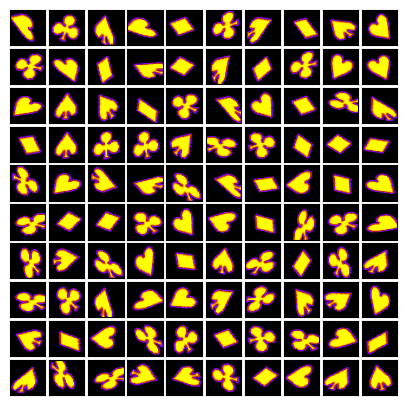

In [ ]:
# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='bilinear')

# VAE on the dataset

First we perform the VAE analysis on the cards data set. VAE analysis is always useful first step when working in the unsupervised or active learning problems, where the feature space is available in full and target space needs to be explored sequentially. Since here we have the access to the ground truth labels, it gives us some idea how the behaviors we can obtain from feature data only (latent representations and distributions) compare to the targets of interest. 

If the ground truth data is available (meaning we have toy problem with known answers), visualization of the target fucntion behavior in the latent space allows to have a very good idea how useful the analysis may be on a real data (without the targets available)

In [ ]:
# Running the model with atomai rvae
input_dim = (30,30)
vae = aoi.models.VAE(input_dim, latent_dim=2,
                    numlayers_encoder=3, numhidden_encoder=1024,
                    numlayers_decoder=3, numhidden_decoder=1024,
                    skip=True)
    
vae.fit(cards_all, training_cycles=200, batch_size=75, loss="ce",
         filename='vae')

Epoch: 1/200, Training loss: 311.7576
Epoch: 2/200, Training loss: 261.4235
Epoch: 3/200, Training loss: 239.2508
Epoch: 4/200, Training loss: 224.3549
Epoch: 5/200, Training loss: 219.5787
Epoch: 6/200, Training loss: 215.2642
Epoch: 7/200, Training loss: 210.4019
Epoch: 8/200, Training loss: 205.6571
Epoch: 9/200, Training loss: 201.4374
Epoch: 10/200, Training loss: 197.5008
Epoch: 11/200, Training loss: 193.9141
Epoch: 12/200, Training loss: 190.7321
Epoch: 13/200, Training loss: 187.5367
Epoch: 14/200, Training loss: 184.8035
Epoch: 15/200, Training loss: 182.6228
Epoch: 16/200, Training loss: 179.9630
Epoch: 17/200, Training loss: 177.9862
Epoch: 18/200, Training loss: 176.1423
Epoch: 19/200, Training loss: 173.8871
Epoch: 20/200, Training loss: 172.0510
Epoch: 21/200, Training loss: 170.5412
Epoch: 22/200, Training loss: 169.0589
Epoch: 23/200, Training loss: 167.5225
Epoch: 24/200, Training loss: 165.9809
Epoch: 25/200, Training loss: 164.3090
Epoch: 26/200, Training loss: 162.

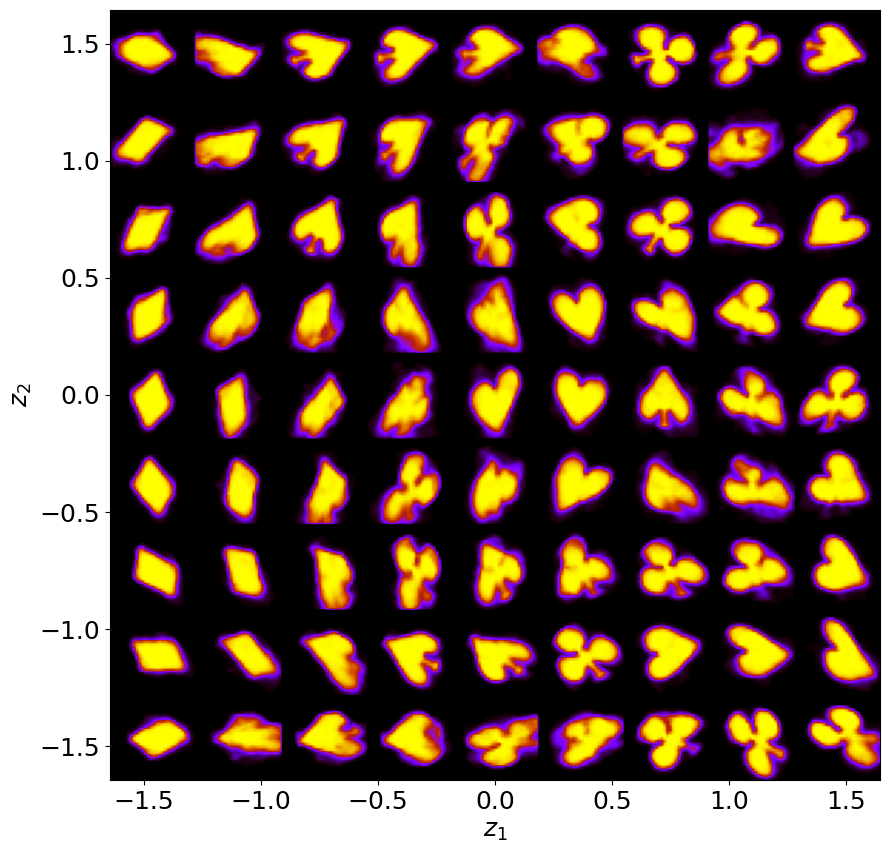

In [ ]:
# Latent representation
vae.manifold2d(d = 9, origin = 'upper');

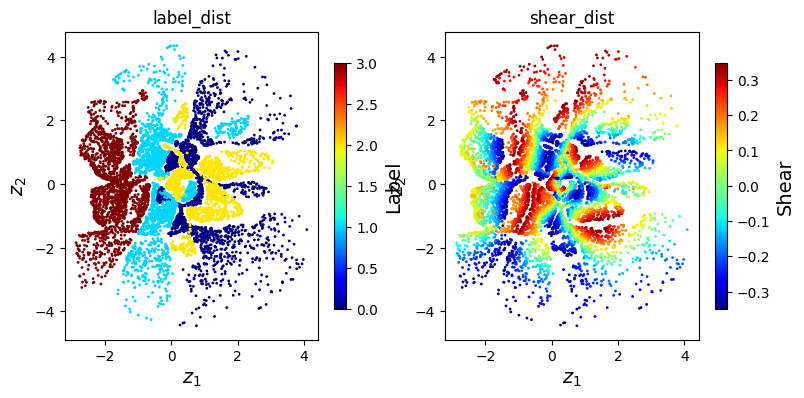

In [ ]:
# Latent distributions

z_mean, z_sd = vae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=1, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note here that the ground truth labels have very complex distribution in the latent space. This is because different factors of variability including the hand, rotation, and shear "compete" for latent space. The manifolds corresponding to different hands cannot mix (unless objects are identical) as driven by reconstruction loss, but at the same time KL loss tries to bring them together.  

Experiment with the variability of the data set - e.g. the distributions of the angles vs. shear. The manifolds will change!

# rVAE on the dataset

Now, let's check this supposition by running the rotationally invariant VAE, where the rotation is separated into a dedicated latent variable. 

In [ ]:
# Running the model with atomai rvae
input_dim = (30,30)
rvae = aoi.models.rVAE(input_dim, latent_dim=2,
                        numlayers_encoder=3, numhidden_encoder=1024,
                        numlayers_decoder=3, numhidden_decoder=1024,
                        skip=True)
    
rvae.fit(cards_all, training_cycles=100, batch_size=75, loss="ce", translation_prior=0.1,
         filename='rvae')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/100, Training loss: 324.6543
Epoch: 2/100, Training loss: 207.5169
Epoch: 3/100, Training loss: 194.3132
Epoch: 4/100, Training loss: 186.7886
Epoch: 5/100, Training loss: 180.9382
Epoch: 6/100, Training loss: 177.4011
Epoch: 7/100, Training loss: 171.9142
Epoch: 8/100, Training loss: 165.3217
Epoch: 9/100, Training loss: 159.0296
Epoch: 10/100, Training loss: 152.8971
Epoch: 11/100, Training loss: 145.6085
Epoch: 12/100, Training loss: 142.2714
Epoch: 13/100, Training loss: 134.4059
Epoch: 14/100, Training loss: 129.9194
Epoch: 15/100, Training loss: 128.3138
Epoch: 16/100, Training loss: 121.9129
Epoch: 17/100, Training loss: 118.6500
Epoch: 18/100, Training loss: 115.9873
Epoch: 19/100, Training loss: 112.1218
Epoch: 20/100, Training loss: 110.4699
Epoch: 21/100, Training loss: 109.9320
Epoch: 22/100, Training loss: 106.9371
Epoch: 23/100, Training loss: 104.1655
Epoch: 24/100, Training loss: 104.1343
Epoch: 25/100, Training loss: 102.0020
Epoch: 26/100, Training loss: 99.8

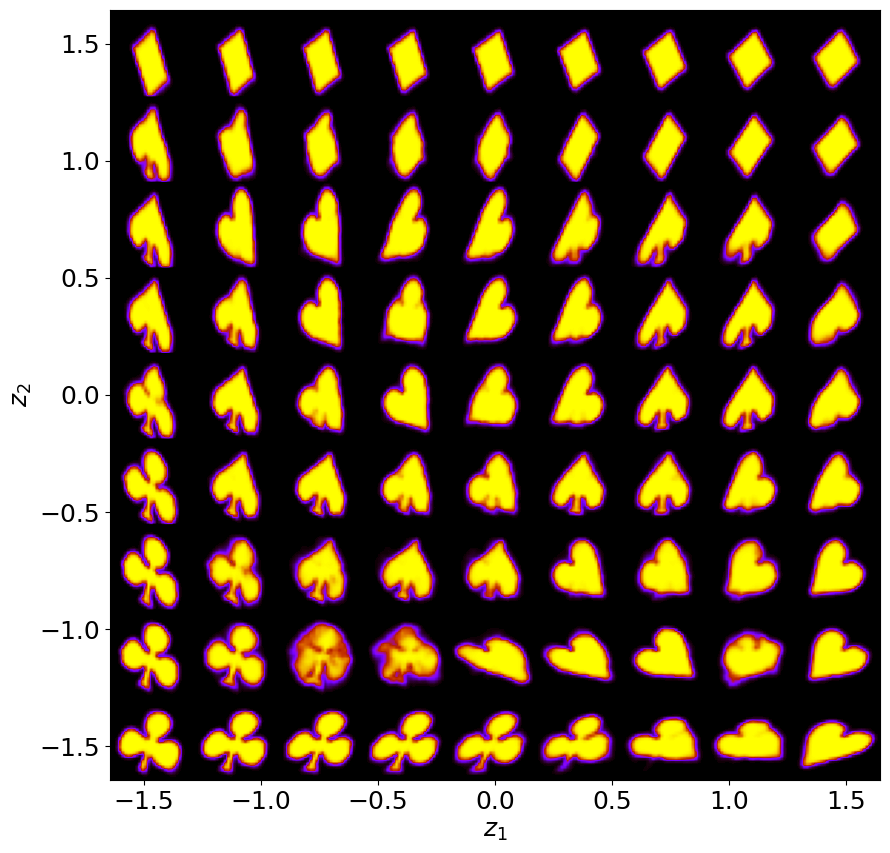

In [ ]:
# Latent representation
rvae.manifold2d(d = 9, origin = 'upper');

Text(0, 0.5, 'actual')

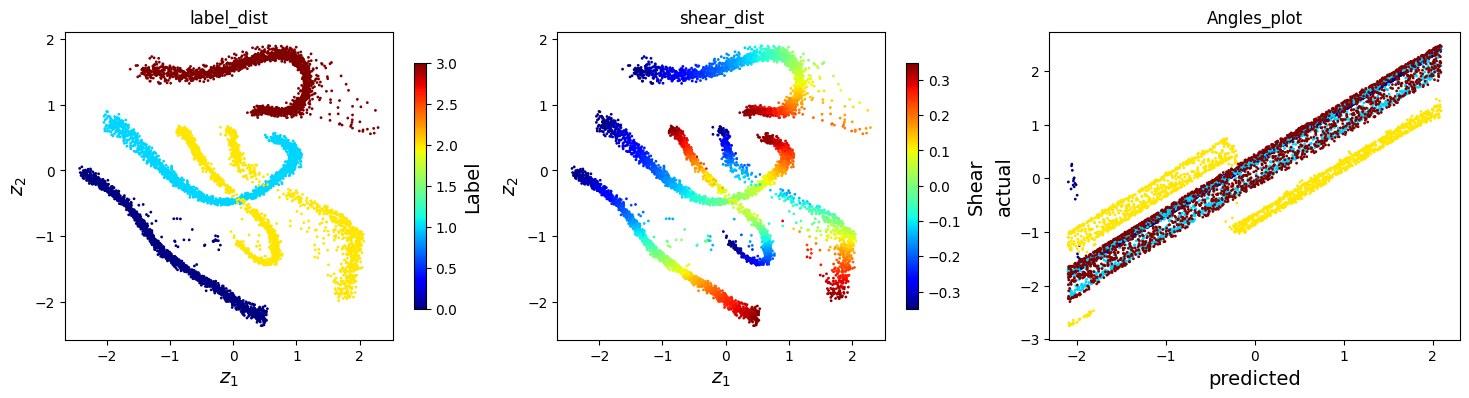

In [ ]:
# Latent distributions
z_mean, z_sd = rvae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=1, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

ax[2].scatter(torch.deg2rad(angles_all), z_mean[:,0], c = labels_all, s =1, cmap = 'jet')
ax[2].set_title('Angles_plot')
ax[2].set_xlabel("predicted", fontsize=14)
ax[2].set_ylabel("actual", fontsize=14)

In this case, we see well-defined manifolds for different hands, and the shear becomes a parameter that varies along the manifold. It is actually supercool - the VAE basically discovers factors of variability that we used in construction of the original data set (which it of course does not know - it's unsupervised method, and we have not used targets during analysis). This however is not perfect:
 - imaging that colors disappear - will you be able to cluster the data?
 - what about introducing some linear parameter changing across the manifold? Would it be shear?

 rVAE gives us some hints on what are the trends within the data set, but it does not tell us what they are explicitly. Its up to us to discover. 

# DKL on cards dataset

Here we explore the DKL as an active learning method to explore the card set. We want to learn the function f(image) -> hand, or f(image) -> (rotation or shear) in th escenario where all images are available, but the function values are becoming available one by one. However, the algorithm can suggest which feature it wants to query (i.e. which experiment it wants to run). This a fairly abstract setting, but it matches a lot of practical process optimization problem (substitute image by the process trajectory, molecular graph, etc). 

Again, we are running the DKL as an acrtive learning process - meaning that all the features are available (or equivalently our search space is defined), whereas targets are becoming available sequentially, meaning we are running (expensive) experiments. 

We should also define several useful variables, namely, the number of initial samples (for active learning), number of exploration steps, batch size for active learning (should be smaller then number of initial samples, or code will not work), and batch size for reconstructions. Parenthetically, batch size can be variable (so we can increase it when samples are becoming available).

In [ ]:
init_num = 20
exp_step = 100
batch_size_learn = 10 #make it 100 if start with 100 seed
batch_size_reconstruct = 250 

Note that the number of the initial seeds (20) and exploration steps (100) is very small compared to the full data set (2000). We start with 1% of available data and explore only 5% of available space - and this is for th esystem with storng variability. The reason we are interested in this is because experimental budgets are usually very limited - each experiment costs us time and money. 

If interested, you can experiment with the even smaller number of seed and exploration points. The DKL actually behaves remarcably well!

# Single card hand as a function

First, we run the experiment when we try to learn the hands in active manner. Meaning that we care about one specific hand (say clubs), do not care about other three hands, and do not care about the rotations and shear. 

## Clubs

In [ ]:
X = np.asarray(cards_all).reshape([-1, 900])

First we will run the DKL on the whole dataset. Here, we have (not terribly useful) situation when all features and all targets are available. So this is effectively supervised learning. The reason we are doing it first is to see how do the latent manfolds look like - and compare them to VAE. Rememebr that:
 - VAE build manifolds based on the features only
 - DKL on full data set builds manifolds based on features and targets 
 - Active learning DKL build manifolds in such a way as to accelerate discovery process 

In [ ]:
X0 = np.copy(X)
targets0 = np.zeros(len(labels_all))
targets0[labels_all == 0] = 1

rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()
dkl_0 = gpax.viDKL(900, 2, 'RBF')
dkl_0.fit(rng_key_0, X0, targets0)

100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s, init loss: 69238.9800, avg. loss [951-1000]: 45673.8466]



Inferred GP kernel parameters
k_length         [2.2607 1.6974]
k_scale          0.2805
noise            0.0082


Now can visualize the DKL Latent space with the ground truth labels. Here, it is very instructive to compare it with the VAE latent space. Unsurprisingly, this latent space is much better separated - because we use both features and (all) known targets. The reason why DKL works for active learning is that this structure can be learned with much fewer examples. 

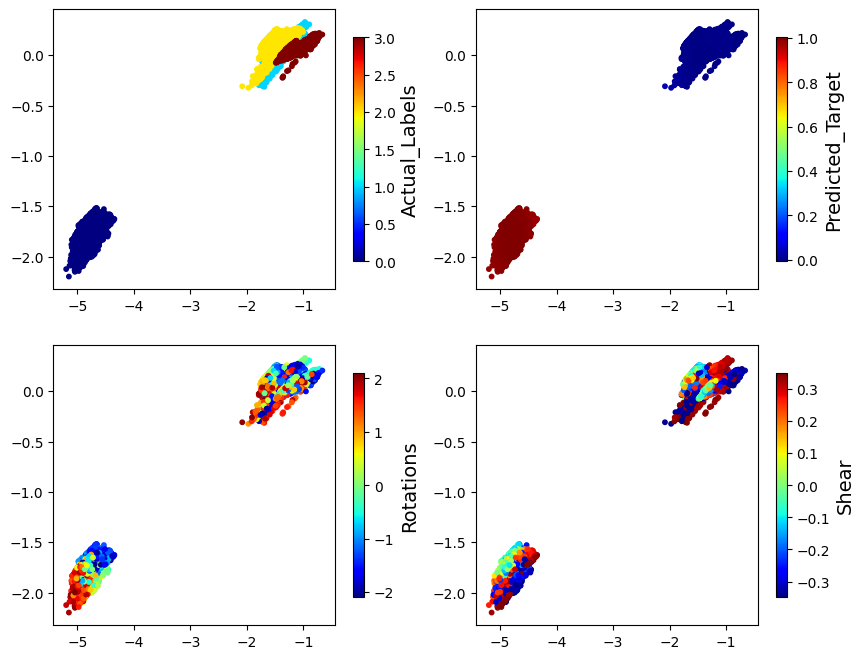

In [ ]:
embeded_0 = dkl_0.embed(X0)
pred_mean0, pred_var0 = dkl_0.predict_in_batches(rng_key_predict_0, X0, batch_size=batch_size_reconstruct)
pred_std0 = jnp.sqrt(pred_var0)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))


im = ax[0,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = pred_mean0, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

For this example, you can see that:
- Latent manifold is effectively 1D (meaning only one factor of variability matters). Compare to VAE, where 2D is not enough
- The clubs form their own group (this is what we wanted to learn), and other hands are all lumped together (so manifold evolved to learn what we wanted to focus on)
- Other factors of variability are not separated very well (if you look at data carefully, there will be some alignment along the manifold)

Overall, we wanted to focus on a particular feature - and we did!

Now, let's run the DKL as an active learning problem. Can we learn this manifold with much fewer examples?
- We will use 20 seed points and 100 exploration points. 
- As an aquisition function, we use the upper confidence bound, UCB, function defined as acq_func = mu + 10 * sigma, where mu is predicted value and sigma is uncertainty
- Look for the previous tutorial on Bayesian Optimization for at length discussion of these 

In [ ]:
np.random.seed(0)
idx0 = np.random.choice(np.arange(len(X0)), size = init_num, replace = False)
X0_train = X0[idx0]
X0_unmeasured = np.delete(X0, idx0, axis=0)

indices_total_0 = np.arange(len(X))
indices_train_0 = indices_total_0[idx0]
y0_train = targets0[idx0]
indices_unmeasured_0 = np.delete(indices_total_0, idx0)

In [ ]:
exp_mean0, exp_std0 = [], []
dkl_mean0, dkl_std0 = [], []
embed_traj0 = []
traj_mean0, traj_std0 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key10, rng_key_predict10 = gpax.utils.get_keys()
    dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_0.fit(rng_key10, X0_train, y0_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean0.append(y_mean[id_next])
    exp_std0.append(y_std[id_next])
    
    x_next = X0_unmeasured[id_next]
    ind_next = indices_unmeasured_0[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean0.append(pred_mean0[ind_next])
    dkl_std0.append(pred_std0[ind_next])
    
    # For now we will only read out the brute force results
    y_measured = targets0[ind_next]
    
    # Update training arrays
    X0_train = np.append(X0_train, x_next[None], axis=0)
    y0_train = np.append(y0_train, y_measured)
    X0_unmeasured = np.delete(X0_unmeasured, id_next, axis=0)
    indices_unmeasured_0 = np.delete(indices_unmeasured_0, id_next)
    
    embed_traj = dkl_BO_0.embed(X0_train)
    traj_m, traj_s = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_train, batch_size=batch_size_learn) 
    
    embed_traj0.append(embed_traj)
    traj_mean0.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 439.47it/s, init loss: 60101.2042, avg. loss [951-1000]: 56938.6287]



Inferred GP kernel parameters
k_length         [0.4181 0.3588]
k_scale          0.35600000000000004
noise            0.016300000000000002

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 421.51it/s, init loss: 60102.7093, avg. loss [951-1000]: 56923.2764]



Inferred GP kernel parameters
k_length         [0.3679 0.3492]
k_scale          0.39880000000000004
noise            0.0126

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 426.17it/s, init loss: 60104.1906, avg. loss [951-1000]: 56920.3021]



Inferred GP kernel parameters
k_length         [0.3682 0.3376]
k_scale          0.4127
noise            0.0123

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 416.84it/s, init loss: 60105.4347, avg. loss [951-1000]: 56918.4845]



Inferred GP kernel parameters
k_length         [0.3679 0.3232]
k_scale          0.4303
noise            0.011600000000000001

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 432.13it/s, init loss: 60106.9398, avg. loss [951-1000]: 56917.4530]



Inferred GP kernel parameters
k_length         [0.3679 0.3304]
k_scale          0.42400000000000004
noise            0.0111

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 408.47it/s, init loss: 60108.1830, avg. loss [951-1000]: 56919.6331]



Inferred GP kernel parameters
k_length         [0.3677 0.3082]
k_scale          0.5226000000000001
noise            0.0117

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 399.25it/s, init loss: 60109.4264, avg. loss [951-1000]: 56914.7765]



Inferred GP kernel parameters
k_length         [0.3679 0.3201]
k_scale          0.4279
noise            0.0112

Step 8


100%|██████████| 1000/1000 [00:03<00:00, 326.33it/s, init loss: 60110.9242, avg. loss [951-1000]: 56913.0303]



Inferred GP kernel parameters
k_length         [0.3679 0.3262]
k_scale          0.42750000000000005
noise            0.0106

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 406.58it/s, init loss: 60112.4293, avg. loss [951-1000]: 56911.9629]



Inferred GP kernel parameters
k_length         [0.3677 0.2741]
k_scale          0.43570000000000003
noise            0.0108

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 377.48it/s, init loss: 60113.9321, avg. loss [951-1000]: 56935.3361]



Inferred GP kernel parameters
k_length         [0.6375 0.4289]
k_scale          0.4097
noise            0.024800000000000003

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 402.77it/s, init loss: 60115.1763, avg. loss [951-1000]: 56975.7003]



Inferred GP kernel parameters
k_length         [0.5362 0.4567]
k_scale          0.2798
noise            0.0219

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 400.08it/s, init loss: 60116.4206, avg. loss [951-1000]: 56915.7462]



Inferred GP kernel parameters
k_length         [0.3592 0.3221]
k_scale          0.4163
noise            0.011600000000000001

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 355.16it/s, init loss: 60117.8420, avg. loss [951-1000]: 56907.0478]



Inferred GP kernel parameters
k_length         [0.371  0.3988]
k_scale          0.4091
noise            0.0102

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 423.43it/s, init loss: 60119.3472, avg. loss [951-1000]: 56904.5837]



Inferred GP kernel parameters
k_length         [0.3137 0.3679]
k_scale          0.4263
noise            0.0095

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 428.83it/s, init loss: 60120.8458, avg. loss [951-1000]: 56913.4674]



Inferred GP kernel parameters
k_length         [0.376  0.3589]
k_scale          0.3486
noise            0.011000000000000001

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 425.39it/s, init loss: 60122.0897, avg. loss [951-1000]: 56940.9988]



Inferred GP kernel parameters
k_length         [0.4179 0.3543]
k_scale          0.38180000000000003
noise            0.0117

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 430.45it/s, init loss: 60123.3330, avg. loss [951-1000]: 56901.4981]



Inferred GP kernel parameters
k_length         [0.368 0.341]
k_scale          0.42060000000000003
noise            0.0095

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 421.00it/s, init loss: 60124.8381, avg. loss [951-1000]: 56898.8590]



Inferred GP kernel parameters
k_length         [0.3679 0.3349]
k_scale          0.4287
noise            0.009300000000000001

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 422.08it/s, init loss: 60126.3400, avg. loss [951-1000]: 56898.6083]



Inferred GP kernel parameters
k_length         [0.3827 0.3879]
k_scale          0.39330000000000004
noise            0.009600000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 430.79it/s, init loss: 60127.8450, avg. loss [951-1000]: 56896.5645]



Inferred GP kernel parameters
k_length         [0.3679 0.3388]
k_scale          0.4208
noise            0.009300000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 405.67it/s, init loss: 60129.1198, avg. loss [951-1000]: 56894.8266]



Inferred GP kernel parameters
k_length         [0.3072 0.3679]
k_scale          0.40740000000000004
noise            0.009000000000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 426.65it/s, init loss: 60130.3596, avg. loss [951-1000]: 56893.1839]



Inferred GP kernel parameters
k_length         [0.3269 0.365 ]
k_scale          0.4219
noise            0.0088

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 415.08it/s, init loss: 60131.6903, avg. loss [951-1000]: 56896.1184]



Inferred GP kernel parameters
k_length         [0.3493 0.3681]
k_scale          0.35500000000000004
noise            0.0095

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 416.37it/s, init loss: 60133.1855, avg. loss [951-1000]: 56893.4725]



Inferred GP kernel parameters
k_length         [0.3735 0.3633]
k_scale          0.39590000000000003
noise            0.0098

Step 25


100%|██████████| 1000/1000 [00:03<00:00, 325.54it/s, init loss: 60134.6753, avg. loss [951-1000]: 56888.7280]



Inferred GP kernel parameters
k_length         [0.3678 0.3168]
k_scale          0.42410000000000003
noise            0.008700000000000001

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 434.42it/s, init loss: 60136.1804, avg. loss [951-1000]: 56893.6480]



Inferred GP kernel parameters
k_length         [0.363  0.3693]
k_scale          0.314
noise            0.0098

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 411.17it/s, init loss: 60137.4243, avg. loss [951-1000]: 56892.7534]



Inferred GP kernel parameters
k_length         [0.3629 0.3143]
k_scale          0.5167
noise            0.0098

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 426.32it/s, init loss: 60138.5988, avg. loss [951-1000]: 56885.9420]



Inferred GP kernel parameters
k_length         [0.3428 0.3297]
k_scale          0.42600000000000005
noise            0.0091

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 403.46it/s, init loss: 60140.0257, avg. loss [951-1000]: 56882.8273]



Inferred GP kernel parameters
k_length         [0.3142 0.3679]
k_scale          0.42460000000000003
noise            0.008400000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 421.40it/s, init loss: 60141.4441, avg. loss [951-1000]: 56886.5362]



Inferred GP kernel parameters
k_length         [0.3815 0.3882]
k_scale          0.3513
noise            0.009000000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 401.49it/s, init loss: 60142.6668, avg. loss [951-1000]: 56925.8443]



Inferred GP kernel parameters
k_length         [0.5833 0.3888]
k_scale          0.375
noise            0.012400000000000001

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 418.21it/s, init loss: 60144.1707, avg. loss [951-1000]: 56879.3830]



Inferred GP kernel parameters
k_length         [0.3679 0.3222]
k_scale          0.41300000000000003
noise            0.008700000000000001

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 416.18it/s, init loss: 60145.6397, avg. loss [951-1000]: 56892.4543]



Inferred GP kernel parameters
k_length         [0.3701 0.3337]
k_scale          0.3835
noise            0.0112

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 396.34it/s, init loss: 60147.0934, avg. loss [951-1000]: 56877.6632]



Inferred GP kernel parameters
k_length         [0.3742 0.3349]
k_scale          0.40840000000000004
noise            0.008700000000000001

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 419.00it/s, init loss: 60148.5981, avg. loss [951-1000]: 56878.0012]



Inferred GP kernel parameters
k_length         [0.3746 0.361 ]
k_scale          0.4067
noise            0.008700000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 398.51it/s, init loss: 60150.1033, avg. loss [951-1000]: 56890.9457]



Inferred GP kernel parameters
k_length         [0.3894 0.4305]
k_scale          0.3789
noise            0.009300000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 417.65it/s, init loss: 60151.6083, avg. loss [951-1000]: 56874.8295]



Inferred GP kernel parameters
k_length         [0.3425 0.3511]
k_scale          0.3624
noise            0.0089

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 393.69it/s, init loss: 60153.1134, avg. loss [951-1000]: 56879.5071]



Inferred GP kernel parameters
k_length         [0.431  0.3917]
k_scale          0.3144
noise            0.0094

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 415.36it/s, init loss: 60154.3464, avg. loss [951-1000]: 56868.6408]



Inferred GP kernel parameters
k_length         [0.3679 0.3173]
k_scale          0.4217
noise            0.0083

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 395.78it/s, init loss: 60155.8515, avg. loss [951-1000]: 56868.4274]



Inferred GP kernel parameters
k_length         [0.3522 0.3673]
k_scale          0.4168
noise            0.0086

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 409.29it/s, init loss: 60157.3448, avg. loss [951-1000]: 56900.1571]



Inferred GP kernel parameters
k_length         [0.5037 0.3687]
k_scale          0.3191
noise            0.009000000000000001

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 415.52it/s, init loss: 60158.8499, avg. loss [951-1000]: 56874.1817]



Inferred GP kernel parameters
k_length         [0.4079 0.3683]
k_scale          0.3287
noise            0.0094

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 389.71it/s, init loss: 60160.2762, avg. loss [951-1000]: 56874.9944]



Inferred GP kernel parameters
k_length         [0.5315 0.562 ]
k_scale          0.301
noise            0.0099

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 403.49it/s, init loss: 60161.5196, avg. loss [951-1000]: 56867.6871]



Inferred GP kernel parameters
k_length         [0.363  0.3632]
k_scale          0.3395
noise            0.0089

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 378.34it/s, init loss: 60162.7610, avg. loss [951-1000]: 56973.6295]



Inferred GP kernel parameters
k_length         [0.4277 0.4712]
k_scale          0.3123
noise            0.0115

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 392.66it/s, init loss: 60164.2661, avg. loss [951-1000]: 56861.4455]



Inferred GP kernel parameters
k_length         [0.3775 0.3394]
k_scale          0.4248
noise            0.0089

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 399.09it/s, init loss: 60165.6680, avg. loss [951-1000]: 56857.6178]



Inferred GP kernel parameters
k_length         [0.336  0.3658]
k_scale          0.4176
noise            0.008400000000000001

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 420.25it/s, init loss: 60166.9109, avg. loss [951-1000]: 57008.1456]



Inferred GP kernel parameters
k_length         [0.4841 0.5417]
k_scale          0.3395
noise            0.0123

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 419.51it/s, init loss: 60168.4051, avg. loss [951-1000]: 56858.5020]



Inferred GP kernel parameters
k_length         [0.3449 0.3731]
k_scale          0.4006
noise            0.0088

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 414.28it/s, init loss: 60169.6371, avg. loss [951-1000]: 56852.8355]



Inferred GP kernel parameters
k_length         [0.3668 0.3242]
k_scale          0.4212
noise            0.008

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 420.81it/s, init loss: 60171.0872, avg. loss [951-1000]: 56863.5843]



Inferred GP kernel parameters
k_length         [0.4023 0.3767]
k_scale          0.3382
noise            0.0088

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 417.76it/s, init loss: 60172.5923, avg. loss [951-1000]: 56869.0498]



Inferred GP kernel parameters
k_length         [0.5188 0.4276]
k_scale          0.3272
noise            0.0103

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 422.35it/s, init loss: 60174.0622, avg. loss [951-1000]: 56890.5021]



Inferred GP kernel parameters
k_length         [0.4447 0.439 ]
k_scale          0.3306
noise            0.0095

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 408.68it/s, init loss: 60175.3802, avg. loss [951-1000]: 56850.9050]



Inferred GP kernel parameters
k_length         [0.3728 0.377 ]
k_scale          0.3875
noise            0.009000000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 417.24it/s, init loss: 60176.6766, avg. loss [951-1000]: 56859.2050]



Inferred GP kernel parameters
k_length         [0.4256 0.4096]
k_scale          0.2909
noise            0.008700000000000001

Step 56


100%|██████████| 1000/1000 [00:03<00:00, 298.80it/s, init loss: 60177.9144, avg. loss [951-1000]: 56856.4894]



Inferred GP kernel parameters
k_length         [0.3663 0.3977]
k_scale          0.32780000000000004
noise            0.0086

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 416.52it/s, init loss: 60179.3344, avg. loss [951-1000]: 56880.9701]



Inferred GP kernel parameters
k_length         [0.4172 0.4916]
k_scale          0.3351
noise            0.0103

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 429.51it/s, init loss: 60180.5461, avg. loss [951-1000]: 56844.6149]



Inferred GP kernel parameters
k_length         [0.4546 0.4173]
k_scale          0.4067
noise            0.008700000000000001

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 424.00it/s, init loss: 60181.8972, avg. loss [951-1000]: 56857.8609]



Inferred GP kernel parameters
k_length         [0.3936 0.3645]
k_scale          0.3279
noise            0.009000000000000001

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 436.74it/s, init loss: 60183.1841, avg. loss [951-1000]: 56870.5935]



Inferred GP kernel parameters
k_length         [0.6347 0.7246]
k_scale          0.2821
noise            0.0131

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 422.22it/s, init loss: 60184.5208, avg. loss [951-1000]: 56902.2657]



Inferred GP kernel parameters
k_length         [0.5019 0.4939]
k_scale          0.3794
noise            0.010100000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 418.22it/s, init loss: 60185.7730, avg. loss [951-1000]: 56838.0012]



Inferred GP kernel parameters
k_length         [0.4464 0.3997]
k_scale          0.3951
noise            0.0085

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 433.68it/s, init loss: 60187.2777, avg. loss [951-1000]: 56845.4957]



Inferred GP kernel parameters
k_length         [0.4033 0.4323]
k_scale          0.314
noise            0.0089

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 408.75it/s, init loss: 60188.5508, avg. loss [951-1000]: 56839.1885]



Inferred GP kernel parameters
k_length         [0.3691 0.3143]
k_scale          0.3436
noise            0.008

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 410.02it/s, init loss: 60190.0153, avg. loss [951-1000]: 56830.4597]



Inferred GP kernel parameters
k_length         [0.3677 0.3366]
k_scale          0.42110000000000003
noise            0.0079

Step 66


100%|██████████| 1000/1000 [00:03<00:00, 279.48it/s, init loss: 60191.4946, avg. loss [951-1000]: 56915.0142]



Inferred GP kernel parameters
k_length         [0.2679 0.3221]
k_scale          0.4829
noise            0.010100000000000001

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 414.90it/s, init loss: 60192.9996, avg. loss [951-1000]: 56844.2575]



Inferred GP kernel parameters
k_length         [0.4796 0.4351]
k_scale          0.2907
noise            0.009300000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 420.06it/s, init loss: 60194.5011, avg. loss [951-1000]: 56863.4877]



Inferred GP kernel parameters
k_length         [0.319  0.3524]
k_scale          0.34990000000000004
noise            0.009000000000000001

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 411.32it/s, init loss: 60195.7464, avg. loss [951-1000]: 56836.7932]



Inferred GP kernel parameters
k_length         [0.3873 0.3733]
k_scale          0.317
noise            0.0091

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 412.76it/s, init loss: 60197.2126, avg. loss [951-1000]: 56831.0424]



Inferred GP kernel parameters
k_length         [0.4417 0.4379]
k_scale          0.382
noise            0.008400000000000001

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 412.92it/s, init loss: 60198.7177, avg. loss [951-1000]: 56824.6652]



Inferred GP kernel parameters
k_length         [0.3855 0.39  ]
k_scale          0.4086
noise            0.0083

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 418.97it/s, init loss: 60200.1868, avg. loss [951-1000]: 56823.2396]



Inferred GP kernel parameters
k_length         [0.3702 0.3549]
k_scale          0.42260000000000003
noise            0.0082

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 408.66it/s, init loss: 60201.6774, avg. loss [951-1000]: 56822.3166]



Inferred GP kernel parameters
k_length         [0.3588 0.3748]
k_scale          0.4025
noise            0.0082

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 400.03it/s, init loss: 60202.9217, avg. loss [951-1000]: 56843.4668]



Inferred GP kernel parameters
k_length         [0.5728 0.5702]
k_scale          0.335
noise            0.01

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 413.23it/s, init loss: 60204.3885, avg. loss [951-1000]: 56817.4634]



Inferred GP kernel parameters
k_length         [0.3425 0.3735]
k_scale          0.4194
noise            0.008

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 405.01it/s, init loss: 60205.6248, avg. loss [951-1000]: 56866.9854]



Inferred GP kernel parameters
k_length         [0.4228 0.5889]
k_scale          0.327
noise            0.0109

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 414.58it/s, init loss: 60207.1130, avg. loss [951-1000]: 56886.8375]



Inferred GP kernel parameters
k_length         [0.3741 0.3505]
k_scale          0.3652
noise            0.0108

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 405.05it/s, init loss: 60208.5896, avg. loss [951-1000]: 56845.2740]



Inferred GP kernel parameters
k_length         [0.5617 0.4963]
k_scale          0.2696
noise            0.0111

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 400.91it/s, init loss: 60209.9870, avg. loss [951-1000]: 56811.7055]



Inferred GP kernel parameters
k_length         [0.3923 0.3625]
k_scale          0.4169
noise            0.008

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 417.09it/s, init loss: 60211.3463, avg. loss [951-1000]: 56827.5522]



Inferred GP kernel parameters
k_length         [0.6273 0.4422]
k_scale          0.312
noise            0.0097

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 395.21it/s, init loss: 60212.5849, avg. loss [951-1000]: 56839.8769]



Inferred GP kernel parameters
k_length         [0.3947 0.4145]
k_scale          0.2975
noise            0.0089

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 419.77it/s, init loss: 60214.0920, avg. loss [951-1000]: 56811.6592]



Inferred GP kernel parameters
k_length         [0.407 0.392]
k_scale          0.334
noise            0.0083

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 411.16it/s, init loss: 60215.4371, avg. loss [951-1000]: 56843.2440]



Inferred GP kernel parameters
k_length         [0.4165 0.4031]
k_scale          0.2857
noise            0.009000000000000001

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 426.68it/s, init loss: 60216.6814, avg. loss [951-1000]: 56814.8886]



Inferred GP kernel parameters
k_length         [0.5229 0.4854]
k_scale          0.28800000000000003
noise            0.008700000000000001

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 419.11it/s, init loss: 60217.9570, avg. loss [951-1000]: 56818.2518]



Inferred GP kernel parameters
k_length         [0.3938 0.3824]
k_scale          0.309
noise            0.0083

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 411.45it/s, init loss: 60219.4421, avg. loss [951-1000]: 56814.8491]



Inferred GP kernel parameters
k_length         [0.4159 0.3966]
k_scale          0.2993
noise            0.0085

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 420.75it/s, init loss: 60220.9397, avg. loss [951-1000]: 56946.8539]



Inferred GP kernel parameters
k_length         [0.5973 0.5893]
k_scale          0.2893
noise            0.0128

Step 88


100%|██████████| 1000/1000 [00:03<00:00, 253.64it/s, init loss: 60222.1534, avg. loss [951-1000]: 56803.4859]



Inferred GP kernel parameters
k_length         [0.4106 0.4315]
k_scale          0.40280000000000005
noise            0.0086

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 422.27it/s, init loss: 60223.6275, avg. loss [951-1000]: 56827.1868]



Inferred GP kernel parameters
k_length         [0.7534 0.7125]
k_scale          0.2348
noise            0.0099

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 410.02it/s, init loss: 60225.0010, avg. loss [951-1000]: 56833.1020]



Inferred GP kernel parameters
k_length         [0.3678 0.3769]
k_scale          0.3679
noise            0.009000000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 422.99it/s, init loss: 60226.2520, avg. loss [951-1000]: 56802.6206]



Inferred GP kernel parameters
k_length         [0.3963 0.3763]
k_scale          0.3491
noise            0.008400000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 418.52it/s, init loss: 60227.5887, avg. loss [951-1000]: 56814.2643]



Inferred GP kernel parameters
k_length         [0.7572 0.8387]
k_scale          0.2429
noise            0.0095

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 408.71it/s, init loss: 60229.0314, avg. loss [951-1000]: 56837.6518]



Inferred GP kernel parameters
k_length         [0.5825 0.5886]
k_scale          0.2378
noise            0.0098

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 414.11it/s, init loss: 60230.3221, avg. loss [951-1000]: 56789.5704]



Inferred GP kernel parameters
k_length         [0.3955 0.3887]
k_scale          0.4107
noise            0.0079

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 392.77it/s, init loss: 60231.5571, avg. loss [951-1000]: 56803.2627]



Inferred GP kernel parameters
k_length         [0.3848 0.4079]
k_scale          0.38430000000000003
noise            0.0086

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 415.05it/s, init loss: 60232.8014, avg. loss [951-1000]: 56799.6448]



Inferred GP kernel parameters
k_length         [0.4778 0.4465]
k_scale          0.3331
noise            0.009300000000000001

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 409.54it/s, init loss: 60234.1139, avg. loss [951-1000]: 56790.9514]



Inferred GP kernel parameters
k_length         [0.4057 0.4317]
k_scale          0.3845
noise            0.008700000000000001

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 399.89it/s, init loss: 60235.5390, avg. loss [951-1000]: 56863.5221]



Inferred GP kernel parameters
k_length         [0.4491 0.4214]
k_scale          0.3247
noise            0.0095

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 415.45it/s, init loss: 60236.9522, avg. loss [951-1000]: 56909.3206]



Inferred GP kernel parameters
k_length         [0.3232 0.2904]
k_scale          0.5477000000000001
noise            0.0095

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 399.47it/s, init loss: 60238.2826, avg. loss [951-1000]: 56800.7755]



Inferred GP kernel parameters
k_length         [0.387  0.4157]
k_scale          0.2994
noise            0.0091


In [ ]:
# Saving the results
clubs_results = {}
clubs_results['X_train'] = X0_train
clubs_results['y_train'] = y0_train
clubs_results['X_unmeasured'] = X0_unmeasured
clubs_results['indices_unmeasured'] = indices_unmeasured_0
clubs_results['dkl_mean'] = dkl_mean0
clubs_results['dkl_std'] = dkl_std0
clubs_results['exp_mean'] = exp_mean0
clubs_results['exp_std'] = exp_std0
clubs_results['traj_mean'] = traj_mean0
clubs_results['traj_std'] = traj_std0
clubs_results['embed_traj'] = embed_traj0

with open('clubs_results.pickle', 'wb') as handle:
    pickle.dump(clubs_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading the results
with open('clubs_results.pickle', 'rb') as f:
    clubs_results = pickle.load(f)

X0_train = clubs_results['X_train']
y0_train = clubs_results['y_train']
X0_unmeasured = clubs_results['X_unmeasured']
indices_unmeasured_0 = clubs_results['indices_unmeasured']
dkl_mean0 = clubs_results['dkl_mean']
dkl_std0 = clubs_results['dkl_std']
exp_mean0 = clubs_results['exp_mean'] 
exp_std0 = clubs_results['exp_std']
traj_mean0 = clubs_results['traj_mean']
traj_std0 = clubs_results['traj_std']
embed_traj0 = clubs_results['embed_traj']

In [ ]:
rng_key10, rng_key_predict10 = gpax.utils.get_keys()
dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_0.fit(rng_key10, X0_train, y0_train)

predmean_train0, predstd_train0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_train, batch_size = batch_size_learn)
predmean_unmeas0, predstd_unmeas0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_unmeasured, batch_size = batch_size_reconstruct)
predmean10, predstd10 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0, batch_size = batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 403.14it/s, init loss: 60239.7877, avg. loss [951-1000]: 56803.5427]



Inferred GP kernel parameters
k_length         [0.6454 0.627 ]
k_scale          0.23850000000000002
noise            0.0099


The first row corresponds to explored, unexplored, and all datapoints colored using the predicted target property  
Second row is the latent space distributions colored with various ground truths

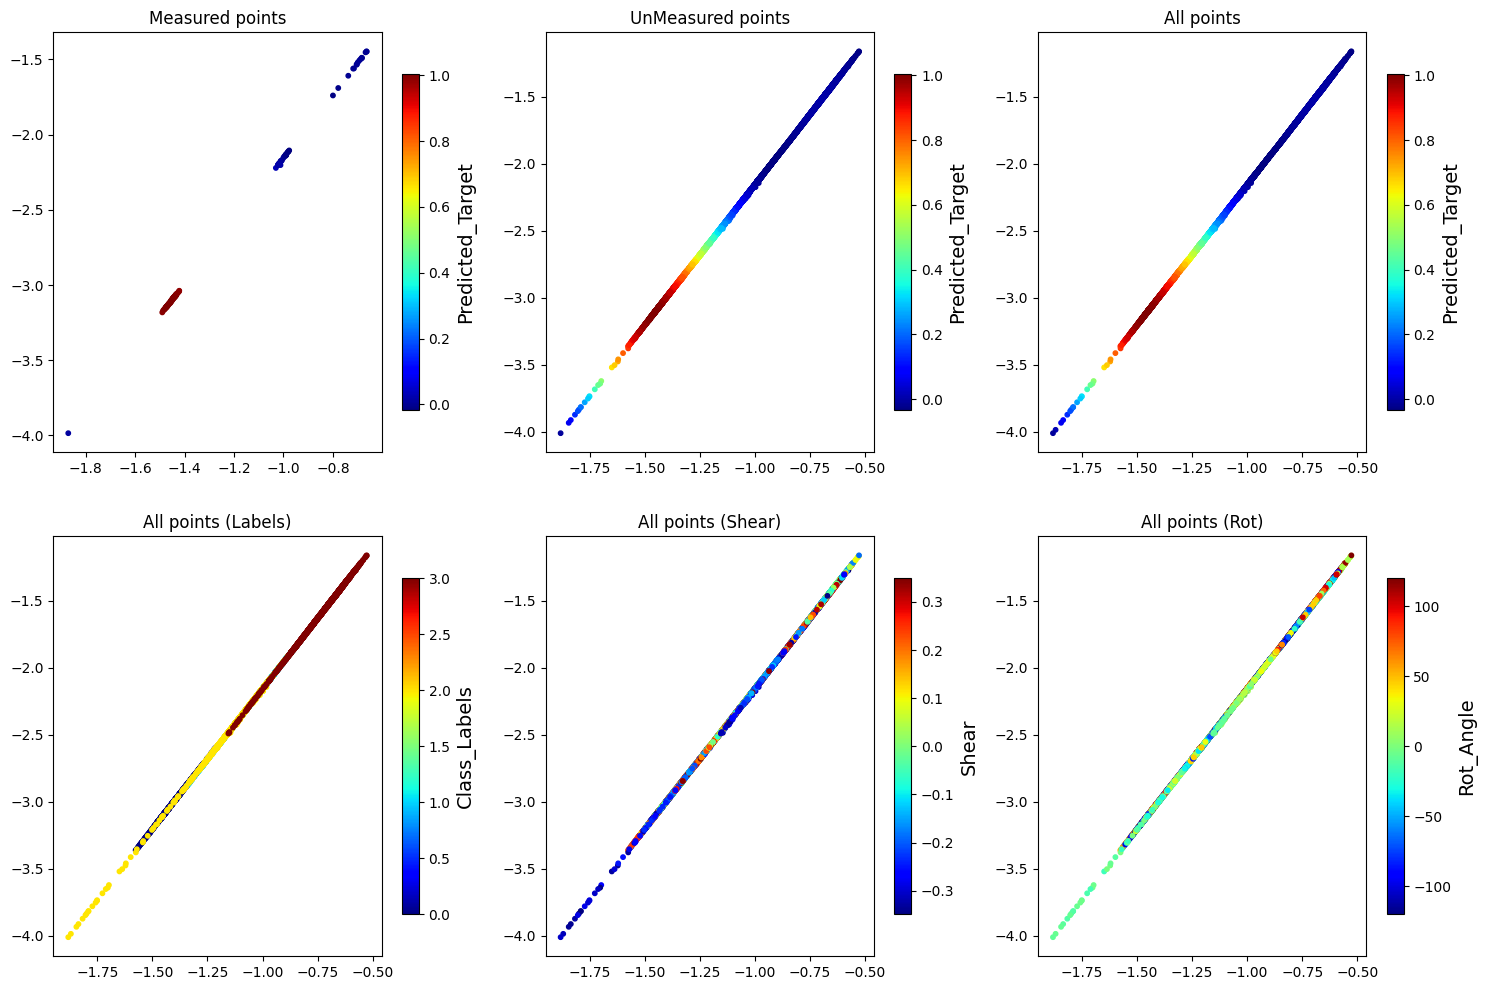

In [ ]:
embeded_train0 = dkl_BO_0.embed(X0_train)  # Measured points
embeded_unmeasured0 = dkl_BO_0.embed(X0_unmeasured)  # Unmeasured points
embeded10 = dkl_BO_0.embed(X0)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train0[:, 1], embeded_train0[:, 0], s=10, c = predmean_train0, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured0[:, 1], embeded_unmeasured0[:, 0], s=10,
                c = predmean_unmeas0, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = predmean10, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note that we discovered the right manifold with much smaller number of points. Now the "hand" is a continuous function (again, we use cards as a model for more complex processes, so we assume that it is an ordinal variable)

## Spades

Now, let's try the same analysis for spades. 

In [ ]:
X1 = np.copy(X)
targets1 = np.zeros(len(labels_all))
targets1[labels_all == 1] = 1

rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(900, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

100%|██████████| 1000/1000 [06:59<00:00,  2.39it/s, init loss: 69263.1582, avg. loss [951-1000]: 45723.1047]



Inferred GP kernel parameters
k_length         [4.1831 3.0056]
k_scale          0.1468
noise            0.0081


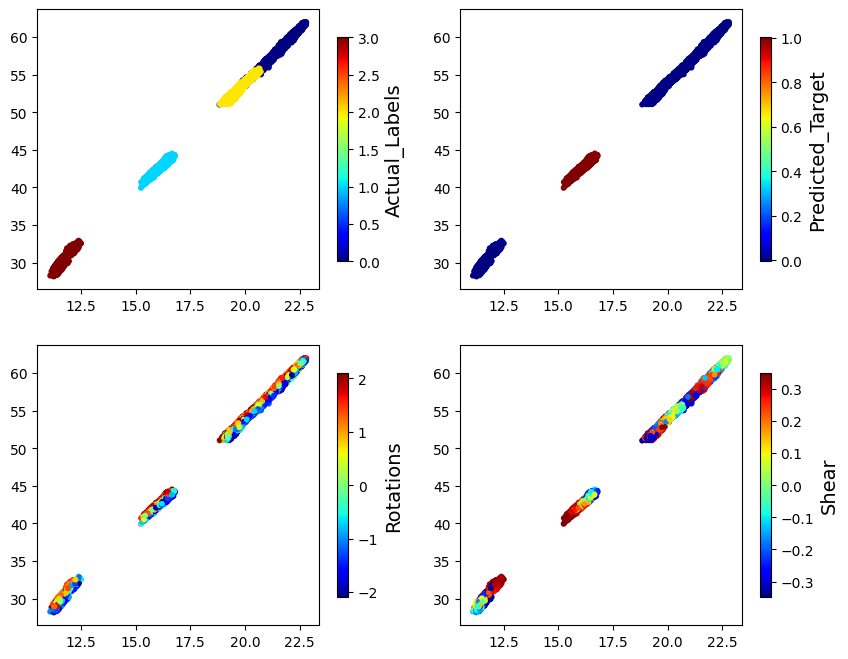

In [ ]:
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note that here our target is in the center of the DKL manifold. It will have interesting effect on the DKL active learning. Also interetsingly, you can see that rotations got disentangled within the DKL manifolds (and to some extent even shears). We would not see it if we did not have access to the full target set, but nice to know that DKL can also disentangle representations of the data!

In [ ]:
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]
y1_train = targets1[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

In [ ]:
exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = exploration_steps


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])
    
    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets1[ind_next]
    
    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)
    
    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=10)
    
    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 427.72it/s, init loss: 60100.9329, avg. loss [951-1000]: 56952.6547]



Inferred GP kernel parameters
k_length         [0.4296 0.4175]
k_scale          0.2899
noise            0.027600000000000003

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 433.23it/s, init loss: 60102.1760, avg. loss [951-1000]: 56926.0267]



Inferred GP kernel parameters
k_length         [0.3661 0.3298]
k_scale          0.5058
noise            0.0172

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 435.96it/s, init loss: 60103.6648, avg. loss [951-1000]: 56920.5383]



Inferred GP kernel parameters
k_length         [0.3678 0.3139]
k_scale          0.4071
noise            0.0123

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 441.01it/s, init loss: 60105.1688, avg. loss [951-1000]: 56935.3173]



Inferred GP kernel parameters
k_length         [0.4457 0.4116]
k_scale          0.4172
noise            0.0155

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 437.80it/s, init loss: 60106.6050, avg. loss [951-1000]: 56942.9382]



Inferred GP kernel parameters
k_length         [0.458  0.4967]
k_scale          0.37820000000000004
noise            0.0166

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 441.33it/s, init loss: 60107.8114, avg. loss [951-1000]: 56937.2218]



Inferred GP kernel parameters
k_length         [0.4064 0.3999]
k_scale          0.4202
noise            0.0245

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 428.96it/s, init loss: 60109.0557, avg. loss [951-1000]: 56933.5387]



Inferred GP kernel parameters
k_length         [0.4654 0.4932]
k_scale          0.373
noise            0.016

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 449.81it/s, init loss: 60110.2999, avg. loss [951-1000]: 56922.4840]



Inferred GP kernel parameters
k_length         [0.4104 0.4078]
k_scale          0.4178
noise            0.0151

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 428.92it/s, init loss: 60111.5442, avg. loss [951-1000]: 56949.1727]



Inferred GP kernel parameters
k_length         [0.3707 0.5289]
k_scale          0.38180000000000003
noise            0.0205

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 452.16it/s, init loss: 60112.7536, avg. loss [951-1000]: 56975.9973]



Inferred GP kernel parameters
k_length         [0.3641 0.2953]
k_scale          0.2805
noise            0.0217

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 440.53it/s, init loss: 60113.9979, avg. loss [951-1000]: 56976.6171]



Inferred GP kernel parameters
k_length         [0.2704 0.3768]
k_scale          0.2073
noise            0.0234

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 452.75it/s, init loss: 60115.2359, avg. loss [951-1000]: 56944.6880]



Inferred GP kernel parameters
k_length         [0.363  0.3808]
k_scale          0.2936
noise            0.0195

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 430.33it/s, init loss: 60116.7361, avg. loss [951-1000]: 56919.0086]



Inferred GP kernel parameters
k_length         [0.2338 0.3532]
k_scale          0.443
noise            0.011300000000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 449.13it/s, init loss: 60118.2412, avg. loss [951-1000]: 56916.7269]



Inferred GP kernel parameters
k_length         [0.3059 0.368 ]
k_scale          0.3856
noise            0.0128

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 439.84it/s, init loss: 60119.4181, avg. loss [951-1000]: 56916.5316]



Inferred GP kernel parameters
k_length         [0.3513 0.4156]
k_scale          0.4894
noise            0.013300000000000001

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 442.97it/s, init loss: 60120.6432, avg. loss [951-1000]: 56917.6301]



Inferred GP kernel parameters
k_length         [0.5029 0.431 ]
k_scale          0.43210000000000004
noise            0.0125

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 445.85it/s, init loss: 60121.8874, avg. loss [951-1000]: 56904.2527]



Inferred GP kernel parameters
k_length         [0.3744 0.3661]
k_scale          0.38620000000000004
noise            0.0108

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 465.08it/s, init loss: 60123.1317, avg. loss [951-1000]: 56933.7789]



Inferred GP kernel parameters
k_length         [0.3002 0.448 ]
k_scale          0.33290000000000003
noise            0.0171

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 439.09it/s, init loss: 60124.3759, avg. loss [951-1000]: 56951.3090]



Inferred GP kernel parameters
k_length         [0.3845 0.3064]
k_scale          0.335
noise            0.017

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 427.12it/s, init loss: 60125.6168, avg. loss [951-1000]: 56931.6055]



Inferred GP kernel parameters
k_length         [0.4352 0.3993]
k_scale          0.28190000000000004
noise            0.020300000000000002

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 434.89it/s, init loss: 60126.8611, avg. loss [951-1000]: 56934.5594]



Inferred GP kernel parameters
k_length         [0.3081 0.3937]
k_scale          0.3664
noise            0.020800000000000003

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 438.46it/s, init loss: 60128.1040, avg. loss [951-1000]: 56926.6987]



Inferred GP kernel parameters
k_length         [0.5362 0.5771]
k_scale          0.3902
noise            0.015600000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 456.75it/s, init loss: 60129.3483, avg. loss [951-1000]: 56970.3876]



Inferred GP kernel parameters
k_length         [0.3504 0.2531]
k_scale          0.27080000000000004
noise            0.0166

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 449.46it/s, init loss: 60130.5839, avg. loss [951-1000]: 56949.4039]



Inferred GP kernel parameters
k_length         [0.2741 0.2546]
k_scale          0.2892
noise            0.0137

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 441.40it/s, init loss: 60131.7874, avg. loss [951-1000]: 56925.5989]



Inferred GP kernel parameters
k_length         [0.3745 0.3745]
k_scale          0.42000000000000004
noise            0.0152

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 424.62it/s, init loss: 60132.9784, avg. loss [951-1000]: 56921.5010]



Inferred GP kernel parameters
k_length         [0.4681 0.4219]
k_scale          0.37120000000000003
noise            0.0132

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 453.39it/s, init loss: 60134.2219, avg. loss [951-1000]: 56936.2657]



Inferred GP kernel parameters
k_length         [0.5192 0.5189]
k_scale          0.32780000000000004
noise            0.015000000000000001

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 441.37it/s, init loss: 60135.4662, avg. loss [951-1000]: 56895.3461]



Inferred GP kernel parameters
k_length         [0.3486 0.3718]
k_scale          0.4348
noise            0.0106

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 443.26it/s, init loss: 60136.7104, avg. loss [951-1000]: 56913.3273]



Inferred GP kernel parameters
k_length         [0.6049 0.4715]
k_scale          0.3286
noise            0.014400000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 430.62it/s, init loss: 60137.9547, avg. loss [951-1000]: 56925.3244]



Inferred GP kernel parameters
k_length         [0.4969 0.5987]
k_scale          0.2948
noise            0.017

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 435.91it/s, init loss: 60139.4576, avg. loss [951-1000]: 56882.3617]



Inferred GP kernel parameters
k_length         [0.3645 0.3179]
k_scale          0.42300000000000004
noise            0.0091

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 433.39it/s, init loss: 60140.9552, avg. loss [951-1000]: 56888.3790]



Inferred GP kernel parameters
k_length         [0.4637 0.4573]
k_scale          0.48250000000000004
noise            0.0106

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 451.91it/s, init loss: 60142.1810, avg. loss [951-1000]: 56954.6246]



Inferred GP kernel parameters
k_length         [0.3392 0.2484]
k_scale          0.29500000000000004
noise            0.0117

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 446.26it/s, init loss: 60143.6621, avg. loss [951-1000]: 56908.0548]



Inferred GP kernel parameters
k_length         [0.4769 0.5079]
k_scale          0.309
noise            0.013900000000000001

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 462.55it/s, init loss: 60144.8816, avg. loss [951-1000]: 57012.4440]



Inferred GP kernel parameters
k_length         [0.2327 0.282 ]
k_scale          0.2109
noise            0.0152

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 424.95it/s, init loss: 60146.3853, avg. loss [951-1000]: 56927.5583]



Inferred GP kernel parameters
k_length         [0.5234 0.3774]
k_scale          0.3608
noise            0.013600000000000001

Step 37


100%|██████████| 1000/1000 [00:04<00:00, 248.25it/s, init loss: 60147.6296, avg. loss [951-1000]: 56876.4381]



Inferred GP kernel parameters
k_length         [0.3838 0.3608]
k_scale          0.3713
noise            0.009300000000000001

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 426.88it/s, init loss: 60148.8721, avg. loss [951-1000]: 56939.2170]



Inferred GP kernel parameters
k_length         [0.4311 0.4872]
k_scale          0.34690000000000004
noise            0.0155

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 452.60it/s, init loss: 60150.1164, avg. loss [951-1000]: 56918.1846]



Inferred GP kernel parameters
k_length         [0.258  0.2743]
k_scale          0.3806
noise            0.0102

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 431.34it/s, init loss: 60151.3603, avg. loss [951-1000]: 56911.4156]



Inferred GP kernel parameters
k_length         [0.6853 0.7267]
k_scale          0.2919
noise            0.0142

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 442.35it/s, init loss: 60152.6045, avg. loss [951-1000]: 56917.6586]



Inferred GP kernel parameters
k_length         [0.4468 0.7363]
k_scale          0.2707
noise            0.014

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 448.75it/s, init loss: 60154.0852, avg. loss [951-1000]: 56903.3111]



Inferred GP kernel parameters
k_length         [0.4682 0.4207]
k_scale          0.4
noise            0.011000000000000001

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 410.33it/s, init loss: 60155.5900, avg. loss [951-1000]: 56932.3978]



Inferred GP kernel parameters
k_length         [0.4772 0.5031]
k_scale          0.3518
noise            0.0129

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 458.42it/s, init loss: 60157.0819, avg. loss [951-1000]: 56896.1467]



Inferred GP kernel parameters
k_length         [0.4578 0.6415]
k_scale          0.4082
noise            0.012

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 437.22it/s, init loss: 60158.3057, avg. loss [951-1000]: 56898.4979]



Inferred GP kernel parameters
k_length         [0.3752 0.4052]
k_scale          0.46390000000000003
noise            0.0111

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 432.22it/s, init loss: 60159.5249, avg. loss [951-1000]: 56944.2669]



Inferred GP kernel parameters
k_length         [0.2424 0.255 ]
k_scale          0.40030000000000004
noise            0.0103

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 433.60it/s, init loss: 60160.7691, avg. loss [951-1000]: 56920.3559]



Inferred GP kernel parameters
k_length         [0.5613 0.516 ]
k_scale          0.2697
noise            0.011600000000000001

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 425.10it/s, init loss: 60161.9973, avg. loss [951-1000]: 56898.0292]



Inferred GP kernel parameters
k_length         [0.6437 0.7173]
k_scale          0.2748
noise            0.0145

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 404.77it/s, init loss: 60163.2411, avg. loss [951-1000]: 56860.6232]



Inferred GP kernel parameters
k_length         [0.4232 0.3843]
k_scale          0.3599
noise            0.0092

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 435.60it/s, init loss: 60164.7427, avg. loss [951-1000]: 56917.7394]



Inferred GP kernel parameters
k_length         [0.6131 0.6715]
k_scale          0.3255
noise            0.0172

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 426.01it/s, init loss: 60165.9463, avg. loss [951-1000]: 56961.4077]



Inferred GP kernel parameters
k_length         [0.4446 0.4212]
k_scale          0.2873
noise            0.0129

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 443.11it/s, init loss: 60167.3313, avg. loss [951-1000]: 56943.1849]



Inferred GP kernel parameters
k_length         [0.3757 0.4916]
k_scale          0.265
noise            0.0205

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 424.87it/s, init loss: 60168.5489, avg. loss [951-1000]: 56905.1651]



Inferred GP kernel parameters
k_length         [0.552  0.4586]
k_scale          0.3054
noise            0.0167

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 425.32it/s, init loss: 60170.0272, avg. loss [951-1000]: 56954.2037]



Inferred GP kernel parameters
k_length         [0.2838 0.3375]
k_scale          0.37020000000000003
noise            0.0158

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 410.05it/s, init loss: 60171.2694, avg. loss [951-1000]: 56946.4078]



Inferred GP kernel parameters
k_length         [0.5414 0.7279]
k_scale          0.21610000000000001
noise            0.019100000000000002

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 450.16it/s, init loss: 60172.5137, avg. loss [951-1000]: 56906.4291]



Inferred GP kernel parameters
k_length         [0.8428 0.8847]
k_scale          0.3053
noise            0.0125

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 436.08it/s, init loss: 60173.7147, avg. loss [951-1000]: 56881.7929]



Inferred GP kernel parameters
k_length         [0.5113 0.4724]
k_scale          0.3466
noise            0.0123

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 438.15it/s, init loss: 60174.9565, avg. loss [951-1000]: 56913.9744]



Inferred GP kernel parameters
k_length         [0.8651 0.5235]
k_scale          0.3592
noise            0.0123

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 438.78it/s, init loss: 60176.4212, avg. loss [951-1000]: 56891.3985]



Inferred GP kernel parameters
k_length         [0.5363 0.5402]
k_scale          0.3769
noise            0.011600000000000001

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 454.95it/s, init loss: 60177.9248, avg. loss [951-1000]: 57010.0827]



Inferred GP kernel parameters
k_length         [0.552  0.4691]
k_scale          0.19240000000000002
noise            0.0196

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 425.88it/s, init loss: 60179.1501, avg. loss [951-1000]: 56861.9835]



Inferred GP kernel parameters
k_length         [0.4308 0.5146]
k_scale          0.3573
noise            0.0115

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 426.15it/s, init loss: 60180.3489, avg. loss [951-1000]: 56892.7862]



Inferred GP kernel parameters
k_length         [0.5309 0.5218]
k_scale          0.3628
noise            0.0111

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 436.19it/s, init loss: 60181.5867, avg. loss [951-1000]: 56867.5633]



Inferred GP kernel parameters
k_length         [0.5104 0.4754]
k_scale          0.4062
noise            0.0119

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 434.49it/s, init loss: 60183.0747, avg. loss [951-1000]: 56900.4184]



Inferred GP kernel parameters
k_length         [0.6103 0.5587]
k_scale          0.29560000000000003
noise            0.014700000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 453.88it/s, init loss: 60184.3187, avg. loss [951-1000]: 56876.6573]



Inferred GP kernel parameters
k_length         [0.4364 0.3838]
k_scale          0.38370000000000004
noise            0.012400000000000001

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 434.11it/s, init loss: 60185.5628, avg. loss [951-1000]: 56970.6079]



Inferred GP kernel parameters
k_length         [0.5218 0.5496]
k_scale          0.2449
noise            0.0189

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 429.97it/s, init loss: 60186.7905, avg. loss [951-1000]: 56934.7525]



Inferred GP kernel parameters
k_length         [0.4924 0.3395]
k_scale          0.3184
noise            0.011300000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 427.63it/s, init loss: 60188.2958, avg. loss [951-1000]: 56951.4054]



Inferred GP kernel parameters
k_length         [0.6459 0.6686]
k_scale          0.27840000000000004
noise            0.018000000000000002

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 443.63it/s, init loss: 60189.8007, avg. loss [951-1000]: 56854.8698]



Inferred GP kernel parameters
k_length         [0.5818 0.4883]
k_scale          0.43970000000000004
noise            0.010700000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 437.27it/s, init loss: 60191.0450, avg. loss [951-1000]: 56922.3597]



Inferred GP kernel parameters
k_length         [0.5594 0.5224]
k_scale          0.30110000000000003
noise            0.0176

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 446.05it/s, init loss: 60192.2892, avg. loss [951-1000]: 56952.5331]



Inferred GP kernel parameters
k_length         [0.8434 0.6757]
k_scale          0.2495
noise            0.0145

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 415.99it/s, init loss: 60193.4823, avg. loss [951-1000]: 56972.2400]



Inferred GP kernel parameters
k_length         [0.4442 0.5789]
k_scale          0.2359
noise            0.0152

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 433.64it/s, init loss: 60194.8803, avg. loss [951-1000]: 56939.9110]



Inferred GP kernel parameters
k_length         [0.5057 0.714 ]
k_scale          0.22160000000000002
noise            0.016

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 418.95it/s, init loss: 60196.0516, avg. loss [951-1000]: 56833.8565]



Inferred GP kernel parameters
k_length         [0.4615 0.5124]
k_scale          0.4556
noise            0.009600000000000001

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 441.73it/s, init loss: 60197.3095, avg. loss [951-1000]: 56918.5639]



Inferred GP kernel parameters
k_length         [0.6218 0.5593]
k_scale          0.3074
noise            0.012400000000000001

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 427.61it/s, init loss: 60198.4650, avg. loss [951-1000]: 56848.9787]



Inferred GP kernel parameters
k_length         [0.5462 0.5251]
k_scale          0.3836
noise            0.0103

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 428.57it/s, init loss: 60199.6842, avg. loss [951-1000]: 56846.3866]



Inferred GP kernel parameters
k_length         [0.5613 0.5283]
k_scale          0.3482
noise            0.0118

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 419.57it/s, init loss: 60201.1890, avg. loss [951-1000]: 56895.9926]



Inferred GP kernel parameters
k_length         [0.4702 0.4896]
k_scale          0.38780000000000003
noise            0.0148

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 430.34it/s, init loss: 60202.6698, avg. loss [951-1000]: 56871.3345]



Inferred GP kernel parameters
k_length         [0.5494 0.4342]
k_scale          0.35950000000000004
noise            0.0126

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 415.49it/s, init loss: 60203.9068, avg. loss [951-1000]: 56889.6453]



Inferred GP kernel parameters
k_length         [0.6159 0.6132]
k_scale          0.2908
noise            0.013600000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 436.58it/s, init loss: 60205.3574, avg. loss [951-1000]: 56855.3051]



Inferred GP kernel parameters
k_length         [0.6004 0.5108]
k_scale          0.3134
noise            0.0103

Step 82


100%|██████████| 1000/1000 [00:04<00:00, 241.26it/s, init loss: 60206.8607, avg. loss [951-1000]: 56868.9014]



Inferred GP kernel parameters
k_length         [0.8563 0.7633]
k_scale          0.31820000000000004
noise            0.0143

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 445.97it/s, init loss: 60208.3658, avg. loss [951-1000]: 56857.3618]



Inferred GP kernel parameters
k_length         [0.567  0.5165]
k_scale          0.3642
noise            0.0111

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 437.23it/s, init loss: 60209.8083, avg. loss [951-1000]: 56898.8094]



Inferred GP kernel parameters
k_length         [0.5022 0.5386]
k_scale          0.3109
noise            0.014100000000000001

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 442.78it/s, init loss: 60211.0337, avg. loss [951-1000]: 56877.0827]



Inferred GP kernel parameters
k_length         [0.4908 0.6177]
k_scale          0.3971
noise            0.0129

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 432.81it/s, init loss: 60212.5374, avg. loss [951-1000]: 56880.7713]



Inferred GP kernel parameters
k_length         [0.5182 0.5976]
k_scale          0.31320000000000003
noise            0.015300000000000001

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 436.13it/s, init loss: 60213.8288, avg. loss [951-1000]: 56819.5542]



Inferred GP kernel parameters
k_length         [0.5536 0.4413]
k_scale          0.40900000000000003
noise            0.0095

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 433.08it/s, init loss: 60215.0708, avg. loss [951-1000]: 56966.4421]



Inferred GP kernel parameters
k_length         [0.4423 0.5694]
k_scale          0.2972
noise            0.012

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 445.05it/s, init loss: 60216.3135, avg. loss [951-1000]: 56836.9154]



Inferred GP kernel parameters
k_length         [0.6932 0.633 ]
k_scale          0.31870000000000004
noise            0.012700000000000001

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 429.29it/s, init loss: 60217.5536, avg. loss [951-1000]: 56878.9417]



Inferred GP kernel parameters
k_length         [0.6425 0.6492]
k_scale          0.34550000000000003
noise            0.011600000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 433.66it/s, init loss: 60218.7979, avg. loss [951-1000]: 56865.0075]



Inferred GP kernel parameters
k_length         [0.5861 0.6532]
k_scale          0.3579
noise            0.013000000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 447.80it/s, init loss: 60219.9675, avg. loss [951-1000]: 56918.6328]



Inferred GP kernel parameters
k_length         [0.578  0.4919]
k_scale          0.2767
noise            0.0137

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 450.86it/s, init loss: 60221.2118, avg. loss [951-1000]: 56975.7877]



Inferred GP kernel parameters
k_length         [0.4965 0.5322]
k_scale          0.22210000000000002
noise            0.0159

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 436.10it/s, init loss: 60222.7169, avg. loss [951-1000]: 56983.6703]



Inferred GP kernel parameters
k_length         [0.5333 0.7339]
k_scale          0.22560000000000002
noise            0.0154

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 436.57it/s, init loss: 60224.1611, avg. loss [951-1000]: 56947.2910]



Inferred GP kernel parameters
k_length         [0.6497 0.7821]
k_scale          0.2928
noise            0.0167

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 445.69it/s, init loss: 60225.3900, avg. loss [951-1000]: 56995.2373]



Inferred GP kernel parameters
k_length         [0.4428 0.5099]
k_scale          0.2766
noise            0.0146

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 429.99it/s, init loss: 60226.8454, avg. loss [951-1000]: 56928.6754]



Inferred GP kernel parameters
k_length         [0.5822 0.7569]
k_scale          0.3189
noise            0.012400000000000001

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 431.37it/s, init loss: 60228.2549, avg. loss [951-1000]: 56957.9828]



Inferred GP kernel parameters
k_length         [0.7696 0.7314]
k_scale          0.22610000000000002
noise            0.0148

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 439.99it/s, init loss: 60229.4887, avg. loss [951-1000]: 56883.8043]



Inferred GP kernel parameters
k_length         [0.4982 0.4837]
k_scale          0.2785
noise            0.0123

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 442.10it/s, init loss: 60230.6752, avg. loss [951-1000]: 56933.8329]



Inferred GP kernel parameters
k_length         [0.7683 0.9491]
k_scale          0.2644
noise            0.0131


In [ ]:
spades_results = {}
spades_results['X_train'] = X1_train
spades_results['y_train'] = y1_train
spades_results['X_unmeasured'] = X1_unmeasured
spades_results['indices_unmeasured'] = indices_unmeasured_1
spades_results['dkl_mean'] = dkl_mean1
spades_results['dkl_std'] = dkl_std1
spades_results['exp_mean'] = exp_mean1
spades_results['exp_std'] = exp_std1
spades_results['traj_mean'] = traj_mean1
spades_results['traj_std'] = traj_std1
spades_results['embed_traj'] = embed_traj1

with open('spades_results.pickle', 'wb') as handle:
    pickle.dump(spades_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('spades_results.pickle', 'rb') as f:
    spades_results = pickle.load(f)

X1_train = spades_results['X_train']
y1_train = spades_results['y_train']
X1_unmeasured = spades_results['X_unmeasured']
indices_unmeasured_1 = spades_results['indices_unmeasured']
dkl_mean1 = spades_results['dkl_mean']
dkl_std1 = spades_results['dkl_std']
exp_mean1 = spades_results['exp_mean'] 
exp_std1 = spades_results['exp_std']
traj_mean1 = spades_results['traj_mean']
traj_std1 = spades_results['traj_std']
embed_traj1 = spades_results['embed_traj']

In [ ]:
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)

predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_train, batch_size=batch_size_learn)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_unmeasured, batch_size=batch_size_reconstruct)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 426.16it/s, init loss: 60232.0279, avg. loss [951-1000]: 56845.5995]



Inferred GP kernel parameters
k_length         [0.8124 0.7335]
k_scale          0.3423
noise            0.0114


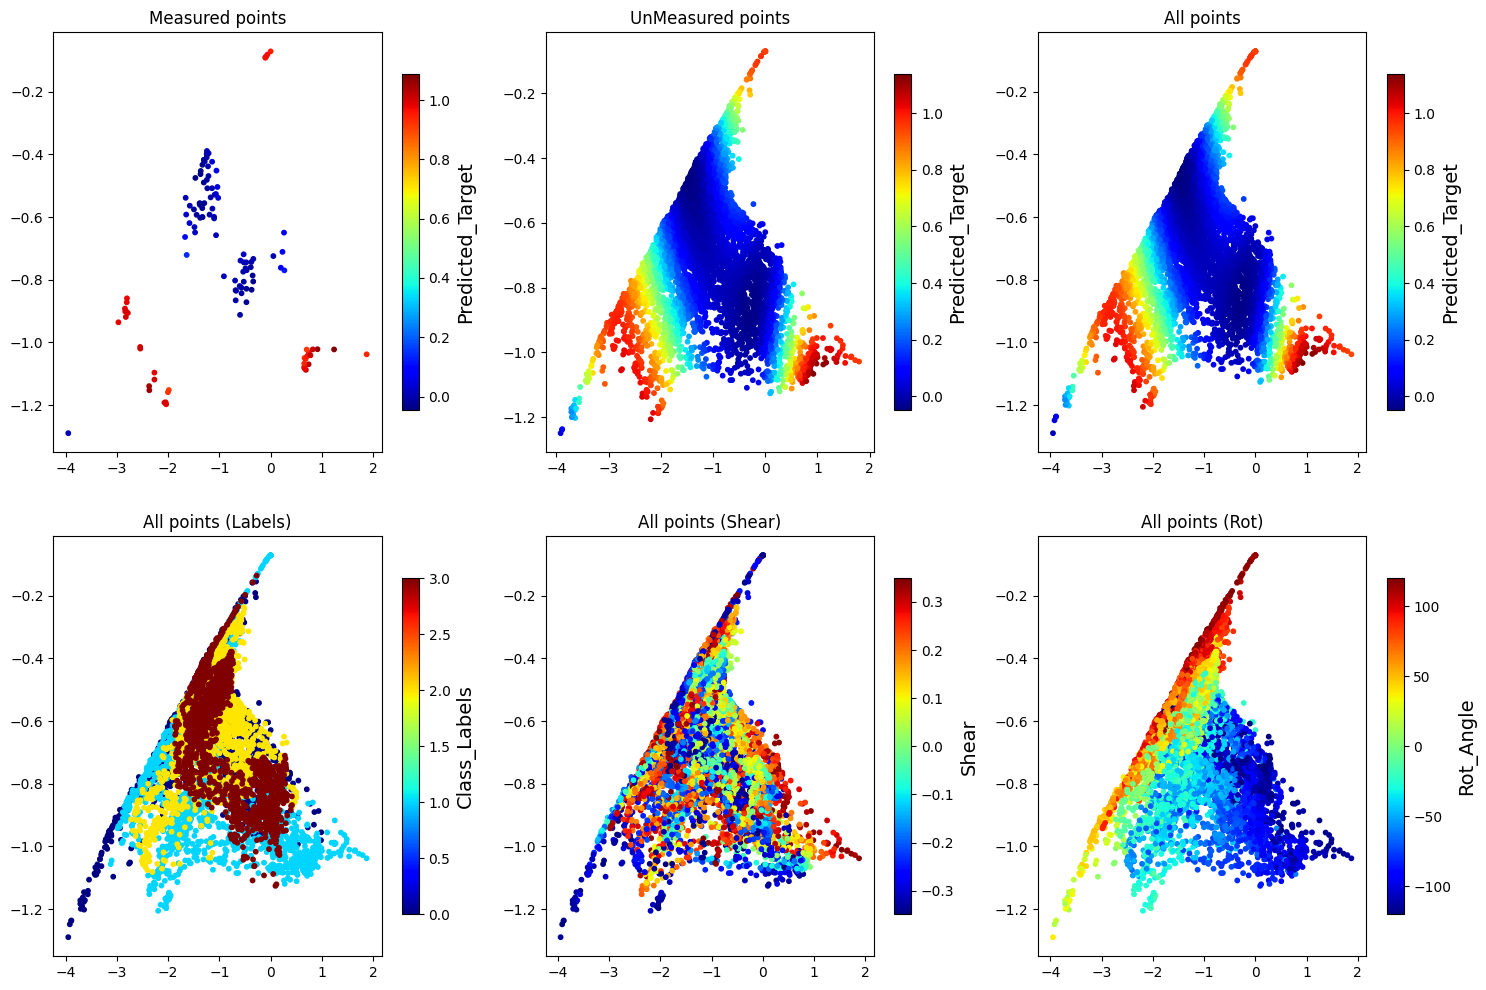

In [ ]:
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X1)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = predmean_train1, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10,
                c = predmean_unmeas1, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here, we observe a very interetsing effect where due to initial misalignment between the points the target function ended up being in different parts of the latent space. the DKL still managed to construct a much smoother manifold then the VAE - but now we have 4 maxima for "spadedness". No surprise - they look very similar to hearts.

Generally, giving more seed points will avoid this problem. 

## Hearts

And now hearts

In [ ]:
X2 = np.copy(X)
targets2 = np.zeros(len(labels_all))
targets2[labels_all == 2] = 1

rng_key_2, rng_key_predict_2 = gpax.utils.get_keys()
dkl_2 = gpax.viDKL(900, 2, 'RBF')
dkl_2.fit(rng_key_2, X2, targets2)

100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s, init loss: 69255.3770, avg. loss [951-1000]: 46061.3466]



Inferred GP kernel parameters
k_length         [5.418  4.0756]
k_scale          0.17850000000000002
noise            0.008700000000000001


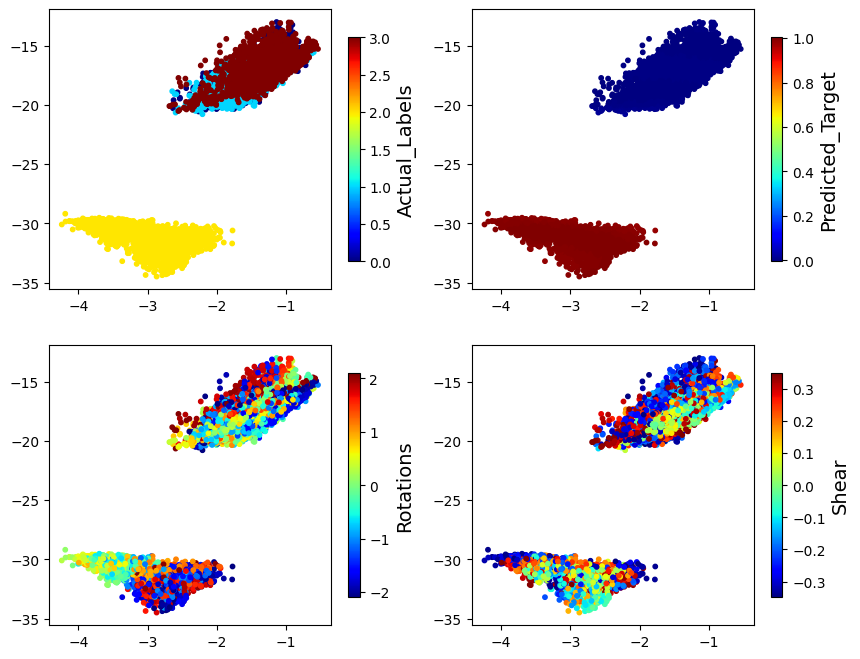

In [ ]:
embeded_2 = dkl_2.embed(X2)
pred_mean2, pred_var2 = dkl_2.predict_in_batches(rng_key_predict_2, X2, batch_size=batch_size_reconstruct)
pred_std2 = jnp.sqrt(pred_var2)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = pred_mean2, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

For hearts, the system behavior is even more interesting. Here the target manifold is fairly complex - and resembles the VAE. Still much simpler then vanilla VAE. Again, note the disentanglement of rotations - which is now global. Generally, by now you have noticed is the better the discovery of the target functionality, the worse is the disentanglement of remaining variables.

In [ ]:
np.random.seed(0)
idx2 = np.random.choice(np.arange(len(X2)), size = init_num, replace = False)
X2_train = X2[idx2]
X2_unmeasured = np.delete(X2, idx2, axis=0)

indices_total_2 = np.arange(len(X))
indices_train_2 = indices_total_2[idx2]
y2_train = targets2[idx2]
indices_unmeasured_2 = np.delete(indices_total_2, idx2)

In [ ]:
exp_mean2, exp_std2 = [], []
dkl_mean2, dkl_std2 = [], []
embed_traj2 = []
traj_mean2, traj_std2 = [], []

exploration_steps = exploration_steps


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key12, rng_key_predict12 = gpax.utils.get_keys(seed = 15)
    dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_2.fit(rng_key12, X2_train, y2_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean2.append(y_mean[id_next])
    exp_std2.append(y_std[id_next])
    
    x_next = X2_unmeasured[id_next]
    ind_next = indices_unmeasured_2[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean2.append(pred_mean2[ind_next])
    dkl_std2.append(pred_std2[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets2[ind_next]
    
    # Update training arrays
    X2_train = np.append(X2_train, x_next[None], axis=0)
    y2_train = np.append(y2_train, y_measured)
    X2_unmeasured = np.delete(X2_unmeasured, id_next, axis=0)
    indices_unmeasured_2 = np.delete(indices_unmeasured_2, id_next)
    
    embed_traj = dkl_BO_2.embed(X2_train)
    traj_m, traj_s = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_train, batch_size=batch_size_learn)
    
    embed_traj2.append(embed_traj)
    traj_mean2.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 447.62it/s, init loss: 60126.3976, avg. loss [951-1000]: 56924.1085]



Inferred GP kernel parameters
k_length         [0.3679 0.336 ]
k_scale          0.5198
noise            0.0089

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 435.75it/s, init loss: 60127.9079, avg. loss [951-1000]: 56944.4078]



Inferred GP kernel parameters
k_length         [0.3704 0.4408]
k_scale          0.45570000000000005
noise            0.018500000000000003

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 445.50it/s, init loss: 60129.2031, avg. loss [951-1000]: 56940.7924]



Inferred GP kernel parameters
k_length         [0.3678 0.3249]
k_scale          0.3758
noise            0.010700000000000001

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 446.11it/s, init loss: 60130.4951, avg. loss [951-1000]: 56922.6450]



Inferred GP kernel parameters
k_length         [0.3901 0.3884]
k_scale          0.4802
noise            0.0111

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 443.49it/s, init loss: 60131.7903, avg. loss [951-1000]: 56972.9146]



Inferred GP kernel parameters
k_length         [0.3487 0.2921]
k_scale          0.32170000000000004
noise            0.0154

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 426.90it/s, init loss: 60133.3205, avg. loss [951-1000]: 56917.2731]



Inferred GP kernel parameters
k_length         [0.3937 0.3667]
k_scale          0.3745
noise            0.0073

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 432.19it/s, init loss: 60134.6157, avg. loss [951-1000]: 56939.5448]



Inferred GP kernel parameters
k_length         [0.3551 0.3944]
k_scale          0.3579
noise            0.0108

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 452.03it/s, init loss: 60135.9109, avg. loss [951-1000]: 56961.3252]



Inferred GP kernel parameters
k_length         [0.4704 0.3649]
k_scale          0.2742
noise            0.017400000000000002

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 443.66it/s, init loss: 60137.2012, avg. loss [951-1000]: 56911.2760]



Inferred GP kernel parameters
k_length         [0.3702 0.4441]
k_scale          0.37110000000000004
noise            0.007500000000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 438.22it/s, init loss: 60138.4965, avg. loss [951-1000]: 56921.2250]



Inferred GP kernel parameters
k_length         [0.5222 0.4149]
k_scale          0.34590000000000004
noise            0.0078000000000000005

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 450.50it/s, init loss: 60139.7882, avg. loss [951-1000]: 56912.9804]



Inferred GP kernel parameters
k_length         [0.3535 0.2925]
k_scale          0.45730000000000004
noise            0.008700000000000001

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 429.90it/s, init loss: 60141.3219, avg. loss [951-1000]: 56926.5519]



Inferred GP kernel parameters
k_length         [0.3669 0.3308]
k_scale          0.3902
noise            0.0105

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 455.48it/s, init loss: 60142.8527, avg. loss [951-1000]: 56907.4795]



Inferred GP kernel parameters
k_length         [0.3663 0.3351]
k_scale          0.5111
noise            0.0076

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 451.47it/s, init loss: 60144.3833, avg. loss [951-1000]: 56903.2367]



Inferred GP kernel parameters
k_length         [0.3799 0.3672]
k_scale          0.3779
noise            0.0073

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 444.95it/s, init loss: 60145.6785, avg. loss [951-1000]: 56897.7561]



Inferred GP kernel parameters
k_length         [0.369  0.3579]
k_scale          0.4037
noise            0.006

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 433.22it/s, init loss: 60147.1053, avg. loss [951-1000]: 56901.3380]



Inferred GP kernel parameters
k_length         [0.4665 0.4814]
k_scale          0.366
noise            0.007500000000000001

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 443.18it/s, init loss: 60148.3283, avg. loss [951-1000]: 56899.8751]



Inferred GP kernel parameters
k_length         [0.3727 0.3949]
k_scale          0.34090000000000004
noise            0.007200000000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 432.23it/s, init loss: 60149.6236, avg. loss [951-1000]: 56914.8781]



Inferred GP kernel parameters
k_length         [0.4733 0.49  ]
k_scale          0.28340000000000004
noise            0.0094

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 436.99it/s, init loss: 60150.8468, avg. loss [951-1000]: 56900.0212]



Inferred GP kernel parameters
k_length         [0.5331 0.5324]
k_scale          0.3094
noise            0.006900000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 440.24it/s, init loss: 60152.1363, avg. loss [951-1000]: 56932.5022]



Inferred GP kernel parameters
k_length         [0.5104 0.465 ]
k_scale          0.2916
noise            0.0076

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 452.20it/s, init loss: 60153.4315, avg. loss [951-1000]: 57002.1549]



Inferred GP kernel parameters
k_length         [0.4022 0.2902]
k_scale          0.2879
noise            0.0092

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 442.88it/s, init loss: 60154.6944, avg. loss [951-1000]: 56887.8384]



Inferred GP kernel parameters
k_length         [0.3611 0.342 ]
k_scale          0.4249
noise            0.0058000000000000005

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 450.93it/s, init loss: 60156.2251, avg. loss [951-1000]: 56898.4894]



Inferred GP kernel parameters
k_length         [0.6009 0.4739]
k_scale          0.31120000000000003
noise            0.0068000000000000005

Step 24


100%|██████████| 1000/1000 [00:04<00:00, 241.02it/s, init loss: 60157.5692, avg. loss [951-1000]: 56885.5161]



Inferred GP kernel parameters
k_length         [0.3333 0.3978]
k_scale          0.4334
noise            0.0063

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 428.89it/s, init loss: 60158.8173, avg. loss [951-1000]: 56884.3124]



Inferred GP kernel parameters
k_length         [0.3611 0.3685]
k_scale          0.37770000000000004
noise            0.006

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 434.58it/s, init loss: 60160.1068, avg. loss [951-1000]: 56898.0202]



Inferred GP kernel parameters
k_length         [0.3993 0.4286]
k_scale          0.3241
noise            0.0067

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 435.72it/s, init loss: 60161.6376, avg. loss [951-1000]: 56897.3996]



Inferred GP kernel parameters
k_length         [0.3864 0.328 ]
k_scale          0.3416
noise            0.0085

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 434.34it/s, init loss: 60162.9271, avg. loss [951-1000]: 56917.6347]



Inferred GP kernel parameters
k_length         [0.5061 0.574 ]
k_scale          0.29300000000000004
noise            0.007200000000000001

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 427.23it/s, init loss: 60164.1399, avg. loss [951-1000]: 56886.1592]



Inferred GP kernel parameters
k_length         [0.4142 0.3719]
k_scale          0.39480000000000004
noise            0.0066

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 419.91it/s, init loss: 60165.3406, avg. loss [951-1000]: 56879.2660]



Inferred GP kernel parameters
k_length         [0.3857 0.3723]
k_scale          0.36260000000000003
noise            0.006200000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 428.42it/s, init loss: 60166.6901, avg. loss [951-1000]: 56892.4418]



Inferred GP kernel parameters
k_length         [0.4601 0.5307]
k_scale          0.32430000000000003
noise            0.0064

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 442.05it/s, init loss: 60168.1813, avg. loss [951-1000]: 56874.6714]



Inferred GP kernel parameters
k_length         [0.3643 0.3568]
k_scale          0.37510000000000004
noise            0.0061

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 442.23it/s, init loss: 60169.7054, avg. loss [951-1000]: 56879.2992]



Inferred GP kernel parameters
k_length         [0.5164 0.5526]
k_scale          0.30970000000000003
noise            0.007

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 443.80it/s, init loss: 60170.8652, avg. loss [951-1000]: 56890.3927]



Inferred GP kernel parameters
k_length         [0.6447 0.7532]
k_scale          0.25370000000000004
noise            0.0085

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 449.49it/s, init loss: 60172.3919, avg. loss [951-1000]: 56878.5705]



Inferred GP kernel parameters
k_length         [0.42   0.3853]
k_scale          0.42150000000000004
noise            0.0074

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 426.66it/s, init loss: 60173.8464, avg. loss [951-1000]: 56886.0848]



Inferred GP kernel parameters
k_length         [0.6112 0.4894]
k_scale          0.303
noise            0.006500000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 409.21it/s, init loss: 60175.1412, avg. loss [951-1000]: 56867.0374]



Inferred GP kernel parameters
k_length         [0.3768 0.3641]
k_scale          0.36860000000000004
noise            0.0061

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 436.71it/s, init loss: 60176.6714, avg. loss [951-1000]: 56930.3102]



Inferred GP kernel parameters
k_length         [0.6852 0.6383]
k_scale          0.29600000000000004
noise            0.0094

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 449.05it/s, init loss: 60177.9258, avg. loss [951-1000]: 56866.2248]



Inferred GP kernel parameters
k_length         [0.4713 0.4646]
k_scale          0.3559
noise            0.0064

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 441.41it/s, init loss: 60179.4441, avg. loss [951-1000]: 56947.2411]



Inferred GP kernel parameters
k_length         [0.5892 0.5369]
k_scale          0.2519
noise            0.01

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 433.64it/s, init loss: 60180.7627, avg. loss [951-1000]: 56956.3854]



Inferred GP kernel parameters
k_length         [0.5079 0.4412]
k_scale          0.2914
noise            0.0114

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 430.45it/s, init loss: 60182.1725, avg. loss [951-1000]: 56927.0384]



Inferred GP kernel parameters
k_length         [0.4081 0.4467]
k_scale          0.24200000000000002
noise            0.0082

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 437.81it/s, init loss: 60183.4607, avg. loss [951-1000]: 56876.3074]



Inferred GP kernel parameters
k_length         [0.5292 0.624 ]
k_scale          0.33
noise            0.007500000000000001

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 440.73it/s, init loss: 60184.9902, avg. loss [951-1000]: 56856.3636]



Inferred GP kernel parameters
k_length         [0.5518 0.4542]
k_scale          0.3694
noise            0.006200000000000001

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 439.21it/s, init loss: 60186.5256, avg. loss [951-1000]: 56852.2313]



Inferred GP kernel parameters
k_length         [0.3629 0.359 ]
k_scale          0.38170000000000004
noise            0.0056

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 441.04it/s, init loss: 60187.9619, avg. loss [951-1000]: 56851.0893]



Inferred GP kernel parameters
k_length         [0.367  0.3661]
k_scale          0.3955
noise            0.0056

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 435.05it/s, init loss: 60189.1373, avg. loss [951-1000]: 56863.0608]



Inferred GP kernel parameters
k_length         [0.4472 0.4404]
k_scale          0.3276
noise            0.0067

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 415.69it/s, init loss: 60190.6503, avg. loss [951-1000]: 56882.9149]



Inferred GP kernel parameters
k_length         [0.5566 0.7119]
k_scale          0.2582
noise            0.0085

Step 49


100%|██████████| 1000/1000 [00:04<00:00, 232.82it/s, init loss: 60191.8816, avg. loss [951-1000]: 56855.5972]



Inferred GP kernel parameters
k_length         [0.4099 0.4873]
k_scale          0.30410000000000004
noise            0.006200000000000001

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 427.28it/s, init loss: 60193.1519, avg. loss [951-1000]: 56845.0708]



Inferred GP kernel parameters
k_length         [0.3474 0.3748]
k_scale          0.3699
noise            0.0058000000000000005

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 436.98it/s, init loss: 60194.4234, avg. loss [951-1000]: 56842.9482]



Inferred GP kernel parameters
k_length         [0.3593 0.3657]
k_scale          0.41150000000000003
noise            0.0053

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 433.16it/s, init loss: 60195.9538, avg. loss [951-1000]: 56844.2976]



Inferred GP kernel parameters
k_length         [0.3936 0.4328]
k_scale          0.3865
noise            0.0057

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 426.95it/s, init loss: 60197.2491, avg. loss [951-1000]: 56849.1969]



Inferred GP kernel parameters
k_length         [0.5457 0.5682]
k_scale          0.32
noise            0.0073

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 416.92it/s, init loss: 60198.7798, avg. loss [951-1000]: 56858.3813]



Inferred GP kernel parameters
k_length         [0.388  0.3912]
k_scale          0.35900000000000004
noise            0.0059

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 410.26it/s, init loss: 60200.2982, avg. loss [951-1000]: 56870.3504]



Inferred GP kernel parameters
k_length         [0.533  0.4869]
k_scale          0.27690000000000003
noise            0.0071

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 424.45it/s, init loss: 60201.5934, avg. loss [951-1000]: 56886.1516]



Inferred GP kernel parameters
k_length         [0.4519 0.5968]
k_scale          0.3301
noise            0.006200000000000001

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 434.75it/s, init loss: 60202.8145, avg. loss [951-1000]: 56861.8810]



Inferred GP kernel parameters
k_length         [0.8138 1.1257]
k_scale          0.266
noise            0.0073

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 438.17it/s, init loss: 60204.3378, avg. loss [951-1000]: 56844.4491]



Inferred GP kernel parameters
k_length         [0.4215 0.4156]
k_scale          0.36960000000000004
noise            0.0063

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 422.84it/s, init loss: 60205.4414, avg. loss [951-1000]: 56844.1104]



Inferred GP kernel parameters
k_length         [0.5556 0.555 ]
k_scale          0.28290000000000004
noise            0.0073

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 410.40it/s, init loss: 60206.7198, avg. loss [951-1000]: 56839.3411]



Inferred GP kernel parameters
k_length         [0.4426 0.5458]
k_scale          0.2954
noise            0.006500000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 399.21it/s, init loss: 60208.0150, avg. loss [951-1000]: 56880.3790]



Inferred GP kernel parameters
k_length         [0.5054 0.5312]
k_scale          0.3105
noise            0.007200000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 414.67it/s, init loss: 60209.3305, avg. loss [951-1000]: 56845.4045]



Inferred GP kernel parameters
k_length         [0.4925 0.5074]
k_scale          0.2977
noise            0.0061

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 425.20it/s, init loss: 60210.7013, avg. loss [951-1000]: 56878.3264]



Inferred GP kernel parameters
k_length         [1.2759 0.6737]
k_scale          0.2516
noise            0.008

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 416.12it/s, init loss: 60211.8054, avg. loss [951-1000]: 56850.5857]



Inferred GP kernel parameters
k_length         [0.5752 0.7012]
k_scale          0.27640000000000003
noise            0.0077

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 410.52it/s, init loss: 60212.9867, avg. loss [951-1000]: 56824.1249]



Inferred GP kernel parameters
k_length         [0.4805 0.5233]
k_scale          0.35760000000000003
noise            0.0059

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 419.60it/s, init loss: 60214.1918, avg. loss [951-1000]: 56898.6993]



Inferred GP kernel parameters
k_length         [0.7315 0.6064]
k_scale          0.2569
noise            0.0109

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 416.69it/s, init loss: 60215.6603, avg. loss [951-1000]: 56959.5103]



Inferred GP kernel parameters
k_length         [0.5844 0.6998]
k_scale          0.3544
noise            0.0114

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 412.14it/s, init loss: 60216.9063, avg. loss [951-1000]: 56847.0538]



Inferred GP kernel parameters
k_length         [0.6745 0.6105]
k_scale          0.25720000000000004
noise            0.0073

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 414.53it/s, init loss: 60218.2009, avg. loss [951-1000]: 56868.1843]



Inferred GP kernel parameters
k_length         [0.6294 0.4871]
k_scale          0.311
noise            0.006900000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 420.43it/s, init loss: 60219.2780, avg. loss [951-1000]: 56819.7730]



Inferred GP kernel parameters
k_length         [0.5516 0.4557]
k_scale          0.36360000000000003
noise            0.006

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 427.57it/s, init loss: 60220.5545, avg. loss [951-1000]: 56841.3182]



Inferred GP kernel parameters
k_length         [0.3986 0.4313]
k_scale          0.3771
noise            0.0064

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 425.96it/s, init loss: 60221.7165, avg. loss [951-1000]: 56813.7639]



Inferred GP kernel parameters
k_length         [0.4469 0.5236]
k_scale          0.371
noise            0.006

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 425.06it/s, init loss: 60222.8378, avg. loss [951-1000]: 56824.6280]



Inferred GP kernel parameters
k_length         [0.5711 0.6086]
k_scale          0.3441
noise            0.0064

Step 74


100%|██████████| 1000/1000 [00:04<00:00, 228.69it/s, init loss: 60224.1307, avg. loss [951-1000]: 56816.3177]



Inferred GP kernel parameters
k_length         [0.4949 0.453 ]
k_scale          0.3563
noise            0.0059

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 425.97it/s, init loss: 60225.4946, avg. loss [951-1000]: 56817.0440]



Inferred GP kernel parameters
k_length         [0.6101 0.7859]
k_scale          0.30610000000000004
noise            0.0061

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 408.45it/s, init loss: 60226.9941, avg. loss [951-1000]: 56874.1920]



Inferred GP kernel parameters
k_length         [0.5387 0.5895]
k_scale          0.3549
noise            0.0064

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 399.26it/s, init loss: 60228.4442, avg. loss [951-1000]: 56852.0897]



Inferred GP kernel parameters
k_length         [0.5039 0.5073]
k_scale          0.3981
noise            0.007500000000000001

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 411.75it/s, init loss: 60229.5998, avg. loss [951-1000]: 57055.1780]



Inferred GP kernel parameters
k_length         [0.4109 0.2802]
k_scale          0.42710000000000004
noise            0.012100000000000001

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 418.31it/s, init loss: 60230.8386, avg. loss [951-1000]: 56879.7632]



Inferred GP kernel parameters
k_length         [1.0478 1.1326]
k_scale          0.2164
noise            0.012700000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 421.46it/s, init loss: 60232.1338, avg. loss [951-1000]: 56827.4136]



Inferred GP kernel parameters
k_length         [0.7796 1.0391]
k_scale          0.2654
noise            0.0071

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 424.10it/s, init loss: 60233.4238, avg. loss [951-1000]: 56932.1775]



Inferred GP kernel parameters
k_length         [0.6064 0.7129]
k_scale          0.2802
noise            0.008

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 433.56it/s, init loss: 60234.9123, avg. loss [951-1000]: 56805.6797]



Inferred GP kernel parameters
k_length         [0.5541 0.5182]
k_scale          0.35000000000000003
noise            0.0063

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 429.23it/s, init loss: 60236.1973, avg. loss [951-1000]: 56831.3028]



Inferred GP kernel parameters
k_length         [0.5812 0.4654]
k_scale          0.4121
noise            0.0059

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 412.62it/s, init loss: 60237.5027, avg. loss [951-1000]: 56801.8946]



Inferred GP kernel parameters
k_length         [0.7727 0.8407]
k_scale          0.3294
noise            0.006

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 423.90it/s, init loss: 60238.7168, avg. loss [951-1000]: 56832.2675]



Inferred GP kernel parameters
k_length         [0.784  0.6635]
k_scale          0.27690000000000003
noise            0.007200000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 440.74it/s, init loss: 60240.0120, avg. loss [951-1000]: 56795.7487]



Inferred GP kernel parameters
k_length         [0.5158 0.5262]
k_scale          0.39080000000000004
noise            0.0061

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 437.63it/s, init loss: 60241.5054, avg. loss [951-1000]: 56860.0360]



Inferred GP kernel parameters
k_length         [0.4269 0.4365]
k_scale          0.37020000000000003
noise            0.0064

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 423.30it/s, init loss: 60242.9348, avg. loss [951-1000]: 56797.5787]



Inferred GP kernel parameters
k_length         [0.5981 0.5855]
k_scale          0.35550000000000004
noise            0.006

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 416.49it/s, init loss: 60244.4333, avg. loss [951-1000]: 56991.9160]



Inferred GP kernel parameters
k_length         [0.3902 0.343 ]
k_scale          0.47500000000000003
noise            0.0067

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 410.04it/s, init loss: 60245.7052, avg. loss [951-1000]: 56800.9114]



Inferred GP kernel parameters
k_length         [0.4724 0.5341]
k_scale          0.3486
noise            0.0061

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 430.52it/s, init loss: 60247.0002, avg. loss [951-1000]: 56807.7506]



Inferred GP kernel parameters
k_length         [0.5498 0.6857]
k_scale          0.2723
noise            0.007200000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 430.15it/s, init loss: 60248.2253, avg. loss [951-1000]: 56911.9304]



Inferred GP kernel parameters
k_length         [1.0355 1.0881]
k_scale          0.19190000000000002
noise            0.0106

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 434.82it/s, init loss: 60249.4873, avg. loss [951-1000]: 56794.9215]



Inferred GP kernel parameters
k_length         [0.4054 0.5311]
k_scale          0.3527
noise            0.006200000000000001

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 424.46it/s, init loss: 60250.7826, avg. loss [951-1000]: 56770.1088]



Inferred GP kernel parameters
k_length         [0.4053 0.521 ]
k_scale          0.41290000000000004
noise            0.005200000000000001

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 414.26it/s, init loss: 60252.2397, avg. loss [951-1000]: 56791.7138]



Inferred GP kernel parameters
k_length         [0.766  0.9105]
k_scale          0.28900000000000003
noise            0.0066

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 426.07it/s, init loss: 60253.3508, avg. loss [951-1000]: 56786.0577]



Inferred GP kernel parameters
k_length         [0.5869 0.583 ]
k_scale          0.3057
noise            0.0061

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 413.02it/s, init loss: 60254.6460, avg. loss [951-1000]: 56986.5691]



Inferred GP kernel parameters
k_length         [0.4595 0.482 ]
k_scale          0.37060000000000004
noise            0.0076

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 417.84it/s, init loss: 60255.7375, avg. loss [951-1000]: 56789.1589]



Inferred GP kernel parameters
k_length         [0.5128 0.4701]
k_scale          0.3146
noise            0.0059

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 412.00it/s, init loss: 60257.1803, avg. loss [951-1000]: 56793.0579]



Inferred GP kernel parameters
k_length         [1.089  0.8181]
k_scale          0.309
noise            0.0066

Step 100


100%|██████████| 1000/1000 [00:04<00:00, 224.59it/s, init loss: 60258.3789, avg. loss [951-1000]: 56796.5128]



Inferred GP kernel parameters
k_length         [1.2581 0.8996]
k_scale          0.2587
noise            0.0067


In [ ]:
hearts_results = {}
hearts_results['X_train'] = X2_train
hearts_results['y_train'] = y2_train
hearts_results['X_unmeasured'] = X2_unmeasured
hearts_results['indices_unmeasured'] = indices_unmeasured_2
hearts_results['dkl_mean'] = dkl_mean2
hearts_results['dkl_std'] = dkl_std2
hearts_results['exp_mean'] = exp_mean2
hearts_results['exp_std'] = exp_std2
hearts_results['traj_mean'] = traj_mean2
hearts_results['traj_std'] = traj_std2
hearts_results['embed_traj'] = embed_traj2

with open('hearts_results.pickle', 'wb') as handle:
    pickle.dump(hearts_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('hearts_results.pickle', 'rb') as f:
    hearts_results = pickle.load(f)

X2_train = hearts_results['X_train']
y2_train = hearts_results['y_train']
X2_unmeasured = hearts_results['X_unmeasured']
indices_unmeasured_2 = hearts_results['indices_unmeasured']
dkl_mean2 = hearts_results['dkl_mean']
dkl_std2 = hearts_results['dkl_std']
exp_mean2 = hearts_results['exp_mean'] 
exp_std2 = hearts_results['exp_std']
traj_mean2 = hearts_results['traj_mean']
traj_std2 = hearts_results['traj_std']
embed_traj2 = hearts_results['embed_traj']

In [ ]:
rng_key12, rng_key_predict12 = gpax.utils.get_keys()
dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_2.fit(rng_key12, X2_train, y2_train)

predmean_train2, predstd_train2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_train, batch_size=batch_size_learn)
predmean_unmeas2, predstd_unmeas2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_unmeasured, batch_size=batch_size_reconstruct)
predmean12, predstd12 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 426.46it/s, init loss: 60234.4287, avg. loss [951-1000]: 56869.3441]



Inferred GP kernel parameters
k_length         [0.4435 0.4985]
k_scale          0.2667
noise            0.010400000000000001


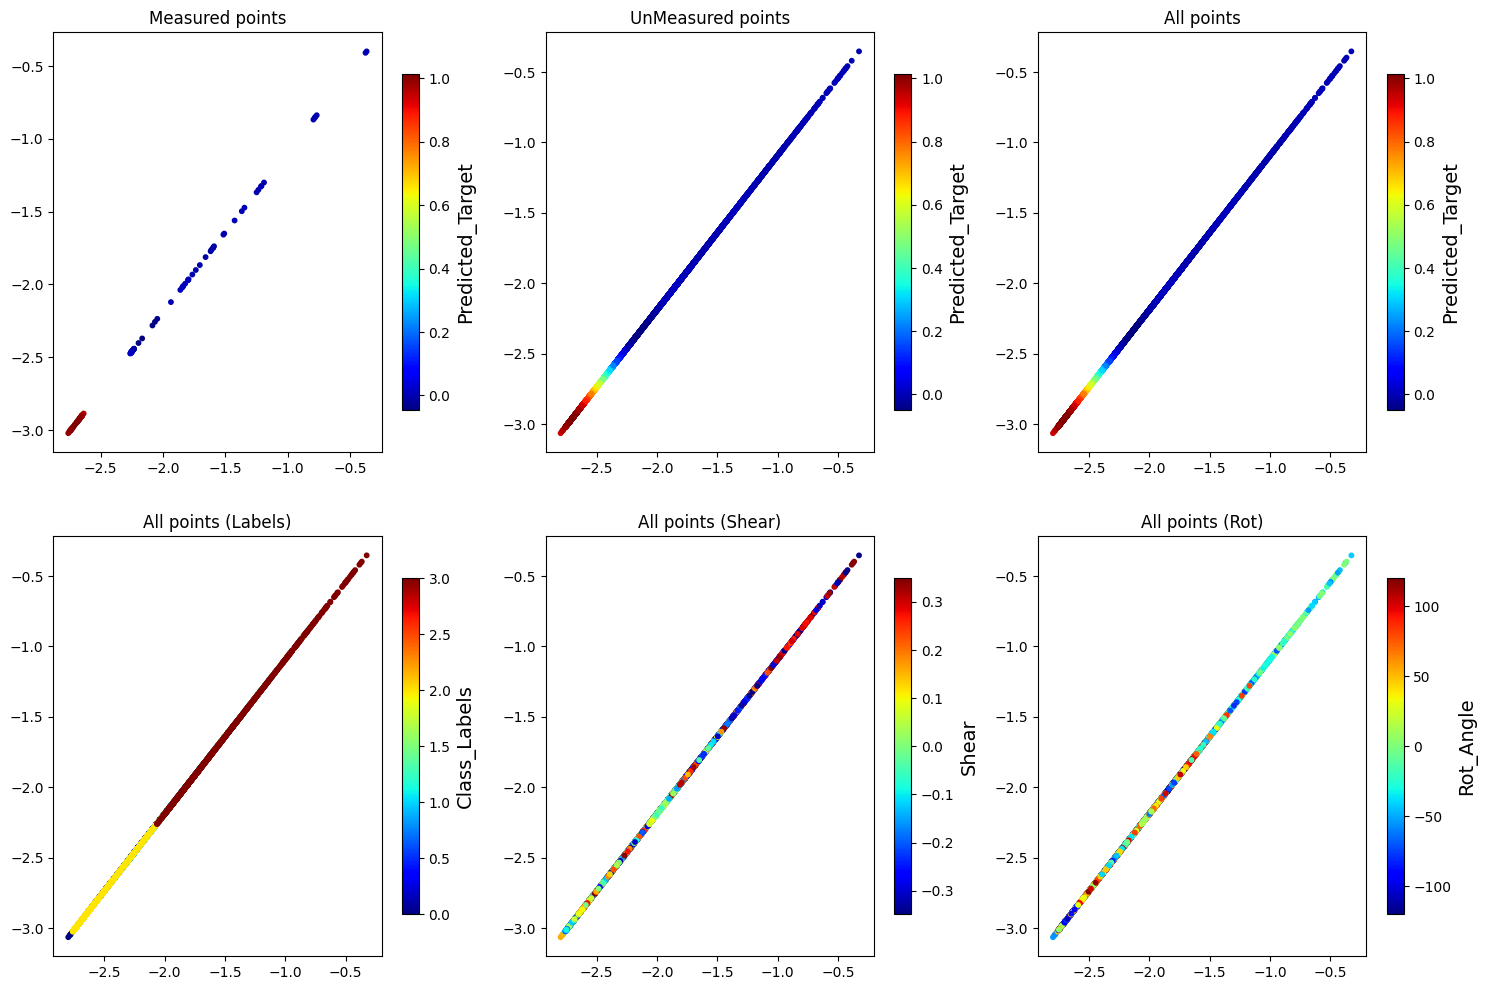

In [ ]:
embeded_train2 = dkl_BO_2.embed(X2_train)  # Measured points
embeded_unmeasured2 = dkl_BO_2.embed(X2_unmeasured)  # Unmeasured points
embeded12 = dkl_BO_2.embed(X2)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train2[:, 1], embeded_train2[:, 0], s=10, c = predmean_train2, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured2[:, 1], embeded_unmeasured2[:, 0], s=10,
                c = predmean_unmeas2, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = predmean12, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here, active learning produced much better manifolds. Instead of competing for the sam ereal estate in the latent space, active learning focussed attention on the attribute we are interested in (i.e. how close is the image to being a heart)

## Diamonds

And for completeness, diamonds. 

In [ ]:
X3 = np.copy(X)
targets3 = np.zeros(len(labels_all))
targets3[labels_all == 3] = 1

rng_key_3, rng_key_predict_3 = gpax.utils.get_keys()
dkl_3 = gpax.viDKL(900, 2, 'RBF')
dkl_3.fit(rng_key_3, X3, targets3)

100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s, init loss: 69245.0383, avg. loss [951-1000]: 46108.3986]



Inferred GP kernel parameters
k_length         [4.987  3.9171]
k_scale          0.1661
noise            0.0083


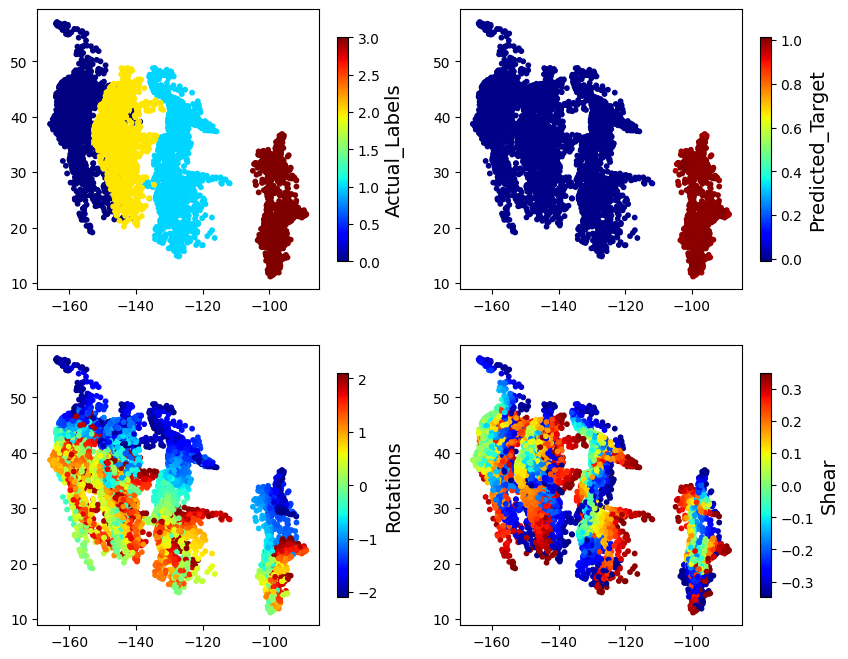

In [ ]:
embeded_3 = dkl_3.embed(X3)
pred_mean3, pred_var3 = dkl_3.predict_in_batches(rng_key_predict_3, X3, batch_size=batch_size_reconstruct)
pred_std3 = jnp.sqrt(pred_var3)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = pred_mean3, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here again we see relatively simple latent distribution. Diamonds are well separated form other three hands in the latent space. As before, good separation based on one attribute means poor disentanglement on other fatcors of variability. 

In [ ]:
np.random.seed(0)
idx3 = np.random.choice(np.arange(len(X3)), size = init_num, replace = False)
X3_train = X3[idx3]
X3_unmeasured = np.delete(X3, idx3, axis=0)

indices_total_3 = np.arange(len(X))
indices_train_3 = indices_total_3[idx3]
y3_train = targets3[idx3]
indices_unmeasured_3 = np.delete(indices_total_3, idx3)

In [ ]:
exp_mean3, exp_std3 = [], []
dkl_mean3, dkl_std3 = [], []
embed_traj3 = []
traj_mean3, traj_std3 = [], []

exploration_steps = 70


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key13, rng_key_predict13 = gpax.utils.get_keys()
    dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_3.fit(rng_key13, X3_train, y3_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean3.append(y_mean[id_next])
    exp_std3.append(y_std[id_next])
    
    x_next = X3_unmeasured[id_next]
    ind_next = indices_unmeasured_3[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean3.append(pred_mean3[ind_next])
    dkl_std3.append(pred_std3[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets3[ind_next]
    
    # Update training arrays
    X3_train = np.append(X3_train, x_next[None], axis=0)
    y3_train = np.append(y3_train, y_measured)
    X3_unmeasured = np.delete(X3_unmeasured, id_next, axis=0)
    indices_unmeasured_3 = np.delete(indices_unmeasured_3, id_next)
    
    embed_traj = dkl_BO_3.embed(X3_train)
    traj_m, traj_s = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_train, batch_size=batch_size_learn)
    
    embed_traj3.append(embed_traj)
    traj_mean3.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 438.10it/s, init loss: 60100.9646, avg. loss [951-1000]: 56926.6555]



Inferred GP kernel parameters
k_length         [0.3679 0.313 ]
k_scale          0.5228
noise            0.0149

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 439.01it/s, init loss: 60102.4692, avg. loss [951-1000]: 56948.7300]



Inferred GP kernel parameters
k_length         [0.3871 0.3252]
k_scale          0.2897
noise            0.021500000000000002

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 455.34it/s, init loss: 60103.9687, avg. loss [951-1000]: 56920.7480]



Inferred GP kernel parameters
k_length         [0.3335 0.3679]
k_scale          0.39880000000000004
noise            0.0123

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 466.52it/s, init loss: 60105.4738, avg. loss [951-1000]: 56937.0872]



Inferred GP kernel parameters
k_length         [0.5355 0.4606]
k_scale          0.3135
noise            0.0247

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 447.60it/s, init loss: 60106.7961, avg. loss [951-1000]: 56927.6163]



Inferred GP kernel parameters
k_length         [0.3721 0.31  ]
k_scale          0.39530000000000004
noise            0.0146

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 432.91it/s, init loss: 60108.0403, avg. loss [951-1000]: 56935.2144]



Inferred GP kernel parameters
k_length         [0.3898 0.4592]
k_scale          0.3415
noise            0.0182

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 469.97it/s, init loss: 60109.2846, avg. loss [951-1000]: 56923.6954]



Inferred GP kernel parameters
k_length         [0.3924 0.3499]
k_scale          0.3768
noise            0.016

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 439.13it/s, init loss: 60110.5289, avg. loss [951-1000]: 56915.7982]



Inferred GP kernel parameters
k_length         [0.3592 0.3146]
k_scale          0.40750000000000003
noise            0.0126

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 438.11it/s, init loss: 60111.7732, avg. loss [951-1000]: 56912.2273]



Inferred GP kernel parameters
k_length         [0.3467 0.3685]
k_scale          0.43270000000000003
noise            0.0112

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 446.07it/s, init loss: 60113.2516, avg. loss [951-1000]: 56923.3831]



Inferred GP kernel parameters
k_length         [0.2325 0.3679]
k_scale          0.3805
noise            0.0126

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 415.02it/s, init loss: 60114.7566, avg. loss [951-1000]: 56912.3404]



Inferred GP kernel parameters
k_length         [0.3679 0.3058]
k_scale          0.32220000000000004
noise            0.0108

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 415.73it/s, init loss: 60115.9984, avg. loss [951-1000]: 56970.5474]



Inferred GP kernel parameters
k_length         [0.3806 0.4658]
k_scale          0.3038
noise            0.027100000000000003

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 424.24it/s, init loss: 60117.4773, avg. loss [951-1000]: 56915.7617]



Inferred GP kernel parameters
k_length         [0.3652 0.4461]
k_scale          0.405
noise            0.0115

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 432.88it/s, init loss: 60118.8836, avg. loss [951-1000]: 56908.1811]



Inferred GP kernel parameters
k_length         [0.3477 0.3612]
k_scale          0.34800000000000003
noise            0.0115

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 435.42it/s, init loss: 60120.1277, avg. loss [951-1000]: 56903.2245]



Inferred GP kernel parameters
k_length         [0.3168 0.3679]
k_scale          0.43360000000000004
noise            0.0097

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 434.13it/s, init loss: 60121.6328, avg. loss [951-1000]: 56904.1895]



Inferred GP kernel parameters
k_length         [0.2995 0.3679]
k_scale          0.3529
noise            0.0099

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 430.40it/s, init loss: 60123.1376, avg. loss [951-1000]: 56904.9943]



Inferred GP kernel parameters
k_length         [0.2461 0.338 ]
k_scale          0.461
noise            0.0097

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 415.23it/s, init loss: 60124.4647, avg. loss [951-1000]: 56931.9448]



Inferred GP kernel parameters
k_length         [0.2916 0.2301]
k_scale          0.4798
noise            0.012400000000000001

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 436.47it/s, init loss: 60125.7090, avg. loss [951-1000]: 56910.0705]



Inferred GP kernel parameters
k_length         [0.3704 0.4879]
k_scale          0.302
noise            0.0152

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 438.04it/s, init loss: 60126.9517, avg. loss [951-1000]: 56899.7302]



Inferred GP kernel parameters
k_length         [0.3108 0.3679]
k_scale          0.3521
noise            0.0102

Step 21


100%|██████████| 1000/1000 [00:04<00:00, 225.68it/s, init loss: 60128.1764, avg. loss [951-1000]: 56898.1284]



Inferred GP kernel parameters
k_length         [0.2989 0.3679]
k_scale          0.3542
noise            0.0099

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 442.14it/s, init loss: 60129.4194, avg. loss [951-1000]: 56893.7743]



Inferred GP kernel parameters
k_length         [0.3679 0.3255]
k_scale          0.4193
noise            0.009000000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 442.01it/s, init loss: 60130.6550, avg. loss [951-1000]: 56896.4213]



Inferred GP kernel parameters
k_length         [0.4258 0.37  ]
k_scale          0.3609
noise            0.0102

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 441.37it/s, init loss: 60131.8992, avg. loss [951-1000]: 56892.4742]



Inferred GP kernel parameters
k_length         [0.3216 0.3736]
k_scale          0.4289
noise            0.0099

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 431.52it/s, init loss: 60133.2530, avg. loss [951-1000]: 56894.8966]



Inferred GP kernel parameters
k_length         [0.6003 0.5482]
k_scale          0.33530000000000004
noise            0.0106

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 449.58it/s, init loss: 60134.4634, avg. loss [951-1000]: 56911.9410]



Inferred GP kernel parameters
k_length         [0.6056 0.4858]
k_scale          0.32030000000000003
noise            0.014400000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 450.05it/s, init loss: 60135.7077, avg. loss [951-1000]: 56888.4080]



Inferred GP kernel parameters
k_length         [0.3274 0.3679]
k_scale          0.3816
noise            0.0089

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 442.31it/s, init loss: 60137.1822, avg. loss [951-1000]: 56940.5929]



Inferred GP kernel parameters
k_length         [0.5851 0.4972]
k_scale          0.2504
noise            0.013900000000000001

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 435.98it/s, init loss: 60138.6872, avg. loss [951-1000]: 56903.1928]



Inferred GP kernel parameters
k_length         [0.4446 0.8745]
k_scale          0.2644
noise            0.012700000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 434.56it/s, init loss: 60139.9314, avg. loss [951-1000]: 56908.1055]



Inferred GP kernel parameters
k_length         [0.6022 0.5662]
k_scale          0.3201
noise            0.0117

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 424.65it/s, init loss: 60141.1757, avg. loss [951-1000]: 56961.9253]



Inferred GP kernel parameters
k_length         [0.2403 0.3038]
k_scale          0.38730000000000003
noise            0.011600000000000001

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 445.78it/s, init loss: 60142.5334, avg. loss [951-1000]: 56882.1314]



Inferred GP kernel parameters
k_length         [0.369  0.3657]
k_scale          0.36510000000000004
noise            0.0092

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 429.94it/s, init loss: 60143.7777, avg. loss [951-1000]: 56881.8983]



Inferred GP kernel parameters
k_length         [0.367  0.3541]
k_scale          0.3728
noise            0.0091

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 435.74it/s, init loss: 60145.0187, avg. loss [951-1000]: 56897.7109]



Inferred GP kernel parameters
k_length         [0.5055 0.4818]
k_scale          0.29000000000000004
noise            0.010700000000000001

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 448.83it/s, init loss: 60146.4998, avg. loss [951-1000]: 56895.4648]



Inferred GP kernel parameters
k_length         [0.4542 0.4466]
k_scale          0.35200000000000004
noise            0.011600000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 431.57it/s, init loss: 60147.7415, avg. loss [951-1000]: 56916.3681]



Inferred GP kernel parameters
k_length         [0.5119 0.5569]
k_scale          0.2953
noise            0.013900000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 433.21it/s, init loss: 60149.2466, avg. loss [951-1000]: 56880.0433]



Inferred GP kernel parameters
k_length         [0.6015 0.5505]
k_scale          0.29550000000000004
noise            0.009300000000000001

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 445.73it/s, init loss: 60150.7236, avg. loss [951-1000]: 56900.9160]



Inferred GP kernel parameters
k_length         [0.4136 0.4267]
k_scale          0.303
noise            0.0111

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 448.40it/s, init loss: 60151.9679, avg. loss [951-1000]: 56873.2223]



Inferred GP kernel parameters
k_length         [0.4839 0.5154]
k_scale          0.3463
noise            0.0092

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 437.61it/s, init loss: 60153.2097, avg. loss [951-1000]: 56926.4619]



Inferred GP kernel parameters
k_length         [0.4338 0.4734]
k_scale          0.2485
noise            0.013800000000000002

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 432.36it/s, init loss: 60154.3795, avg. loss [951-1000]: 56911.7775]



Inferred GP kernel parameters
k_length         [0.32   0.3348]
k_scale          0.3517
noise            0.0102

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 419.97it/s, init loss: 60155.8584, avg. loss [951-1000]: 56955.2809]



Inferred GP kernel parameters
k_length         [0.2866 0.3161]
k_scale          0.4136
noise            0.0112

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 444.84it/s, init loss: 60157.3635, avg. loss [951-1000]: 56866.0295]



Inferred GP kernel parameters
k_length         [0.3482 0.3687]
k_scale          0.3669
noise            0.0088

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 444.09it/s, init loss: 60158.8654, avg. loss [951-1000]: 56876.9210]



Inferred GP kernel parameters
k_length         [0.4459 0.5231]
k_scale          0.2994
noise            0.0105

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 446.22it/s, init loss: 60160.1096, avg. loss [951-1000]: 56883.1732]



Inferred GP kernel parameters
k_length         [0.5599 0.5932]
k_scale          0.3129
noise            0.010400000000000001

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 433.49it/s, init loss: 60161.3487, avg. loss [951-1000]: 56870.6216]



Inferred GP kernel parameters
k_length         [0.4242 0.451 ]
k_scale          0.30560000000000004
noise            0.0106

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 439.26it/s, init loss: 60162.7354, avg. loss [951-1000]: 56922.8905]



Inferred GP kernel parameters
k_length         [0.4135 0.355 ]
k_scale          0.2676
noise            0.0102

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 427.42it/s, init loss: 60163.9791, avg. loss [951-1000]: 56864.8285]



Inferred GP kernel parameters
k_length         [0.4469 0.4014]
k_scale          0.311
noise            0.0095

Step 49


100%|██████████| 1000/1000 [00:04<00:00, 224.04it/s, init loss: 60165.4839, avg. loss [951-1000]: 56878.2790]



Inferred GP kernel parameters
k_length         [0.4441 0.4294]
k_scale          0.327
noise            0.0094

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 425.19it/s, init loss: 60166.9644, avg. loss [951-1000]: 56859.9040]



Inferred GP kernel parameters
k_length         [0.4059 0.4363]
k_scale          0.3543
noise            0.0089

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 440.03it/s, init loss: 60168.3466, avg. loss [951-1000]: 56854.6351]



Inferred GP kernel parameters
k_length         [0.3421 0.3866]
k_scale          0.3617
noise            0.0085

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 434.41it/s, init loss: 60169.6105, avg. loss [951-1000]: 56866.7048]



Inferred GP kernel parameters
k_length         [0.5334 0.6093]
k_scale          0.2933
noise            0.0099

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 441.27it/s, init loss: 60171.1106, avg. loss [951-1000]: 56860.5377]



Inferred GP kernel parameters
k_length         [0.3833 0.3845]
k_scale          0.34490000000000004
noise            0.0088

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 432.48it/s, init loss: 60172.6126, avg. loss [951-1000]: 56857.0674]



Inferred GP kernel parameters
k_length         [0.6683 0.7823]
k_scale          0.28800000000000003
noise            0.0094

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 433.76it/s, init loss: 60174.0618, avg. loss [951-1000]: 56860.1379]



Inferred GP kernel parameters
k_length         [0.4972 0.5208]
k_scale          0.2948
noise            0.0091

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 404.93it/s, init loss: 60175.2802, avg. loss [951-1000]: 56855.0273]



Inferred GP kernel parameters
k_length         [0.3837 0.407 ]
k_scale          0.3362
noise            0.0094

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 431.48it/s, init loss: 60176.4716, avg. loss [951-1000]: 56852.1694]



Inferred GP kernel parameters
k_length         [0.457  0.4533]
k_scale          0.3118
noise            0.0089

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 423.89it/s, init loss: 60177.6971, avg. loss [951-1000]: 56849.0429]



Inferred GP kernel parameters
k_length         [0.4472 0.4076]
k_scale          0.3336
noise            0.0088

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 432.29it/s, init loss: 60178.9249, avg. loss [951-1000]: 56844.1465]



Inferred GP kernel parameters
k_length         [0.4074 0.4088]
k_scale          0.3524
noise            0.0085

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 431.39it/s, init loss: 60180.4055, avg. loss [951-1000]: 56875.6831]



Inferred GP kernel parameters
k_length         [0.366  0.3035]
k_scale          0.4068
noise            0.0097

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 419.02it/s, init loss: 60181.9105, avg. loss [951-1000]: 56841.1544]



Inferred GP kernel parameters
k_length         [0.3477 0.3805]
k_scale          0.4218
noise            0.008700000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 419.36it/s, init loss: 60183.4044, avg. loss [951-1000]: 56862.5105]



Inferred GP kernel parameters
k_length         [0.6085 0.6512]
k_scale          0.25220000000000004
noise            0.012

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 418.35it/s, init loss: 60184.8448, avg. loss [951-1000]: 56854.1993]



Inferred GP kernel parameters
k_length         [0.4049 0.4842]
k_scale          0.3487
noise            0.009300000000000001

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 438.96it/s, init loss: 60186.2915, avg. loss [951-1000]: 56858.2678]



Inferred GP kernel parameters
k_length         [0.6825 0.6741]
k_scale          0.2165
noise            0.010700000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 428.52it/s, init loss: 60187.4858, avg. loss [951-1000]: 56851.7203]



Inferred GP kernel parameters
k_length         [0.344  0.5022]
k_scale          0.322
noise            0.0106

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 433.08it/s, init loss: 60188.7306, avg. loss [951-1000]: 56833.3131]



Inferred GP kernel parameters
k_length         [0.3854 0.4161]
k_scale          0.4107
noise            0.008700000000000001

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 435.91it/s, init loss: 60189.9601, avg. loss [951-1000]: 56871.6649]



Inferred GP kernel parameters
k_length         [0.9886 0.8651]
k_scale          0.24760000000000001
noise            0.0105

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 431.50it/s, init loss: 60191.4652, avg. loss [951-1000]: 56838.1248]



Inferred GP kernel parameters
k_length         [0.5908 0.6417]
k_scale          0.30610000000000004
noise            0.0089

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 416.73it/s, init loss: 60192.7782, avg. loss [951-1000]: 56840.7856]



Inferred GP kernel parameters
k_length         [0.4337 0.4156]
k_scale          0.32330000000000003
noise            0.0088

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 437.99it/s, init loss: 60193.9672, avg. loss [951-1000]: 56834.4213]



Inferred GP kernel parameters
k_length         [0.3463 0.3879]
k_scale          0.3168
noise            0.0092


In [ ]:
diams_results = {}
diams_results['X_train'] = X3_train
diams_results['y_train'] = y3_train
diams_results['X_unmeasured'] = X3_unmeasured
diams_results['indices_unmeasured'] = indices_unmeasured_3
diams_results['dkl_mean'] = dkl_mean3
diams_results['dkl_std'] = dkl_std3
diams_results['exp_mean'] = exp_mean3
diams_results['exp_std'] = exp_std3
diams_results['traj_mean'] = traj_mean3
diams_results['traj_std'] = traj_std3
diams_results['embed_traj'] = embed_traj3

with open('diams_results.pickle', 'wb') as handle:
    pickle.dump(diams_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('diams_results.pickle', 'rb') as f:
    diams_results = pickle.load(f)

X3_train = diams_results['X_train']
y3_train = diams_results['y_train']
X3_unmeasured = diams_results['X_unmeasured']
indices_unmeasured_3 = diams_results['indices_unmeasured']
dkl_mean3 = diams_results['dkl_mean']
dkl_std3 = diams_results['dkl_std']
exp_mean3 = diams_results['exp_mean'] 
exp_std3 = diams_results['exp_std']
traj_mean3 = diams_results['traj_mean']
traj_std3 = diams_results['traj_std']
embed_traj3 = diams_results['embed_traj']

In [ ]:
rng_key13, rng_key_predict13 = gpax.utils.get_keys()
dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_3.fit(rng_key13, X3_train, y3_train)

predmean_train3, predstd_train3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_train, batch_size=batch_size_learn)
predmean_unmeas3, predstd_unmeas3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_unmeasured, batch_size=batch_size_reconstruct)
predmean13, predstd13 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 446.35it/s, init loss: 60195.2108, avg. loss [951-1000]: 56842.6425]



Inferred GP kernel parameters
k_length         [0.4859 0.6521]
k_scale          0.2783
noise            0.010100000000000001


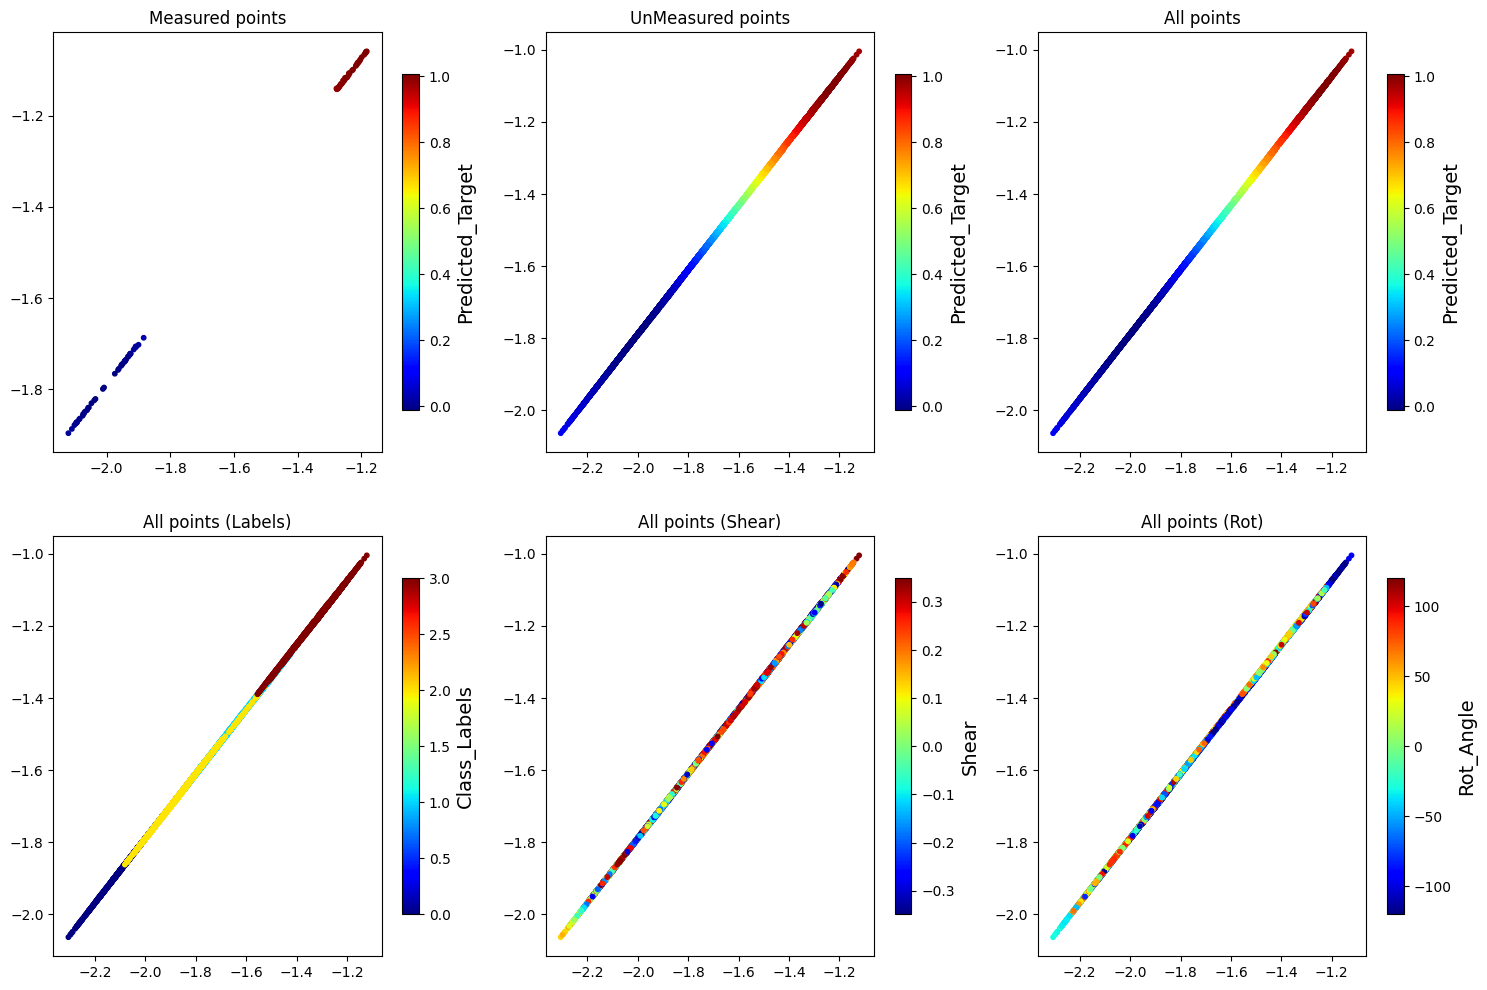

In [ ]:
embeded_train3 = dkl_BO_3.embed(X3_train)  # Measured points
embeded_unmeasured3 = dkl_BO_3.embed(X3_unmeasured)  # Unmeasured points
embeded13 = dkl_BO_3.embed(X3)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train3[:, 1], embeded_train3[:, 0], s=10, c = predmean_train3, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured3[:, 1], embeded_unmeasured3[:, 0], s=10,
                c = predmean_unmeas3, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = predmean13, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# All hands as a function

Now, let's make the problem slightly more interesting. We define the function that puts a number to the hand (meaning hearts are 1, diamonds are 2, etc). This is not a very good way of doing it - since these are cathegorical variables. But as mentioned before, we consider card images as a toy model for more complex scenarios (molecules, process trajectories, etc). So, let's experiment!

In [ ]:
X4 = np.copy(X)
targets4 = np.copy((labels_all))

rng_key_4, rng_key_predict_4 = gpax.utils.get_keys()
dkl_4 = gpax.viDKL(900, 2, 'RBF')
dkl_4.fit(rng_key_4, X, targets4)

100%|██████████| 1000/1000 [03:45<00:00,  4.44it/s, init loss: 72172.6567, avg. loss [951-1000]: 46226.2532]



Inferred GP kernel parameters
k_length         [4.4678 3.6224]
k_scale          0.8139000000000001
noise            0.0088


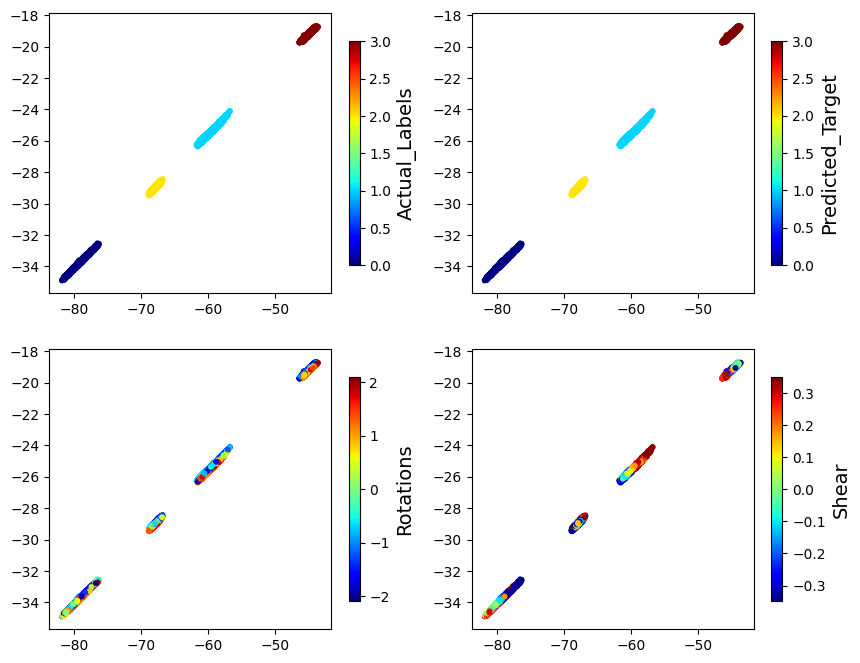

In [ ]:
embeded_4 = dkl_4.embed(X)
pred_mean4, pred_var4 = dkl_4.predict_in_batches(rng_key_predict_4, X, batch_size=batch_size_reconstruct)
pred_std4 = jnp.sqrt(pred_var4)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = pred_mean4, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

As you can see, our "card function" is well separated in the latent space. Interestingly, we can see the disentanglement of representations for rotations and shear within each cluster. 

In [ ]:
np.random.seed(0)
idx4 = np.random.choice(np.arange(len(X4)), size = init_num, replace = False)
X4_train = X4[idx4]
X4_unmeasured = np.delete(X4, idx4, axis=0)

indices_total_4 = np.arange(len(X))
indices_train_4 = indices_total_4[idx4]
y4_train = targets4[idx4]
indices_unmeasured_4 = np.delete(indices_total_4, idx4)

In [ ]:
exp_mean4, exp_std4 = [], []
dkl_mean4, dkl_std4 = [], []
embed_traj4 = []
traj_mean4, traj_std4 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key14, rng_key_predict14 = gpax.utils.get_keys()
    dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_4.fit(rng_key14, X4_train, y4_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean4.append(y_mean[id_next])
    exp_std4.append(y_std[id_next])
    
    x_next = X4_unmeasured[id_next]
    ind_next = indices_unmeasured_4[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean4.append(pred_mean4[ind_next])
    dkl_std4.append(pred_std4[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets4[ind_next]
    
    # Update training arrays
    X4_train = np.append(X4_train, x_next[None], axis=0)
    y4_train = np.append(y4_train, y_measured)
    X4_unmeasured = np.delete(X4_unmeasured, id_next, axis=0)
    indices_unmeasured_4 = np.delete(indices_unmeasured_4, id_next)
    
    embed_traj = dkl_BO_4.embed(X4_train)
    traj_m, traj_s = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_train, batch_size=batch_size_learn)
    
    embed_traj4.append(embed_traj)
    traj_mean4.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 465.19it/s, init loss: 60116.5994, avg. loss [951-1000]: 56946.0767]



Inferred GP kernel parameters
k_length         [0.599  0.5193]
k_scale          1.6289
noise            0.0188

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 443.42it/s, init loss: 60120.1791, avg. loss [951-1000]: 56934.5717]



Inferred GP kernel parameters
k_length         [0.5385 0.6315]
k_scale          1.619
noise            0.0233

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 434.75it/s, init loss: 60122.6098, avg. loss [951-1000]: 56946.3523]



Inferred GP kernel parameters
k_length         [0.8134 0.6733]
k_scale          1.6479000000000001
noise            0.021400000000000002

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 438.27it/s, init loss: 60126.1873, avg. loss [951-1000]: 56947.5912]



Inferred GP kernel parameters
k_length         [0.6246 0.5789]
k_scale          1.4456
noise            0.020900000000000002

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 450.57it/s, init loss: 60128.1570, avg. loss [951-1000]: 56931.8094]



Inferred GP kernel parameters
k_length         [0.4894 0.6967]
k_scale          1.6082
noise            0.0166

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 443.88it/s, init loss: 60131.6792, avg. loss [951-1000]: 56967.3985]



Inferred GP kernel parameters
k_length         [0.598 0.612]
k_scale          1.5712000000000002
noise            0.023700000000000002

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 422.33it/s, init loss: 60135.2551, avg. loss [951-1000]: 56929.8294]



Inferred GP kernel parameters
k_length         [0.588  0.4861]
k_scale          1.669
noise            0.0177

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 438.97it/s, init loss: 60138.8270, avg. loss [951-1000]: 56930.4944]



Inferred GP kernel parameters
k_length         [0.5616 0.6824]
k_scale          1.6146
noise            0.020200000000000003

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 439.21it/s, init loss: 60141.3650, avg. loss [951-1000]: 56929.0706]



Inferred GP kernel parameters
k_length         [0.568 0.842]
k_scale          1.5879
noise            0.0181

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 440.47it/s, init loss: 60144.8027, avg. loss [951-1000]: 56951.6361]



Inferred GP kernel parameters
k_length         [0.4584 0.5668]
k_scale          1.6820000000000002
noise            0.020800000000000003

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 439.26it/s, init loss: 60146.0470, avg. loss [951-1000]: 56926.0553]



Inferred GP kernel parameters
k_length         [0.532  0.4803]
k_scale          1.7203000000000002
noise            0.0148

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 435.73it/s, init loss: 60149.4027, avg. loss [951-1000]: 56932.3348]



Inferred GP kernel parameters
k_length         [0.4685 0.5738]
k_scale          1.6704
noise            0.0155

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 444.45it/s, init loss: 60151.0635, avg. loss [951-1000]: 56934.4926]



Inferred GP kernel parameters
k_length         [0.6401 0.8911]
k_scale          1.5491000000000001
noise            0.016

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 440.76it/s, init loss: 60154.1999, avg. loss [951-1000]: 56926.9306]



Inferred GP kernel parameters
k_length         [0.6624 0.8028]
k_scale          1.3537000000000001
noise            0.0166

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 430.63it/s, init loss: 60157.5194, avg. loss [951-1000]: 56918.3486]



Inferred GP kernel parameters
k_length         [0.5041 0.5688]
k_scale          1.7757
noise            0.0131

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 444.95it/s, init loss: 60159.7973, avg. loss [951-1000]: 56924.7397]



Inferred GP kernel parameters
k_length         [0.4346 0.6142]
k_scale          1.6602000000000001
noise            0.014400000000000001

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 438.43it/s, init loss: 60161.1639, avg. loss [951-1000]: 56933.6395]



Inferred GP kernel parameters
k_length         [0.9732 1.5962]
k_scale          1.355
noise            0.0146

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 446.06it/s, init loss: 60164.2865, avg. loss [951-1000]: 57011.1286]



Inferred GP kernel parameters
k_length         [0.407  0.5042]
k_scale          2.2057
noise            0.0222

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 440.38it/s, init loss: 60165.6139, avg. loss [951-1000]: 56912.8563]



Inferred GP kernel parameters
k_length         [0.655 0.545]
k_scale          1.661
noise            0.012

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 443.71it/s, init loss: 60169.1504, avg. loss [951-1000]: 56932.9168]



Inferred GP kernel parameters
k_length         [0.8588 0.7241]
k_scale          1.4381000000000002
noise            0.0114

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 439.08it/s, init loss: 60172.6939, avg. loss [951-1000]: 56937.9500]



Inferred GP kernel parameters
k_length         [0.8556 1.0156]
k_scale          1.4789
noise            0.0155

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 438.51it/s, init loss: 60176.2073, avg. loss [951-1000]: 56919.0101]



Inferred GP kernel parameters
k_length         [0.9932 1.123 ]
k_scale          1.5306000000000002
noise            0.0137

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 437.24it/s, init loss: 60179.5312, avg. loss [951-1000]: 56905.8420]



Inferred GP kernel parameters
k_length         [0.525  0.4387]
k_scale          1.6606
noise            0.0109

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 441.21it/s, init loss: 60182.0162, avg. loss [951-1000]: 56933.9663]



Inferred GP kernel parameters
k_length         [0.7492 0.9549]
k_scale          1.6966
noise            0.0167

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 432.91it/s, init loss: 60185.5339, avg. loss [951-1000]: 56908.6035]



Inferred GP kernel parameters
k_length         [0.5354 0.5629]
k_scale          1.6031
noise            0.0118

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 426.62it/s, init loss: 60188.8293, avg. loss [951-1000]: 56915.3793]



Inferred GP kernel parameters
k_length         [0.9251 0.8127]
k_scale          1.492
noise            0.014100000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 428.09it/s, init loss: 60190.9379, avg. loss [951-1000]: 56956.4856]



Inferred GP kernel parameters
k_length         [0.9128 1.0433]
k_scale          1.7582
noise            0.0201

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 441.24it/s, init loss: 60192.2731, avg. loss [951-1000]: 56903.6127]



Inferred GP kernel parameters
k_length         [0.6301 0.7482]
k_scale          1.6554
noise            0.0105

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 431.34it/s, init loss: 60194.0719, avg. loss [951-1000]: 56935.3627]



Inferred GP kernel parameters
k_length         [0.9846 0.8737]
k_scale          1.5185000000000002
noise            0.0134

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 435.68it/s, init loss: 60195.3515, avg. loss [951-1000]: 56911.0269]



Inferred GP kernel parameters
k_length         [1.0977 0.9045]
k_scale          1.3075
noise            0.015300000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 438.62it/s, init loss: 60196.5957, avg. loss [951-1000]: 56906.7244]



Inferred GP kernel parameters
k_length         [1.2223 1.1514]
k_scale          1.5241
noise            0.012100000000000001

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 428.74it/s, init loss: 60199.7983, avg. loss [951-1000]: 56900.5176]



Inferred GP kernel parameters
k_length         [0.9395 1.1511]
k_scale          1.5137
noise            0.0115

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 433.21it/s, init loss: 60202.6673, avg. loss [951-1000]: 56930.7028]



Inferred GP kernel parameters
k_length         [2.0508 1.4778]
k_scale          1.3814
noise            0.013600000000000001

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 443.07it/s, init loss: 60204.8606, avg. loss [951-1000]: 56938.2719]



Inferred GP kernel parameters
k_length         [0.9862 1.1498]
k_scale          1.4505000000000001
noise            0.0132

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 428.24it/s, init loss: 60208.3599, avg. loss [951-1000]: 56922.5835]



Inferred GP kernel parameters
k_length         [1.6292 1.7225]
k_scale          1.5059
noise            0.0154

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 438.89it/s, init loss: 60209.6041, avg. loss [951-1000]: 56904.8904]



Inferred GP kernel parameters
k_length         [2.1451 1.3997]
k_scale          1.4055
noise            0.013000000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 430.42it/s, init loss: 60211.8774, avg. loss [951-1000]: 56905.9095]



Inferred GP kernel parameters
k_length         [1.5239 1.7602]
k_scale          1.5059
noise            0.0129

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 433.52it/s, init loss: 60214.2599, avg. loss [951-1000]: 56896.1452]



Inferred GP kernel parameters
k_length         [0.816  0.7879]
k_scale          1.6558000000000002
noise            0.012

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 427.59it/s, init loss: 60217.8519, avg. loss [951-1000]: 56897.1566]



Inferred GP kernel parameters
k_length         [2.2631 1.6505]
k_scale          1.3261
noise            0.0112

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 429.33it/s, init loss: 60221.0284, avg. loss [951-1000]: 56934.5231]



Inferred GP kernel parameters
k_length         [1.98   2.0629]
k_scale          1.4047
noise            0.013600000000000001

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 428.72it/s, init loss: 60223.9808, avg. loss [951-1000]: 56966.2096]



Inferred GP kernel parameters
k_length         [1.1447 1.1481]
k_scale          1.4915
noise            0.0128

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 419.64it/s, init loss: 60225.2251, avg. loss [951-1000]: 56885.0899]



Inferred GP kernel parameters
k_length         [0.77   0.8434]
k_scale          1.5078
noise            0.0097

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 425.20it/s, init loss: 60227.5107, avg. loss [951-1000]: 56906.8625]



Inferred GP kernel parameters
k_length         [1.7848 1.5439]
k_scale          1.3695000000000002
noise            0.0117

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 413.74it/s, init loss: 60231.1013, avg. loss [951-1000]: 56911.1190]



Inferred GP kernel parameters
k_length         [1.4292 1.1095]
k_scale          1.4535
noise            0.0108

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 420.63it/s, init loss: 60232.3511, avg. loss [951-1000]: 56905.7323]



Inferred GP kernel parameters
k_length         [2.2408 1.9338]
k_scale          1.4708
noise            0.0122

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 410.62it/s, init loss: 60235.5125, avg. loss [951-1000]: 56893.1042]



Inferred GP kernel parameters
k_length         [2.6846 1.397 ]
k_scale          1.3834
noise            0.0115

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 412.92it/s, init loss: 60237.7253, avg. loss [951-1000]: 56946.3840]



Inferred GP kernel parameters
k_length         [2.1038 2.7624]
k_scale          1.4931
noise            0.0137

Step 48


100%|██████████| 1000/1000 [00:03<00:00, 296.99it/s, init loss: 60241.1078, avg. loss [951-1000]: 56913.1497]



Inferred GP kernel parameters
k_length         [0.8635 0.9164]
k_scale          1.6609
noise            0.0111

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 413.31it/s, init loss: 60244.1611, avg. loss [951-1000]: 56921.6301]



Inferred GP kernel parameters
k_length         [1.9064 1.7748]
k_scale          1.4551
noise            0.0134

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 433.36it/s, init loss: 60247.7520, avg. loss [951-1000]: 56887.9460]



Inferred GP kernel parameters
k_length         [1.7713 1.5504]
k_scale          1.3768
noise            0.0112

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 430.83it/s, init loss: 60250.7434, avg. loss [951-1000]: 56888.3831]



Inferred GP kernel parameters
k_length         [1.4887 1.5921]
k_scale          1.4547
noise            0.0099

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 441.09it/s, init loss: 60252.8411, avg. loss [951-1000]: 56882.4801]



Inferred GP kernel parameters
k_length         [1.5191 1.23  ]
k_scale          1.4907000000000001
noise            0.0105

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 429.13it/s, init loss: 60255.5917, avg. loss [951-1000]: 56935.3193]



Inferred GP kernel parameters
k_length         [2.777  2.7175]
k_scale          1.4073
noise            0.0158

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 439.30it/s, init loss: 60256.8359, avg. loss [951-1000]: 56867.2902]



Inferred GP kernel parameters
k_length         [1.0543 1.0807]
k_scale          1.5015
noise            0.009300000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 435.51it/s, init loss: 60259.3289, avg. loss [951-1000]: 56873.6442]



Inferred GP kernel parameters
k_length         [1.9117 1.6537]
k_scale          1.4109
noise            0.0097

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 435.78it/s, init loss: 60262.1725, avg. loss [951-1000]: 56913.3551]



Inferred GP kernel parameters
k_length         [2.1893 2.6627]
k_scale          1.3804
noise            0.0119

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 432.62it/s, init loss: 60265.7644, avg. loss [951-1000]: 56886.6557]



Inferred GP kernel parameters
k_length         [2.0592 1.817 ]
k_scale          1.447
noise            0.0095

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 442.53it/s, init loss: 60268.9534, avg. loss [951-1000]: 56892.9917]



Inferred GP kernel parameters
k_length         [3.2187 3.2502]
k_scale          1.5375
noise            0.0123

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 441.56it/s, init loss: 60272.2879, avg. loss [951-1000]: 56878.0348]



Inferred GP kernel parameters
k_length         [2.3032 1.7224]
k_scale          1.3258
noise            0.011300000000000001

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 436.90it/s, init loss: 60274.7926, avg. loss [951-1000]: 56887.3972]



Inferred GP kernel parameters
k_length         [1.5114 1.2111]
k_scale          1.4861
noise            0.011300000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 429.89it/s, init loss: 60276.3376, avg. loss [951-1000]: 56885.3280]



Inferred GP kernel parameters
k_length         [3.1038 1.7971]
k_scale          1.4412
noise            0.0123

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 438.58it/s, init loss: 60278.5482, avg. loss [951-1000]: 56937.9109]



Inferred GP kernel parameters
k_length         [0.9961 0.8982]
k_scale          1.5677
noise            0.0105

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 445.54it/s, init loss: 60279.8494, avg. loss [951-1000]: 56885.9525]



Inferred GP kernel parameters
k_length         [1.8177 1.6813]
k_scale          1.3646
noise            0.01

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 445.14it/s, init loss: 60283.1336, avg. loss [951-1000]: 56904.5461]



Inferred GP kernel parameters
k_length         [2.7318 2.355 ]
k_scale          1.4260000000000002
noise            0.011300000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 435.49it/s, init loss: 60284.7797, avg. loss [951-1000]: 56874.2785]



Inferred GP kernel parameters
k_length         [1.445  1.6492]
k_scale          1.3873
noise            0.009600000000000001

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 444.17it/s, init loss: 60286.8508, avg. loss [951-1000]: 56872.7811]



Inferred GP kernel parameters
k_length         [2.2542 1.496 ]
k_scale          1.3679000000000001
noise            0.0097

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 435.77it/s, init loss: 60289.6315, avg. loss [951-1000]: 56907.8466]



Inferred GP kernel parameters
k_length         [3.0847 2.4231]
k_scale          1.3277
noise            0.0132

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 437.55it/s, init loss: 60292.2170, avg. loss [951-1000]: 56875.6739]



Inferred GP kernel parameters
k_length         [2.2053 2.4167]
k_scale          1.4086
noise            0.010400000000000001

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 436.51it/s, init loss: 60294.3341, avg. loss [951-1000]: 56845.5244]



Inferred GP kernel parameters
k_length         [1.5046 1.2515]
k_scale          1.3704
noise            0.008700000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 438.07it/s, init loss: 60297.1715, avg. loss [951-1000]: 56863.2110]



Inferred GP kernel parameters
k_length         [1.6261 1.4604]
k_scale          1.3449
noise            0.010100000000000001

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 431.84it/s, init loss: 60298.6557, avg. loss [951-1000]: 56867.8573]



Inferred GP kernel parameters
k_length         [2.6513 2.417 ]
k_scale          1.2950000000000002
noise            0.011000000000000001

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 441.70it/s, init loss: 60301.0158, avg. loss [951-1000]: 56917.4101]



Inferred GP kernel parameters
k_length         [1.9519 2.0037]
k_scale          1.4314
noise            0.0123

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 433.77it/s, init loss: 60303.5109, avg. loss [951-1000]: 56861.3215]



Inferred GP kernel parameters
k_length         [2.3736 2.164 ]
k_scale          1.3041
noise            0.0118

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 441.33it/s, init loss: 60305.4119, avg. loss [951-1000]: 56896.0565]



Inferred GP kernel parameters
k_length         [1.9401 2.1327]
k_scale          1.5285
noise            0.0132

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 430.84it/s, init loss: 60309.0027, avg. loss [951-1000]: 56881.4108]



Inferred GP kernel parameters
k_length         [2.7868 2.1538]
k_scale          1.3465
noise            0.0117

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 434.50it/s, init loss: 60310.4494, avg. loss [951-1000]: 56906.1424]



Inferred GP kernel parameters
k_length         [2.4309 1.8252]
k_scale          1.3611
noise            0.012

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 439.82it/s, init loss: 60312.5445, avg. loss [951-1000]: 56872.8369]



Inferred GP kernel parameters
k_length         [4.5363 2.1312]
k_scale          1.3377000000000001
noise            0.0123

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 431.83it/s, init loss: 60316.1494, avg. loss [951-1000]: 56861.6034]



Inferred GP kernel parameters
k_length         [1.8229 2.2484]
k_scale          1.3781
noise            0.0097

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 416.28it/s, init loss: 60319.8014, avg. loss [951-1000]: 56875.2085]



Inferred GP kernel parameters
k_length         [4.8172 3.0721]
k_scale          1.2995
noise            0.013300000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 436.36it/s, init loss: 60321.2528, avg. loss [951-1000]: 56848.7300]



Inferred GP kernel parameters
k_length         [3.8217 2.031 ]
k_scale          1.4147
noise            0.010100000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 435.41it/s, init loss: 60322.6441, avg. loss [951-1000]: 56856.8879]



Inferred GP kernel parameters
k_length         [1.5316 1.6092]
k_scale          1.5044000000000002
noise            0.011300000000000001

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 432.86it/s, init loss: 60323.8883, avg. loss [951-1000]: 56851.9704]



Inferred GP kernel parameters
k_length         [2.6218 1.9735]
k_scale          1.2923
noise            0.0108

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 429.10it/s, init loss: 60326.3736, avg. loss [951-1000]: 56870.2460]



Inferred GP kernel parameters
k_length         [4.8286 3.0185]
k_scale          1.2782
noise            0.0111

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 427.52it/s, init loss: 60329.9862, avg. loss [951-1000]: 56908.7193]



Inferred GP kernel parameters
k_length         [2.5819 2.6355]
k_scale          1.4356
noise            0.0106

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 438.43it/s, init loss: 60331.2656, avg. loss [951-1000]: 56880.4642]



Inferred GP kernel parameters
k_length         [3.1112 3.5915]
k_scale          1.2504
noise            0.012100000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 435.35it/s, init loss: 60334.4182, avg. loss [951-1000]: 56862.0927]



Inferred GP kernel parameters
k_length         [2.7249 4.8358]
k_scale          1.4101000000000001
noise            0.0103

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 429.32it/s, init loss: 60336.7781, avg. loss [951-1000]: 56883.5796]



Inferred GP kernel parameters
k_length         [4.1026 5.0821]
k_scale          1.4336
noise            0.012400000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 430.30it/s, init loss: 60338.1930, avg. loss [951-1000]: 56860.9845]



Inferred GP kernel parameters
k_length         [4.4495 2.7463]
k_scale          1.3454000000000002
noise            0.0123

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 430.52it/s, init loss: 60340.5107, avg. loss [951-1000]: 56942.8241]



Inferred GP kernel parameters
k_length         [1.5473 1.2928]
k_scale          1.4596
noise            0.0111

Step 90


100%|██████████| 1000/1000 [00:03<00:00, 276.03it/s, init loss: 60341.8534, avg. loss [951-1000]: 56932.3007]



Inferred GP kernel parameters
k_length         [3.0194 3.9153]
k_scale          1.3354000000000001
noise            0.0135

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 437.16it/s, init loss: 60343.2654, avg. loss [951-1000]: 56912.8440]



Inferred GP kernel parameters
k_length         [5.9746 3.2629]
k_scale          1.3334000000000001
noise            0.011600000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 425.01it/s, init loss: 60345.5568, avg. loss [951-1000]: 56852.9559]



Inferred GP kernel parameters
k_length         [2.4722 2.6553]
k_scale          1.4046
noise            0.0098

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 431.03it/s, init loss: 60348.0933, avg. loss [951-1000]: 56868.9029]



Inferred GP kernel parameters
k_length         [2.3297 3.3014]
k_scale          1.3804
noise            0.010100000000000001

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 422.81it/s, init loss: 60351.5306, avg. loss [951-1000]: 56855.5278]



Inferred GP kernel parameters
k_length         [2.4186 2.854 ]
k_scale          1.4619
noise            0.0105

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 432.75it/s, init loss: 60352.7907, avg. loss [951-1000]: 56876.2779]



Inferred GP kernel parameters
k_length         [6.4604 3.9438]
k_scale          1.2563
noise            0.012

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 430.37it/s, init loss: 60355.2615, avg. loss [951-1000]: 56854.0950]



Inferred GP kernel parameters
k_length         [3.3191 3.0712]
k_scale          1.2996
noise            0.0115

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 432.05it/s, init loss: 60358.8544, avg. loss [951-1000]: 56846.3872]



Inferred GP kernel parameters
k_length         [2.515  2.4258]
k_scale          1.2632
noise            0.0117

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 435.99it/s, init loss: 60360.1912, avg. loss [951-1000]: 56842.3392]



Inferred GP kernel parameters
k_length         [2.829  2.1398]
k_scale          1.3511
noise            0.009600000000000001

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 430.03it/s, init loss: 60363.0869, avg. loss [951-1000]: 56960.5794]



Inferred GP kernel parameters
k_length         [2.4457 1.4881]
k_scale          1.6899000000000002
noise            0.0128

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 422.81it/s, init loss: 60364.5896, avg. loss [951-1000]: 56850.0044]



Inferred GP kernel parameters
k_length         [1.7858 2.0766]
k_scale          1.3677000000000001
noise            0.0102


In [ ]:
allsuites_results = {}
allsuites_results['X_train'] = X4_train
allsuites_results['y_train'] = y4_train
allsuites_results['X_unmeasured'] = X4_unmeasured
allsuites_results['indices_unmeasured'] = indices_unmeasured_4
allsuites_results['dkl_mean'] = dkl_mean4
allsuites_results['dkl_std'] = dkl_std4
allsuites_results['exp_mean'] = exp_mean4
allsuites_results['exp_std'] = exp_std4
allsuites_results['traj_mean'] = traj_mean4
allsuites_results['traj_std'] = traj_std4
allsuites_results['embed_traj'] = embed_traj4

with open('allsuites_results.pickle', 'wb') as handle:
    pickle.dump(allsuites_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('allsuites_results.pickle', 'rb') as f:
    allsuites_results = pickle.load(f)

X4_train = allsuites_results['X_train']
y4_train = allsuites_results['y_train']
X4_unmeasured = allsuites_results['X_unmeasured']
indices_unmeasured_4 = allsuites_results['indices_unmeasured']
dkl_mean4 = allsuites_results['dkl_mean']
dkl_std4 = allsuites_results['dkl_std']
exp_mean4 = allsuites_results['exp_mean'] 
exp_std4 = allsuites_results['exp_std']
traj_mean4 = allsuites_results['traj_mean']
traj_std4 = allsuites_results['traj_std']
embed_traj4 = allsuites_results['embed_traj']

In [ ]:
rng_key14, rng_key_predict14 = gpax.utils.get_keys()
dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_4.fit(rng_key14, X4_train, y4_train)

predmean_train4, predstd_train4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_train, batch_size=batch_size_learn)
predmean_unmeas4, predstd_unmeas4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_unmeasured, batch_size=batch_size_reconstruct)
predmean14, predstd14 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 434.23it/s, init loss: 60365.8427, avg. loss [951-1000]: 56874.1036]



Inferred GP kernel parameters
k_length         [4.1023 3.6555]
k_scale          1.3232000000000002
noise            0.0112


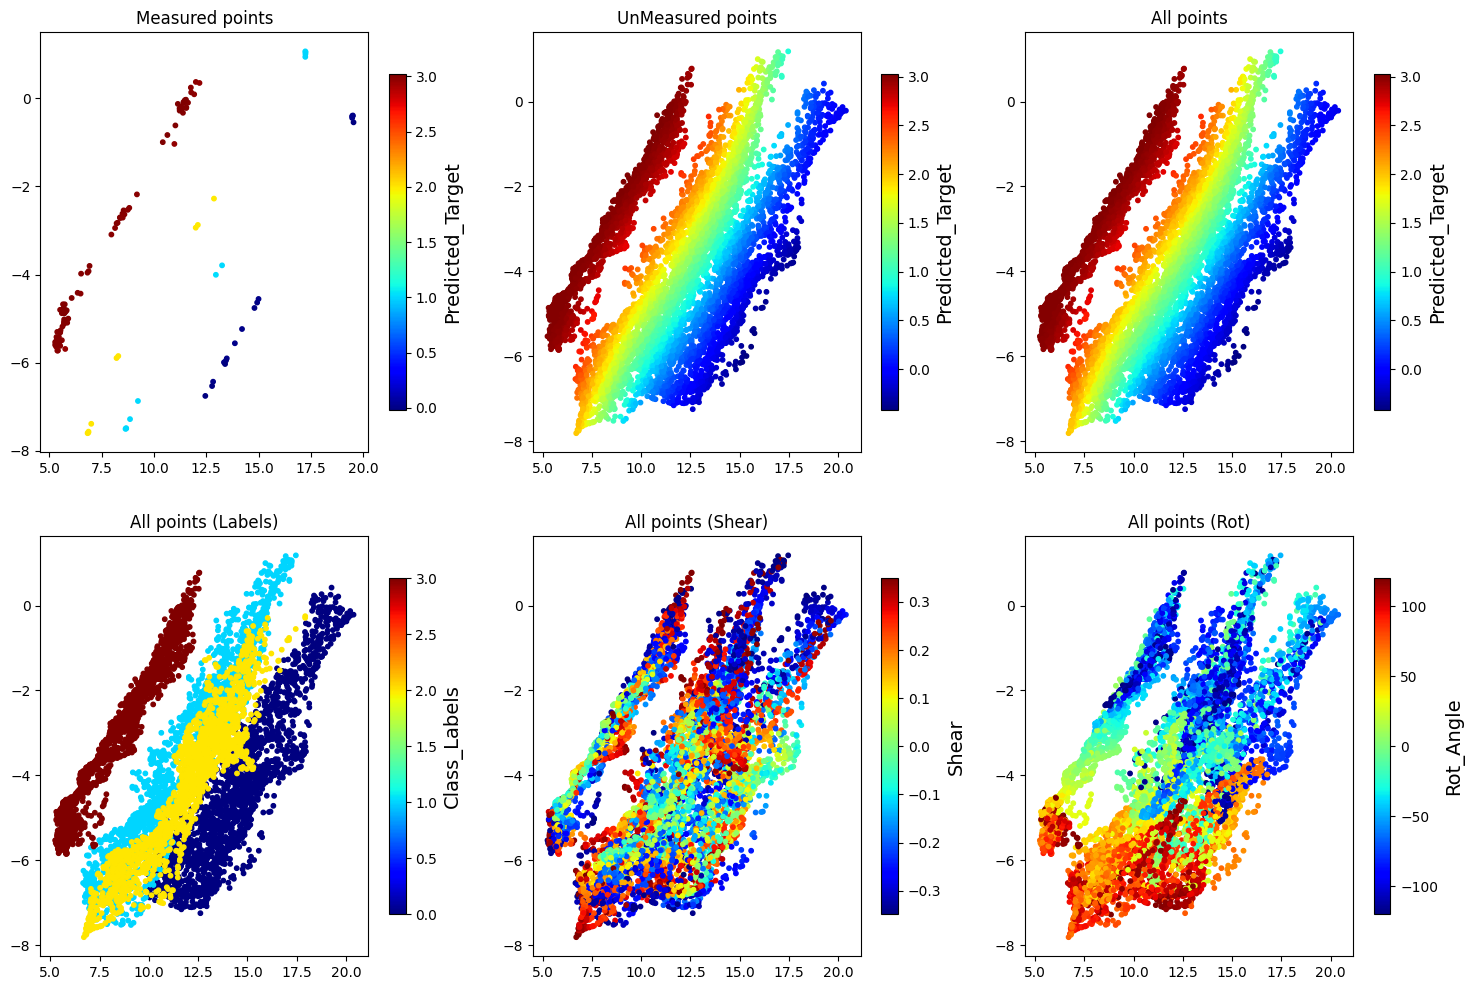

In [ ]:
embeded_train4 = dkl_BO_4.embed(X4_train)  # Measured points
embeded_unmeasured4 = dkl_BO_4.embed(X4_unmeasured)  # Unmeasured points
embeded14 = dkl_BO_4.embed(X4)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train4[:, 1], embeded_train4[:, 0], s=10, c = predmean_train4, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured4[:, 1], embeded_unmeasured4[:, 0], s=10,
                c = predmean_unmeas4, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = predmean14, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

ANd now you can see how the DKL learned the "card function" from lcubs to diamonds. Diamonds are set apart (as can be expected), spades and hearts are pretty close. Note that Rotational angles got disentangled for all hands. 

# Card parameters as a function

Now, let's run the same analysis assuming that we want to learn the rotation or shear, but at teh same time we do not care about the specific hands. What happens then?

## Shear

In [ ]:
X5 = np.copy(X)
targets5 = np.copy(shears_all[:,0])

rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(900, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s, init loss: 68841.5697, avg. loss [951-1000]: 45821.7993]



Inferred GP kernel parameters
k_length         [4.1387 2.7963]
k_scale          0.1948
noise            0.0083


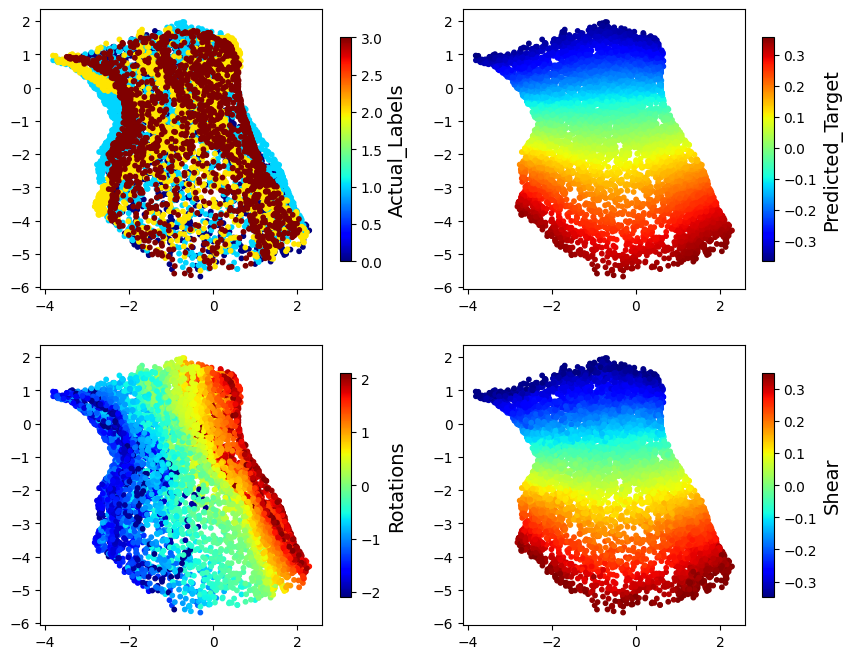

In [ ]:
embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now we see the DKL latent space when our goal was to learn the shear. Predicted target and ground truth look almost the same. Note that the hands overlap (we were not interested in them), and as a bonus we got rotations disentangled in direction perpendicular to the shear. 

In [ ]:
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = init_num, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [ ]:
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])
    
    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(pred_mean5[ind_next])
    dkl_std5.append(pred_std5[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets5[ind_next]
    
    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)
    
    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=batch_size_learn)
    
    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 460.47it/s, init loss: 60100.1168, avg. loss [951-1000]: 56923.3976]



Inferred GP kernel parameters
k_length         [0.3667 0.3886]
k_scale          0.2778
noise            0.0146

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 469.57it/s, init loss: 60101.3760, avg. loss [951-1000]: 56921.1632]



Inferred GP kernel parameters
k_length         [0.3678 0.3513]
k_scale          0.28550000000000003
noise            0.013900000000000001

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 457.92it/s, init loss: 60102.6414, avg. loss [951-1000]: 56919.6532]



Inferred GP kernel parameters
k_length         [0.3593 0.371 ]
k_scale          0.2786
noise            0.013600000000000001

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 463.67it/s, init loss: 60103.9172, avg. loss [951-1000]: 56918.2695]



Inferred GP kernel parameters
k_length         [0.3678 0.3549]
k_scale          0.28850000000000003
noise            0.0131

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 469.38it/s, init loss: 60105.1412, avg. loss [951-1000]: 56917.9444]



Inferred GP kernel parameters
k_length         [0.3586 0.3852]
k_scale          0.28650000000000003
noise            0.0129

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 466.92it/s, init loss: 60106.3821, avg. loss [951-1000]: 56916.2016]



Inferred GP kernel parameters
k_length         [0.3699 0.3646]
k_scale          0.28550000000000003
noise            0.0126

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 458.71it/s, init loss: 60107.6523, avg. loss [951-1000]: 56914.6998]



Inferred GP kernel parameters
k_length         [0.3662 0.3543]
k_scale          0.2906
noise            0.0123

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 453.36it/s, init loss: 60108.9268, avg. loss [951-1000]: 56924.2886]



Inferred GP kernel parameters
k_length         [0.4279 0.4   ]
k_scale          0.20400000000000001
noise            0.0132

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 459.37it/s, init loss: 60110.1830, avg. loss [951-1000]: 56912.0011]



Inferred GP kernel parameters
k_length         [0.3665 0.3698]
k_scale          0.2864
noise            0.0119

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 468.55it/s, init loss: 60111.4505, avg. loss [951-1000]: 56914.1595]



Inferred GP kernel parameters
k_length         [0.4379 0.4129]
k_scale          0.2664
noise            0.0119

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 463.99it/s, init loss: 60112.7143, avg. loss [951-1000]: 56909.6159]



Inferred GP kernel parameters
k_length         [0.3676 0.365 ]
k_scale          0.2949
noise            0.0115

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 460.34it/s, init loss: 60113.9876, avg. loss [951-1000]: 56908.3655]



Inferred GP kernel parameters
k_length         [0.3502 0.3668]
k_scale          0.2556
noise            0.0119

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 465.05it/s, init loss: 60115.2522, avg. loss [951-1000]: 56910.5634]



Inferred GP kernel parameters
k_length         [0.3999 0.3694]
k_scale          0.27340000000000003
noise            0.0117

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 446.60it/s, init loss: 60116.5217, avg. loss [951-1000]: 56905.4225]



Inferred GP kernel parameters
k_length         [0.3483 0.3668]
k_scale          0.2952
noise            0.011000000000000001

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 459.04it/s, init loss: 60117.7663, avg. loss [951-1000]: 56906.1711]



Inferred GP kernel parameters
k_length         [0.3656 0.389 ]
k_scale          0.28600000000000003
noise            0.0112

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 460.02it/s, init loss: 60118.9938, avg. loss [951-1000]: 56907.1210]



Inferred GP kernel parameters
k_length         [0.3924 0.4071]
k_scale          0.28040000000000004
noise            0.0112

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 439.20it/s, init loss: 60120.2691, avg. loss [951-1000]: 56903.2101]



Inferred GP kernel parameters
k_length         [0.373  0.3812]
k_scale          0.2867
noise            0.011000000000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 457.61it/s, init loss: 60121.5303, avg. loss [951-1000]: 56907.8654]



Inferred GP kernel parameters
k_length         [0.4024 0.4994]
k_scale          0.2553
noise            0.0111

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 458.95it/s, init loss: 60122.7635, avg. loss [951-1000]: 56900.1905]



Inferred GP kernel parameters
k_length         [0.3752 0.3721]
k_scale          0.2889
noise            0.010400000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 446.92it/s, init loss: 60124.0307, avg. loss [951-1000]: 56900.6978]



Inferred GP kernel parameters
k_length         [0.4243 0.3867]
k_scale          0.2775
noise            0.010700000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 448.00it/s, init loss: 60125.2622, avg. loss [951-1000]: 56896.2180]



Inferred GP kernel parameters
k_length         [0.3678 0.3679]
k_scale          0.2903
noise            0.0103

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 446.44it/s, init loss: 60126.4726, avg. loss [951-1000]: 56902.2571]



Inferred GP kernel parameters
k_length         [0.3498 0.3407]
k_scale          0.21860000000000002
noise            0.011000000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 445.44it/s, init loss: 60127.6673, avg. loss [951-1000]: 56896.9087]



Inferred GP kernel parameters
k_length         [0.3966 0.404 ]
k_scale          0.28600000000000003
noise            0.0103

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 451.99it/s, init loss: 60128.9434, avg. loss [951-1000]: 56892.9429]



Inferred GP kernel parameters
k_length         [0.4064 0.396 ]
k_scale          0.2823
noise            0.0103

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 440.33it/s, init loss: 60130.2187, avg. loss [951-1000]: 56891.0664]



Inferred GP kernel parameters
k_length         [0.3656 0.3679]
k_scale          0.29450000000000004
noise            0.010100000000000001

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 444.67it/s, init loss: 60131.4838, avg. loss [951-1000]: 56889.1208]



Inferred GP kernel parameters
k_length         [0.3453 0.3679]
k_scale          0.2948
noise            0.01

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 432.51it/s, init loss: 60132.7525, avg. loss [951-1000]: 56888.4240]



Inferred GP kernel parameters
k_length         [0.3713 0.3679]
k_scale          0.2938
noise            0.0099

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 449.35it/s, init loss: 60134.0101, avg. loss [951-1000]: 56897.9353]



Inferred GP kernel parameters
k_length         [0.4341 0.4496]
k_scale          0.25270000000000004
noise            0.010400000000000001

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 452.67it/s, init loss: 60135.2822, avg. loss [951-1000]: 56889.5307]



Inferred GP kernel parameters
k_length         [0.4657 0.4601]
k_scale          0.2645
noise            0.01

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 452.25it/s, init loss: 60136.4467, avg. loss [951-1000]: 56886.6413]



Inferred GP kernel parameters
k_length         [0.3996 0.3864]
k_scale          0.27540000000000003
noise            0.010100000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 444.09it/s, init loss: 60137.7047, avg. loss [951-1000]: 56890.4421]



Inferred GP kernel parameters
k_length         [0.3196 0.3679]
k_scale          0.2006
noise            0.0108

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 440.72it/s, init loss: 60138.9621, avg. loss [951-1000]: 56894.2827]



Inferred GP kernel parameters
k_length         [0.3791 0.3799]
k_scale          0.21330000000000002
noise            0.0106

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 430.84it/s, init loss: 60140.1474, avg. loss [951-1000]: 56882.1027]



Inferred GP kernel parameters
k_length         [0.3696 0.3747]
k_scale          0.27240000000000003
noise            0.01

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 440.35it/s, init loss: 60141.4066, avg. loss [951-1000]: 56881.6836]



Inferred GP kernel parameters
k_length         [0.3754 0.3679]
k_scale          0.2685
noise            0.0102

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 443.69it/s, init loss: 60142.6559, avg. loss [951-1000]: 56886.4939]



Inferred GP kernel parameters
k_length         [0.3354 0.3679]
k_scale          0.20140000000000002
noise            0.010700000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 444.26it/s, init loss: 60143.8568, avg. loss [951-1000]: 56877.7113]



Inferred GP kernel parameters
k_length         [0.3877 0.3927]
k_scale          0.2702
noise            0.0099

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 430.94it/s, init loss: 60145.0510, avg. loss [951-1000]: 56884.8403]



Inferred GP kernel parameters
k_length         [0.414  0.4151]
k_scale          0.23750000000000002
noise            0.0109

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 447.69it/s, init loss: 60146.3254, avg. loss [951-1000]: 56883.9539]



Inferred GP kernel parameters
k_length         [0.3369 0.3721]
k_scale          0.2318
noise            0.010400000000000001

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 439.87it/s, init loss: 60147.5998, avg. loss [951-1000]: 56878.0973]



Inferred GP kernel parameters
k_length         [0.3492 0.368 ]
k_scale          0.2757
noise            0.0098

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 436.45it/s, init loss: 60148.8596, avg. loss [951-1000]: 56872.5536]



Inferred GP kernel parameters
k_length         [0.4144 0.3998]
k_scale          0.26180000000000003
noise            0.009600000000000001

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 425.17it/s, init loss: 60150.0966, avg. loss [951-1000]: 56876.6706]



Inferred GP kernel parameters
k_length         [0.4526 0.498 ]
k_scale          0.2124
noise            0.010400000000000001

Step 42


100%|██████████| 1000/1000 [00:03<00:00, 260.02it/s, init loss: 60151.3142, avg. loss [951-1000]: 56875.6168]



Inferred GP kernel parameters
k_length         [0.3634 0.3466]
k_scale          0.2675
noise            0.01

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 437.22it/s, init loss: 60152.5845, avg. loss [951-1000]: 56869.0232]



Inferred GP kernel parameters
k_length         [0.3774 0.3683]
k_scale          0.2595
noise            0.0097

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 454.13it/s, init loss: 60153.8584, avg. loss [951-1000]: 56885.5744]



Inferred GP kernel parameters
k_length         [0.3447 0.3797]
k_scale          0.1751
noise            0.011000000000000001

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 442.09it/s, init loss: 60155.0613, avg. loss [951-1000]: 56873.7288]



Inferred GP kernel parameters
k_length         [0.3646 0.3578]
k_scale          0.2447
noise            0.01

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 442.37it/s, init loss: 60156.3320, avg. loss [951-1000]: 56869.8078]



Inferred GP kernel parameters
k_length         [0.44  0.543]
k_scale          0.2325
noise            0.0099

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 440.67it/s, init loss: 60157.6031, avg. loss [951-1000]: 56864.2261]



Inferred GP kernel parameters
k_length         [0.3742 0.378 ]
k_scale          0.2569
noise            0.0095

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 432.40it/s, init loss: 60158.8805, avg. loss [951-1000]: 56872.3389]



Inferred GP kernel parameters
k_length         [0.3551 0.3925]
k_scale          0.1943
noise            0.0102

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 438.47it/s, init loss: 60160.0367, avg. loss [951-1000]: 56862.8720]



Inferred GP kernel parameters
k_length         [0.3809 0.3676]
k_scale          0.2823
noise            0.0095

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 443.74it/s, init loss: 60161.2372, avg. loss [951-1000]: 56868.6169]



Inferred GP kernel parameters
k_length         [0.3925 0.368 ]
k_scale          0.22360000000000002
noise            0.010100000000000001

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 447.68it/s, init loss: 60162.5126, avg. loss [951-1000]: 56864.5112]



Inferred GP kernel parameters
k_length         [0.3433 0.3657]
k_scale          0.2124
noise            0.0098

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 450.75it/s, init loss: 60163.7864, avg. loss [951-1000]: 56860.7169]



Inferred GP kernel parameters
k_length         [0.3992 0.438 ]
k_scale          0.2389
noise            0.009600000000000001

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 426.46it/s, init loss: 60164.9665, avg. loss [951-1000]: 56869.6377]



Inferred GP kernel parameters
k_length         [0.3463 0.382 ]
k_scale          0.182
noise            0.0102

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 442.96it/s, init loss: 60166.2227, avg. loss [951-1000]: 56861.7474]



Inferred GP kernel parameters
k_length         [0.4056 0.4149]
k_scale          0.24860000000000002
noise            0.0097

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 443.72it/s, init loss: 60167.4632, avg. loss [951-1000]: 56861.5274]



Inferred GP kernel parameters
k_length         [0.3834 0.397 ]
k_scale          0.1791
noise            0.0103

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 434.74it/s, init loss: 60168.7121, avg. loss [951-1000]: 56860.9001]



Inferred GP kernel parameters
k_length         [0.323  0.3689]
k_scale          0.1993
noise            0.01

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 449.62it/s, init loss: 60169.9873, avg. loss [951-1000]: 56860.7673]



Inferred GP kernel parameters
k_length         [0.3479 0.3495]
k_scale          0.1738
noise            0.010100000000000001

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 440.21it/s, init loss: 60171.2274, avg. loss [951-1000]: 56853.4362]



Inferred GP kernel parameters
k_length         [0.3309 0.3655]
k_scale          0.224
noise            0.009600000000000001

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 441.04it/s, init loss: 60172.4853, avg. loss [951-1000]: 56855.3506]



Inferred GP kernel parameters
k_length         [0.4624 0.4662]
k_scale          0.23040000000000002
noise            0.0099

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 445.57it/s, init loss: 60173.7427, avg. loss [951-1000]: 56866.1751]



Inferred GP kernel parameters
k_length         [0.4275 0.546 ]
k_scale          0.1274
noise            0.0106

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 447.00it/s, init loss: 60175.0161, avg. loss [951-1000]: 56848.0546]



Inferred GP kernel parameters
k_length         [0.404 0.4  ]
k_scale          0.2492
noise            0.009600000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 446.77it/s, init loss: 60176.2861, avg. loss [951-1000]: 56864.8859]



Inferred GP kernel parameters
k_length         [0.4811 0.3992]
k_scale          0.15810000000000002
noise            0.0103

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 446.69it/s, init loss: 60177.5568, avg. loss [951-1000]: 56848.9442]



Inferred GP kernel parameters
k_length         [0.389  0.4612]
k_scale          0.2232
noise            0.0095

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 446.97it/s, init loss: 60178.7934, avg. loss [951-1000]: 56869.1223]



Inferred GP kernel parameters
k_length         [0.6183 0.522 ]
k_scale          0.12840000000000001
noise            0.010700000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 447.97it/s, init loss: 60180.0524, avg. loss [951-1000]: 56843.3616]



Inferred GP kernel parameters
k_length         [0.3335 0.3678]
k_scale          0.21930000000000002
noise            0.0094

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 440.23it/s, init loss: 60181.3020, avg. loss [951-1000]: 56842.7710]



Inferred GP kernel parameters
k_length         [0.459  0.4469]
k_scale          0.23170000000000002
noise            0.0095

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 443.09it/s, init loss: 60182.5126, avg. loss [951-1000]: 56844.0515]



Inferred GP kernel parameters
k_length         [0.3501 0.3895]
k_scale          0.2121
noise            0.0095

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 448.17it/s, init loss: 60183.7016, avg. loss [951-1000]: 56841.2376]



Inferred GP kernel parameters
k_length         [0.3521 0.3585]
k_scale          0.2066
noise            0.0095

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 432.44it/s, init loss: 60184.9674, avg. loss [951-1000]: 56854.0499]



Inferred GP kernel parameters
k_length         [0.4452 0.5316]
k_scale          0.19410000000000002
noise            0.0098

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 442.56it/s, init loss: 60186.2190, avg. loss [951-1000]: 56848.4120]



Inferred GP kernel parameters
k_length         [0.4328 0.4336]
k_scale          0.2116
noise            0.0095

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 447.07it/s, init loss: 60187.4145, avg. loss [951-1000]: 56830.9615]



Inferred GP kernel parameters
k_length         [0.4103 0.3757]
k_scale          0.28
noise            0.0092

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 442.75it/s, init loss: 60188.6569, avg. loss [951-1000]: 56833.9178]



Inferred GP kernel parameters
k_length         [0.4219 0.4148]
k_scale          0.234
noise            0.0094

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 441.43it/s, init loss: 60189.9175, avg. loss [951-1000]: 56837.9105]



Inferred GP kernel parameters
k_length         [0.4114 0.3798]
k_scale          0.1991
noise            0.0097

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 438.45it/s, init loss: 60191.1901, avg. loss [951-1000]: 56845.3294]



Inferred GP kernel parameters
k_length         [0.3979 0.3904]
k_scale          0.2323
noise            0.0098

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 444.80it/s, init loss: 60192.4255, avg. loss [951-1000]: 56831.2953]



Inferred GP kernel parameters
k_length         [0.3795 0.352 ]
k_scale          0.21130000000000002
noise            0.0094

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 440.57it/s, init loss: 60193.5772, avg. loss [951-1000]: 56858.7923]



Inferred GP kernel parameters
k_length         [0.4453 0.6557]
k_scale          0.1472
noise            0.0098

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 448.36it/s, init loss: 60194.8007, avg. loss [951-1000]: 56847.8175]



Inferred GP kernel parameters
k_length         [0.7811 0.7561]
k_scale          0.1327
noise            0.0108

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 445.58it/s, init loss: 60196.0735, avg. loss [951-1000]: 56833.4382]



Inferred GP kernel parameters
k_length         [0.422  0.4209]
k_scale          0.2093
noise            0.009600000000000001

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 437.94it/s, init loss: 60197.3404, avg. loss [951-1000]: 56831.4803]



Inferred GP kernel parameters
k_length         [0.542 0.52 ]
k_scale          0.1834
noise            0.009600000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 438.73it/s, init loss: 60198.5995, avg. loss [951-1000]: 56830.0832]



Inferred GP kernel parameters
k_length         [0.4239 0.4188]
k_scale          0.2039
noise            0.009600000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 438.99it/s, init loss: 60199.8472, avg. loss [951-1000]: 56826.2855]



Inferred GP kernel parameters
k_length         [0.3446 0.3526]
k_scale          0.2089
noise            0.0094

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 439.89it/s, init loss: 60201.1004, avg. loss [951-1000]: 56826.9737]



Inferred GP kernel parameters
k_length         [0.3895 0.3398]
k_scale          0.2101
noise            0.009300000000000001

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 432.61it/s, init loss: 60202.2752, avg. loss [951-1000]: 56815.7314]



Inferred GP kernel parameters
k_length         [0.4776 0.4806]
k_scale          0.2716
noise            0.0091

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 426.97it/s, init loss: 60203.4616, avg. loss [951-1000]: 56821.2292]



Inferred GP kernel parameters
k_length         [0.5223 0.4775]
k_scale          0.20700000000000002
noise            0.0095

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 442.39it/s, init loss: 60204.7262, avg. loss [951-1000]: 56811.4916]



Inferred GP kernel parameters
k_length         [0.4332 0.4438]
k_scale          0.2622
noise            0.009000000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 444.63it/s, init loss: 60205.9943, avg. loss [951-1000]: 56822.0404]



Inferred GP kernel parameters
k_length         [0.4366 0.4337]
k_scale          0.2016
noise            0.0097

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 437.97it/s, init loss: 60207.2525, avg. loss [951-1000]: 56814.2744]



Inferred GP kernel parameters
k_length         [0.4791 0.4869]
k_scale          0.24810000000000001
noise            0.009300000000000001

Step 88


100%|██████████| 1000/1000 [00:03<00:00, 250.87it/s, init loss: 60208.4751, avg. loss [951-1000]: 56828.2405]



Inferred GP kernel parameters
k_length         [0.4084 0.386 ]
k_scale          0.23420000000000002
noise            0.0099

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 428.31it/s, init loss: 60209.7382, avg. loss [951-1000]: 56809.5533]



Inferred GP kernel parameters
k_length         [0.3728 0.4035]
k_scale          0.24500000000000002
noise            0.009000000000000001

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 431.32it/s, init loss: 60210.9295, avg. loss [951-1000]: 56827.3246]



Inferred GP kernel parameters
k_length         [0.4821 0.4265]
k_scale          0.18960000000000002
noise            0.009600000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 447.75it/s, init loss: 60212.2059, avg. loss [951-1000]: 56812.6626]



Inferred GP kernel parameters
k_length         [0.5421 0.616 ]
k_scale          0.19160000000000002
noise            0.009600000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 443.37it/s, init loss: 60213.4812, avg. loss [951-1000]: 56832.3466]



Inferred GP kernel parameters
k_length         [0.6379 0.5375]
k_scale          0.21630000000000002
noise            0.0094

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 437.66it/s, init loss: 60214.7455, avg. loss [951-1000]: 56817.4138]



Inferred GP kernel parameters
k_length         [0.4507 0.4517]
k_scale          0.20850000000000002
noise            0.009300000000000001

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 439.16it/s, init loss: 60215.9735, avg. loss [951-1000]: 56818.3272]



Inferred GP kernel parameters
k_length         [0.3507 0.4543]
k_scale          0.2159
noise            0.0097

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 440.44it/s, init loss: 60217.1367, avg. loss [951-1000]: 56804.9244]



Inferred GP kernel parameters
k_length         [0.5646 0.4725]
k_scale          0.1882
noise            0.0094

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 444.81it/s, init loss: 60218.3927, avg. loss [951-1000]: 56803.0581]



Inferred GP kernel parameters
k_length         [0.6207 0.5821]
k_scale          0.21350000000000002
noise            0.009300000000000001

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 441.87it/s, init loss: 60219.6497, avg. loss [951-1000]: 56797.2273]



Inferred GP kernel parameters
k_length         [0.3843 0.3976]
k_scale          0.2549
noise            0.0089

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 441.56it/s, init loss: 60220.8878, avg. loss [951-1000]: 56804.6297]



Inferred GP kernel parameters
k_length         [0.3915 0.431 ]
k_scale          0.2482
noise            0.0095

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 440.20it/s, init loss: 60222.0633, avg. loss [951-1000]: 56812.5506]



Inferred GP kernel parameters
k_length         [0.6057 0.4976]
k_scale          0.21580000000000002
noise            0.009600000000000001

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 447.08it/s, init loss: 60223.3347, avg. loss [951-1000]: 56799.5690]



Inferred GP kernel parameters
k_length         [0.6049 0.5594]
k_scale          0.23650000000000002
noise            0.0091


In [ ]:
shear_results = {}
shear_results['X_train'] = X5_train
shear_results['y_train'] = y5_train
shear_results['X_unmeasured'] = X5_unmeasured
shear_results['indices_unmeasured'] = indices_unmeasured_5
shear_results['dkl_mean'] = dkl_mean5
shear_results['dkl_std'] = dkl_std5
shear_results['exp_mean'] = exp_mean5
shear_results['exp_std'] = exp_std5
shear_results['traj_mean'] = traj_mean5
shear_results['traj_std'] = traj_std5
shear_results['embed_traj'] = embed_traj5

with open('shear_results.pickle', 'wb') as handle:
    pickle.dump(shear_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('shear_results.pickle', 'rb') as f:
    shear_results = pickle.load(f)

X5_train = shear_results['X_train']
y5_train = shear_results['y_train']
X5_unmeasured = shear_results['X_unmeasured']
indices_unmeasured_5 = shear_results['indices_unmeasured']
dkl_mean5 = shear_results['dkl_mean']
dkl_std5 = shear_results['dkl_std']
exp_mean5 = shear_results['exp_mean'] 
exp_std5 = shear_results['exp_std']
traj_mean5 = shear_results['traj_mean']
traj_std5 = shear_results['traj_std']
embed_traj5 = shear_results['embed_traj']

In [ ]:
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=batch_size_learn)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=batch_size_reconstruct)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 439.08it/s, init loss: 60224.4916, avg. loss [951-1000]: 56822.1435]



Inferred GP kernel parameters
k_length         [0.5442 0.4851]
k_scale          0.17300000000000001
noise            0.009600000000000001


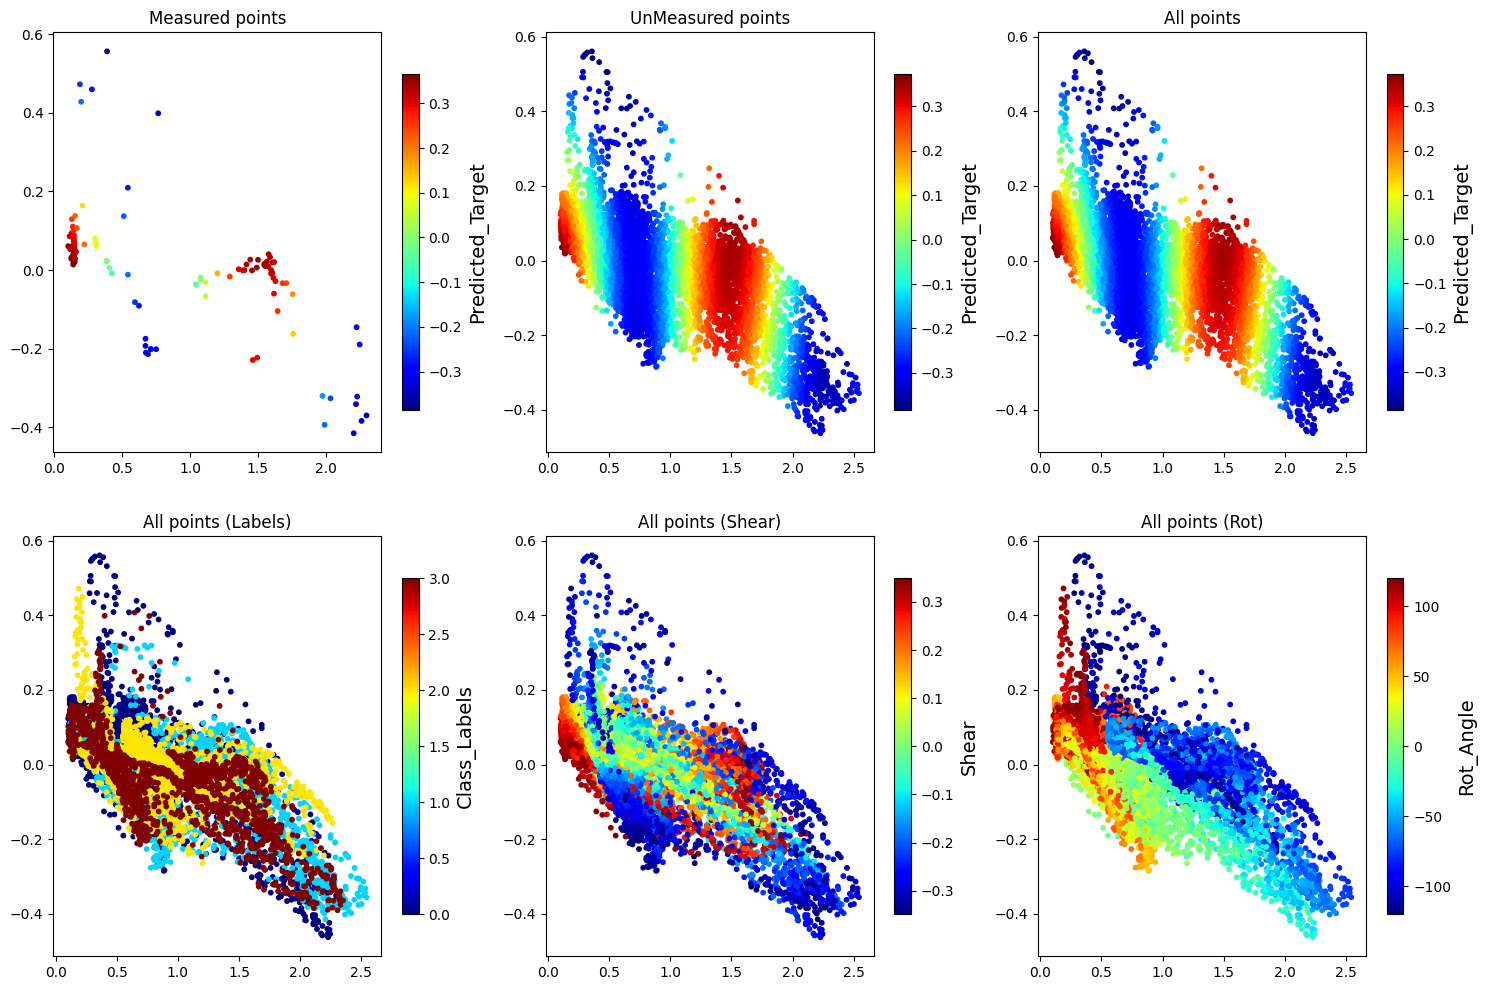

In [ ]:
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X5)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=10, c = predmean_train5, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=10,
                c = predmean_unmeas5, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

And now we have done it as active learning. NOte that in this case the predicted targets form two regions in latent space. So, th elatent distirbution is much better behaved then for VAE, but not as good as for the full DKL. Still, we learned only with 1% of the data.

## Rotations

In [ ]:
targets6 = np.copy(angles_all)

rng_key_6, rng_key_predict_6 = gpax.utils.get_keys()
dkl_6 = gpax.viDKL(900, 2, 'RBF')
dkl_6.fit(rng_key_6, X, targets6)

100%|██████████| 1000/1000 [03:43<00:00,  4.47it/s, init loss: 12825723.0869, avg. loss [951-1000]: 87448.8247]



Inferred GP kernel parameters
k_length         [2.2328 1.6335]
k_scale          1.8513000000000002
noise            1.459


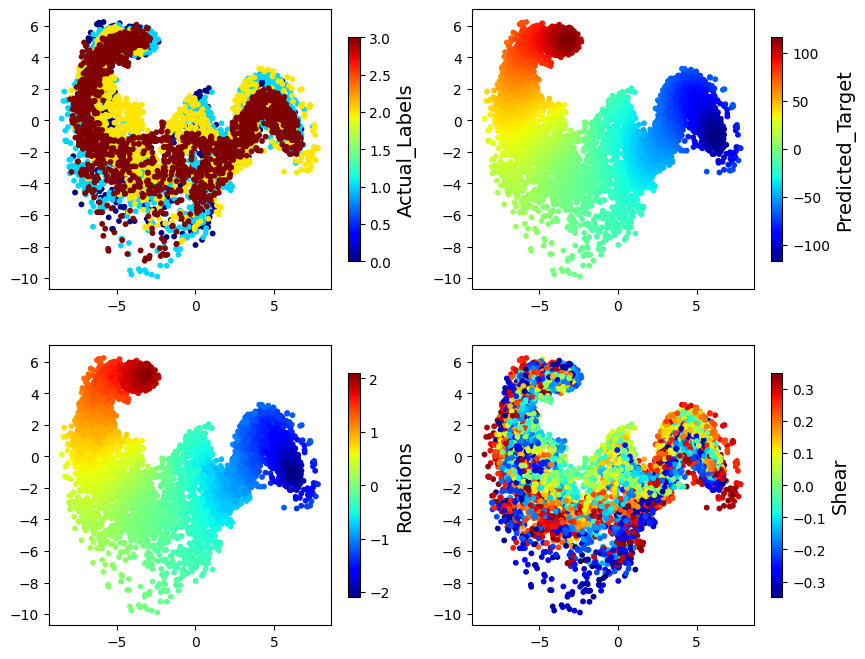

In [ ]:
embeded_6 = dkl_6.embed(X)
pred_mean6, pred_var6 = dkl_6.predict_in_batches(rng_key_predict_6, X, batch_size=batch_size_reconstruct)
pred_std6 = jnp.sqrt(pred_var6)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = pred_mean6, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = torch.deg2rad(angles_all), 
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [ ]:
X6 = np.copy(X)
np.random.seed(0)
idx6 = np.random.choice(np.arange(len(X6)), size = init_num, replace = False)
X6_train = X6[idx6]
X6_unmeasured = np.delete(X6, idx6, axis=0)

indices_total_6 = np.arange(len(X))
indices_train_6 = indices_total_6[idx6]
y6_train = targets6[idx6]
indices_unmeasured_6 = np.delete(indices_total_6, idx6)

In [ ]:
exp_mean6, exp_std6 = [], []
dkl_mean6, dkl_std6 = [], []
embed_traj6 = []
traj_mean6, traj_std6 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key16, rng_key_predict16 = gpax.utils.get_keys()
    dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_6.fit(rng_key16, X6_train, y6_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()
    
    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean6.append(y_mean[id_next])
    exp_std6.append(y_std[id_next])
    
    x_next = X6_unmeasured[id_next]
    ind_next = indices_unmeasured_6[id_next]
    
    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean6.append(pred_mean6[ind_next])
    dkl_std6.append(pred_std6[ind_next])
    
    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets6[ind_next]
    
    # Update training arrays
    X6_train = np.append(X6_train, x_next[None], axis=0)
    y6_train = np.append(y6_train, y_measured)
    X6_unmeasured = np.delete(X6_unmeasured, id_next, axis=0)
    indices_unmeasured_6 = np.delete(indices_unmeasured_6, id_next)
    
    embed_traj = dkl_BO_6.embed(X6_train)
    traj_m, traj_s = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_train, batch_size=batch_size_learn)
    
    embed_traj6.append(embed_traj)
    traj_mean6.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 450.44it/s, init loss: 82777.5575, avg. loss [951-1000]: 59574.8532]



Inferred GP kernel parameters
k_length         [1.1086 0.7912]
k_scale          8.142900000000001
noise            14.4109

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 436.68it/s, init loss: 84967.5317, avg. loss [951-1000]: 59794.4099]



Inferred GP kernel parameters
k_length         [1.1305 0.8218]
k_scale          8.1797
noise            14.353900000000001

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 452.95it/s, init loss: 88465.9312, avg. loss [951-1000]: 60316.7356]



Inferred GP kernel parameters
k_length         [1.3565 1.0645]
k_scale          8.4697
noise            13.9555

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 456.59it/s, init loss: 89066.6530, avg. loss [951-1000]: 59435.9468]



Inferred GP kernel parameters
k_length         [2.3776 2.6351]
k_scale          8.635
noise            7.364000000000001

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 462.04it/s, init loss: 89072.1551, avg. loss [951-1000]: 60126.2731]



Inferred GP kernel parameters
k_length         [1.5499 1.3152]
k_scale          8.6963
noise            13.202

Step 6


100%|██████████| 1000/1000 [00:04<00:00, 249.76it/s, init loss: 92579.5493, avg. loss [951-1000]: 60340.1351]



Inferred GP kernel parameters
k_length         [1.8387 1.339 ]
k_scale          10.6775
noise            8.721

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 444.95it/s, init loss: 92862.5881, avg. loss [951-1000]: 60376.7738]



Inferred GP kernel parameters
k_length         [1.61   1.2074]
k_scale          11.114
noise            8.624

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 442.61it/s, init loss: 92910.0410, avg. loss [951-1000]: 60452.5400]



Inferred GP kernel parameters
k_length         [1.8587 1.2409]
k_scale          10.090200000000001
noise            9.6707

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 440.42it/s, init loss: 94019.1729, avg. loss [951-1000]: 60584.6199]



Inferred GP kernel parameters
k_length         [1.4781 1.0266]
k_scale          8.4883
noise            12.113700000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 455.31it/s, init loss: 95767.4343, avg. loss [951-1000]: 60654.7869]



Inferred GP kernel parameters
k_length         [1.5161 1.0421]
k_scale          9.7573
noise            9.9908

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 450.62it/s, init loss: 98290.6887, avg. loss [951-1000]: 60739.0519]



Inferred GP kernel parameters
k_length         [1.5729 1.1151]
k_scale          9.6301
noise            9.2738

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 445.76it/s, init loss: 99359.8449, avg. loss [951-1000]: 60660.2232]



Inferred GP kernel parameters
k_length         [1.6926 1.2731]
k_scale          8.0876
noise            9.3224

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 444.95it/s, init loss: 101927.3751, avg. loss [951-1000]: 60912.1741]



Inferred GP kernel parameters
k_length         [1.806  1.4064]
k_scale          7.6863
noise            8.614600000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 440.82it/s, init loss: 103809.3184, avg. loss [951-1000]: 61342.2831]



Inferred GP kernel parameters
k_length         [1.5164 1.1332]
k_scale          8.6012
noise            11.1042

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 432.31it/s, init loss: 107444.4467, avg. loss [951-1000]: 60366.5179]



Inferred GP kernel parameters
k_length         [1.9081 1.4093]
k_scale          8.2844
noise            7.9173

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 436.82it/s, init loss: 109672.8193, avg. loss [951-1000]: 61495.4705]



Inferred GP kernel parameters
k_length         [1.4809 1.174 ]
k_scale          8.6743
noise            9.4849

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 437.16it/s, init loss: 113654.4710, avg. loss [951-1000]: 61517.4890]



Inferred GP kernel parameters
k_length         [1.5865 1.1336]
k_scale          8.7888
noise            8.990400000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 433.38it/s, init loss: 113666.6461, avg. loss [951-1000]: 61213.3413]



Inferred GP kernel parameters
k_length         [1.5927 1.2139]
k_scale          8.882200000000001
noise            7.3505

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 437.59it/s, init loss: 114368.7668, avg. loss [951-1000]: 61528.9818]



Inferred GP kernel parameters
k_length         [1.6066 1.3344]
k_scale          8.6546
noise            7.9954

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 444.72it/s, init loss: 114940.8676, avg. loss [951-1000]: 61628.9559]



Inferred GP kernel parameters
k_length         [1.4683 1.1002]
k_scale          8.900500000000001
noise            8.6133

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 440.13it/s, init loss: 115391.8897, avg. loss [951-1000]: 61481.9842]



Inferred GP kernel parameters
k_length         [1.6656 1.2097]
k_scale          8.667200000000001
noise            7.887700000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 442.26it/s, init loss: 116381.7212, avg. loss [951-1000]: 61405.6808]



Inferred GP kernel parameters
k_length         [1.7171 1.1618]
k_scale          8.7065
noise            8.738900000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 436.92it/s, init loss: 119082.4208, avg. loss [951-1000]: 61308.3395]



Inferred GP kernel parameters
k_length         [1.6289 1.1881]
k_scale          8.2431
noise            10.473500000000001

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 444.80it/s, init loss: 119928.6530, avg. loss [951-1000]: 61661.6745]



Inferred GP kernel parameters
k_length         [1.5287 1.0936]
k_scale          8.6404
noise            9.6461

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 440.59it/s, init loss: 121744.6643, avg. loss [951-1000]: 61699.1758]



Inferred GP kernel parameters
k_length         [1.4627 1.0496]
k_scale          8.1876
noise            10.5677

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 446.70it/s, init loss: 122273.7714, avg. loss [951-1000]: 60825.9238]



Inferred GP kernel parameters
k_length         [1.9064 1.3996]
k_scale          6.0567
noise            4.6241

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 444.94it/s, init loss: 122683.2839, avg. loss [951-1000]: 61362.8812]



Inferred GP kernel parameters
k_length         [1.8684 1.2068]
k_scale          6.6904
noise            7.9847

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 428.41it/s, init loss: 126155.3618, avg. loss [951-1000]: 61067.0478]



Inferred GP kernel parameters
k_length         [1.7054 1.2529]
k_scale          7.7072
noise            4.4748

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 445.40it/s, init loss: 126162.8782, avg. loss [951-1000]: 61223.2462]



Inferred GP kernel parameters
k_length         [1.7614 1.2281]
k_scale          7.470000000000001
noise            6.9293000000000005

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 444.02it/s, init loss: 127967.4993, avg. loss [951-1000]: 61535.6545]



Inferred GP kernel parameters
k_length         [1.6039 1.1556]
k_scale          7.8794
noise            7.0972

Step 31


100%|██████████| 1000/1000 [00:04<00:00, 245.55it/s, init loss: 128164.5257, avg. loss [951-1000]: 61042.6965]



Inferred GP kernel parameters
k_length         [1.8413 1.3633]
k_scale          6.325
noise            4.9781

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 439.92it/s, init loss: 128243.2202, avg. loss [951-1000]: 61658.8132]



Inferred GP kernel parameters
k_length         [1.64   1.1647]
k_scale          8.0347
noise            8.2483

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 441.62it/s, init loss: 128886.3711, avg. loss [951-1000]: 61558.0864]



Inferred GP kernel parameters
k_length         [1.7061 1.3051]
k_scale          7.957400000000001
noise            6.2214

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 429.84it/s, init loss: 131709.3702, avg. loss [951-1000]: 61741.2591]



Inferred GP kernel parameters
k_length         [1.6068 1.1434]
k_scale          8.2405
noise            6.7125

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 442.58it/s, init loss: 132017.0987, avg. loss [951-1000]: 61151.1624]



Inferred GP kernel parameters
k_length         [1.6897 1.1364]
k_scale          7.988300000000001
noise            7.227600000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 447.87it/s, init loss: 134836.6782, avg. loss [951-1000]: 60782.9355]



Inferred GP kernel parameters
k_length         [2.0283 1.3823]
k_scale          5.8198
noise            3.5824000000000003

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 446.12it/s, init loss: 138002.4700, avg. loss [951-1000]: 61440.7934]



Inferred GP kernel parameters
k_length         [1.7522 1.2585]
k_scale          6.0285
noise            5.6816

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 440.11it/s, init loss: 140570.0118, avg. loss [951-1000]: 61318.2031]



Inferred GP kernel parameters
k_length         [1.9183 1.4221]
k_scale          6.1207
noise            3.7896

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 434.31it/s, init loss: 141867.8549, avg. loss [951-1000]: 60898.5755]



Inferred GP kernel parameters
k_length         [2.0315 1.4531]
k_scale          5.5084
noise            3.8989000000000003

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 445.50it/s, init loss: 144464.1148, avg. loss [951-1000]: 61413.8509]



Inferred GP kernel parameters
k_length         [1.914  1.3136]
k_scale          5.6067
noise            4.5816

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 444.03it/s, init loss: 147392.4627, avg. loss [951-1000]: 61715.8877]



Inferred GP kernel parameters
k_length         [1.8225 1.2708]
k_scale          5.395700000000001
noise            5.5981000000000005

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 446.46it/s, init loss: 148777.6737, avg. loss [951-1000]: 60982.1187]



Inferred GP kernel parameters
k_length         [1.9404 1.2785]
k_scale          5.4221
noise            3.273

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 446.11it/s, init loss: 151111.7021, avg. loss [951-1000]: 61061.8937]



Inferred GP kernel parameters
k_length         [1.9563 1.3206]
k_scale          5.9665
noise            3.8328

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 431.99it/s, init loss: 151838.9646, avg. loss [951-1000]: 61235.3733]



Inferred GP kernel parameters
k_length         [2.1591 1.4041]
k_scale          4.571400000000001
noise            3.2714000000000003

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 419.24it/s, init loss: 151939.2445, avg. loss [951-1000]: 61037.1062]



Inferred GP kernel parameters
k_length         [2.0538 1.4092]
k_scale          4.786300000000001
noise            3.3953

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 429.82it/s, init loss: 153409.7323, avg. loss [951-1000]: 60833.7915]



Inferred GP kernel parameters
k_length         [1.993  1.3513]
k_scale          4.786300000000001
noise            4.5469

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 431.95it/s, init loss: 153747.4880, avg. loss [951-1000]: 61288.9473]



Inferred GP kernel parameters
k_length         [1.874  1.3544]
k_scale          6.7708
noise            4.0217

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 437.75it/s, init loss: 155005.8720, avg. loss [951-1000]: 61532.0939]



Inferred GP kernel parameters
k_length         [1.9939 1.3822]
k_scale          5.770300000000001
noise            3.5643000000000002

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 429.92it/s, init loss: 155680.6560, avg. loss [951-1000]: 61941.8266]



Inferred GP kernel parameters
k_length         [1.8827 1.2963]
k_scale          6.753500000000001
noise            4.9237

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 443.91it/s, init loss: 155844.1489, avg. loss [951-1000]: 61719.4576]



Inferred GP kernel parameters
k_length         [2.0066 1.3299]
k_scale          5.2541
noise            4.5074000000000005

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 434.93it/s, init loss: 156876.9717, avg. loss [951-1000]: 61262.6252]



Inferred GP kernel parameters
k_length         [1.915 1.298]
k_scale          5.3387
noise            3.1661

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 442.82it/s, init loss: 158104.4170, avg. loss [951-1000]: 61335.8351]



Inferred GP kernel parameters
k_length         [1.9962 1.3966]
k_scale          5.1606000000000005
noise            3.8168

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 426.56it/s, init loss: 160439.7108, avg. loss [951-1000]: 61364.2191]



Inferred GP kernel parameters
k_length         [1.9113 1.3255]
k_scale          5.099600000000001
noise            3.5404

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 418.62it/s, init loss: 161854.0976, avg. loss [951-1000]: 62350.1320]



Inferred GP kernel parameters
k_length         [1.9176 1.2713]
k_scale          7.2121
noise            4.4208

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 434.40it/s, init loss: 168852.7523, avg. loss [951-1000]: 61388.7550]



Inferred GP kernel parameters
k_length         [1.9492 1.3179]
k_scale          5.221900000000001
noise            2.9155

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 434.50it/s, init loss: 170157.3119, avg. loss [951-1000]: 61855.6212]



Inferred GP kernel parameters
k_length         [1.9258 1.3579]
k_scale          5.1338
noise            3.2943000000000002

Step 57


100%|██████████| 1000/1000 [00:04<00:00, 240.14it/s, init loss: 171984.9277, avg. loss [951-1000]: 62175.3282]



Inferred GP kernel parameters
k_length         [2.0474 1.345 ]
k_scale          5.612900000000001
noise            4.3684

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 442.62it/s, init loss: 175550.3515, avg. loss [951-1000]: 61854.1800]



Inferred GP kernel parameters
k_length         [2.0334 1.3385]
k_scale          4.8083
noise            3.2493000000000003

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 439.61it/s, init loss: 177722.3833, avg. loss [951-1000]: 61984.7414]



Inferred GP kernel parameters
k_length         [1.8814 1.3146]
k_scale          5.0038
noise            3.6687000000000003

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 432.76it/s, init loss: 179478.7245, avg. loss [951-1000]: 61685.8601]



Inferred GP kernel parameters
k_length         [1.9116 1.2997]
k_scale          5.4326
noise            3.6053

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 431.32it/s, init loss: 179687.3775, avg. loss [951-1000]: 61610.0075]



Inferred GP kernel parameters
k_length         [1.9894 1.3592]
k_scale          4.6013
noise            3.048

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 443.61it/s, init loss: 179998.3002, avg. loss [951-1000]: 61652.4391]



Inferred GP kernel parameters
k_length         [1.9077 1.3191]
k_scale          5.0395
noise            3.0167

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 440.15it/s, init loss: 181887.2541, avg. loss [951-1000]: 61447.7823]



Inferred GP kernel parameters
k_length         [1.8529 1.2566]
k_scale          5.3307
noise            2.9028

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 444.22it/s, init loss: 183779.3738, avg. loss [951-1000]: 61640.4114]



Inferred GP kernel parameters
k_length         [1.93   1.2756]
k_scale          5.0484
noise            2.9208000000000003

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 437.72it/s, init loss: 185096.4087, avg. loss [951-1000]: 62438.0027]



Inferred GP kernel parameters
k_length         [1.8573 1.2741]
k_scale          5.2151000000000005
noise            4.2657

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 427.58it/s, init loss: 185404.1402, avg. loss [951-1000]: 62799.9829]



Inferred GP kernel parameters
k_length         [1.7623 1.2406]
k_scale          6.942900000000001
noise            3.813

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 443.22it/s, init loss: 186834.1884, avg. loss [951-1000]: 62392.5391]



Inferred GP kernel parameters
k_length         [1.7955 1.2691]
k_scale          5.2006000000000006
noise            3.9603

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 432.94it/s, init loss: 187709.8121, avg. loss [951-1000]: 61556.8012]



Inferred GP kernel parameters
k_length         [2.0147 1.3177]
k_scale          4.919300000000001
noise            2.9087

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 437.95it/s, init loss: 188532.7639, avg. loss [951-1000]: 61760.7401]



Inferred GP kernel parameters
k_length         [1.9538 1.2996]
k_scale          4.7062
noise            2.7233

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 441.03it/s, init loss: 189731.5611, avg. loss [951-1000]: 62003.5745]



Inferred GP kernel parameters
k_length         [1.9294 1.3094]
k_scale          4.534800000000001
noise            3.6322

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 427.77it/s, init loss: 190235.5508, avg. loss [951-1000]: 61942.6521]



Inferred GP kernel parameters
k_length         [1.8608 1.2514]
k_scale          4.7468
noise            3.5948

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 436.87it/s, init loss: 190355.0185, avg. loss [951-1000]: 61807.2118]



Inferred GP kernel parameters
k_length         [1.9653 1.2917]
k_scale          4.7602
noise            2.7036000000000002

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 439.44it/s, init loss: 190502.4390, avg. loss [951-1000]: 62316.1539]



Inferred GP kernel parameters
k_length         [1.8338 1.273 ]
k_scale          4.6284
noise            3.9891

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 434.94it/s, init loss: 191333.7006, avg. loss [951-1000]: 61928.0842]



Inferred GP kernel parameters
k_length         [1.7997 1.2173]
k_scale          4.8246
noise            2.8759

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 427.42it/s, init loss: 193486.5645, avg. loss [951-1000]: 61749.5674]



Inferred GP kernel parameters
k_length         [1.8933 1.2561]
k_scale          4.7194
noise            2.6759

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 434.33it/s, init loss: 194505.9946, avg. loss [951-1000]: 61992.4910]



Inferred GP kernel parameters
k_length         [1.9336 1.268 ]
k_scale          4.6397
noise            3.7030000000000003

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 440.09it/s, init loss: 196431.5585, avg. loss [951-1000]: 62049.1775]



Inferred GP kernel parameters
k_length         [1.943 1.315]
k_scale          4.521100000000001
noise            3.0749

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 430.08it/s, init loss: 197376.0081, avg. loss [951-1000]: 62051.8244]



Inferred GP kernel parameters
k_length         [1.8724 1.2417]
k_scale          5.3519000000000005
noise            3.5758

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 438.11it/s, init loss: 200511.4064, avg. loss [951-1000]: 62137.8558]



Inferred GP kernel parameters
k_length         [1.9158 1.279 ]
k_scale          4.5786
noise            2.9211

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 436.11it/s, init loss: 202142.6012, avg. loss [951-1000]: 61936.2884]



Inferred GP kernel parameters
k_length         [1.9665 1.2834]
k_scale          4.742
noise            3.0774000000000004

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 439.45it/s, init loss: 205256.6081, avg. loss [951-1000]: 62500.4006]



Inferred GP kernel parameters
k_length         [1.8385 1.2255]
k_scale          4.625
noise            4.4161

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 435.71it/s, init loss: 205527.4890, avg. loss [951-1000]: 62523.4745]



Inferred GP kernel parameters
k_length         [1.8762 1.298 ]
k_scale          5.3761
noise            3.5466

Step 83


100%|██████████| 1000/1000 [00:04<00:00, 236.44it/s, init loss: 205633.1016, avg. loss [951-1000]: 61957.0114]



Inferred GP kernel parameters
k_length         [1.9503 1.3043]
k_scale          4.5845
noise            2.8827000000000003

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 436.78it/s, init loss: 209314.2384, avg. loss [951-1000]: 61971.0065]



Inferred GP kernel parameters
k_length         [1.9198 1.3445]
k_scale          4.371
noise            2.7669

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 433.78it/s, init loss: 211706.1191, avg. loss [951-1000]: 62209.5483]



Inferred GP kernel parameters
k_length         [1.8078 1.2516]
k_scale          4.8916
noise            2.9628

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 442.27it/s, init loss: 214409.7917, avg. loss [951-1000]: 62131.9047]



Inferred GP kernel parameters
k_length         [1.8573 1.2681]
k_scale          4.9523
noise            2.9632

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 440.54it/s, init loss: 215021.1840, avg. loss [951-1000]: 61794.7383]



Inferred GP kernel parameters
k_length         [1.8289 1.2679]
k_scale          4.8875
noise            3.1518

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 432.61it/s, init loss: 215615.0491, avg. loss [951-1000]: 62731.3040]



Inferred GP kernel parameters
k_length         [1.805  1.2436]
k_scale          5.4867
noise            4.1039

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 444.73it/s, init loss: 216072.8740, avg. loss [951-1000]: 62223.9222]



Inferred GP kernel parameters
k_length         [1.8152 1.2314]
k_scale          4.9537
noise            3.1039000000000003

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 440.66it/s, init loss: 216200.6379, avg. loss [951-1000]: 62444.5545]



Inferred GP kernel parameters
k_length         [1.7963 1.2887]
k_scale          4.986800000000001
noise            4.0755

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 437.99it/s, init loss: 216705.0184, avg. loss [951-1000]: 62534.8070]



Inferred GP kernel parameters
k_length         [1.8274 1.2593]
k_scale          5.0129
noise            3.7539000000000002

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 433.82it/s, init loss: 217612.5583, avg. loss [951-1000]: 62575.2375]



Inferred GP kernel parameters
k_length         [1.8102 1.242 ]
k_scale          4.5501000000000005
noise            3.8739000000000003

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 429.27it/s, init loss: 218313.7893, avg. loss [951-1000]: 62903.1747]



Inferred GP kernel parameters
k_length         [1.7162 1.238 ]
k_scale          4.557
noise            3.9153000000000002

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 433.09it/s, init loss: 218323.3951, avg. loss [951-1000]: 62407.1985]



Inferred GP kernel parameters
k_length         [1.8702 1.292 ]
k_scale          5.0661000000000005
noise            2.8241

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 434.89it/s, init loss: 219566.9049, avg. loss [951-1000]: 62644.8872]



Inferred GP kernel parameters
k_length         [1.7106 1.2079]
k_scale          4.6145000000000005
noise            3.9646000000000003

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 436.12it/s, init loss: 219569.3031, avg. loss [951-1000]: 62803.1593]



Inferred GP kernel parameters
k_length         [1.7577 1.205 ]
k_scale          4.6855
noise            4.1770000000000005

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 436.25it/s, init loss: 219729.0082, avg. loss [951-1000]: 62632.2688]



Inferred GP kernel parameters
k_length         [1.8222 1.29  ]
k_scale          4.3223
noise            3.4428

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 426.96it/s, init loss: 219740.6664, avg. loss [951-1000]: 62679.4346]



Inferred GP kernel parameters
k_length         [1.7587 1.2043]
k_scale          5.3989
noise            3.3027

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 438.42it/s, init loss: 220207.9571, avg. loss [951-1000]: 62365.0439]



Inferred GP kernel parameters
k_length         [1.8606 1.2507]
k_scale          4.407500000000001
noise            3.0117000000000003

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 434.56it/s, init loss: 223962.7827, avg. loss [951-1000]: 62228.9951]



Inferred GP kernel parameters
k_length         [1.8926 1.3137]
k_scale          4.307300000000001
noise            2.7934


In [ ]:
rng_key16, rng_key_predict16 = gpax.utils.get_keys()
dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_6.fit(rng_key16, X6_train, y6_train)

predmean_train6, predstd_train6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_train, batch_size=batch_size_learn)
predmean_unmeas6, predstd_unmeas6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_unmeasured, batch_size=batch_size_reconstruct)
predmean16, predstd16 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 441.97it/s, init loss: 225046.8989, avg. loss [951-1000]: 63451.5539]



Inferred GP kernel parameters
k_length         [1.7264 1.1874]
k_scale          5.375500000000001
noise            4.9431


In [ ]:
rot_results = {}
rot_results['X_train'] = X6_train
rot_results['y_train'] = y6_train
rot_results['X_unmeasured'] = X6_unmeasured
rot_results['indices_unmeasured'] = indices_unmeasured_6
rot_results['dkl_mean'] = dkl_mean6
rot_results['dkl_std'] = dkl_std6
rot_results['exp_mean'] = exp_mean6
rot_results['exp_std'] = exp_std6
rot_results['traj_mean'] = traj_mean6
rot_results['traj_std'] = traj_std6
rot_results['embed_traj'] = embed_traj6

with open('rot_results.pickle', 'wb') as handle:
    pickle.dump(rot_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

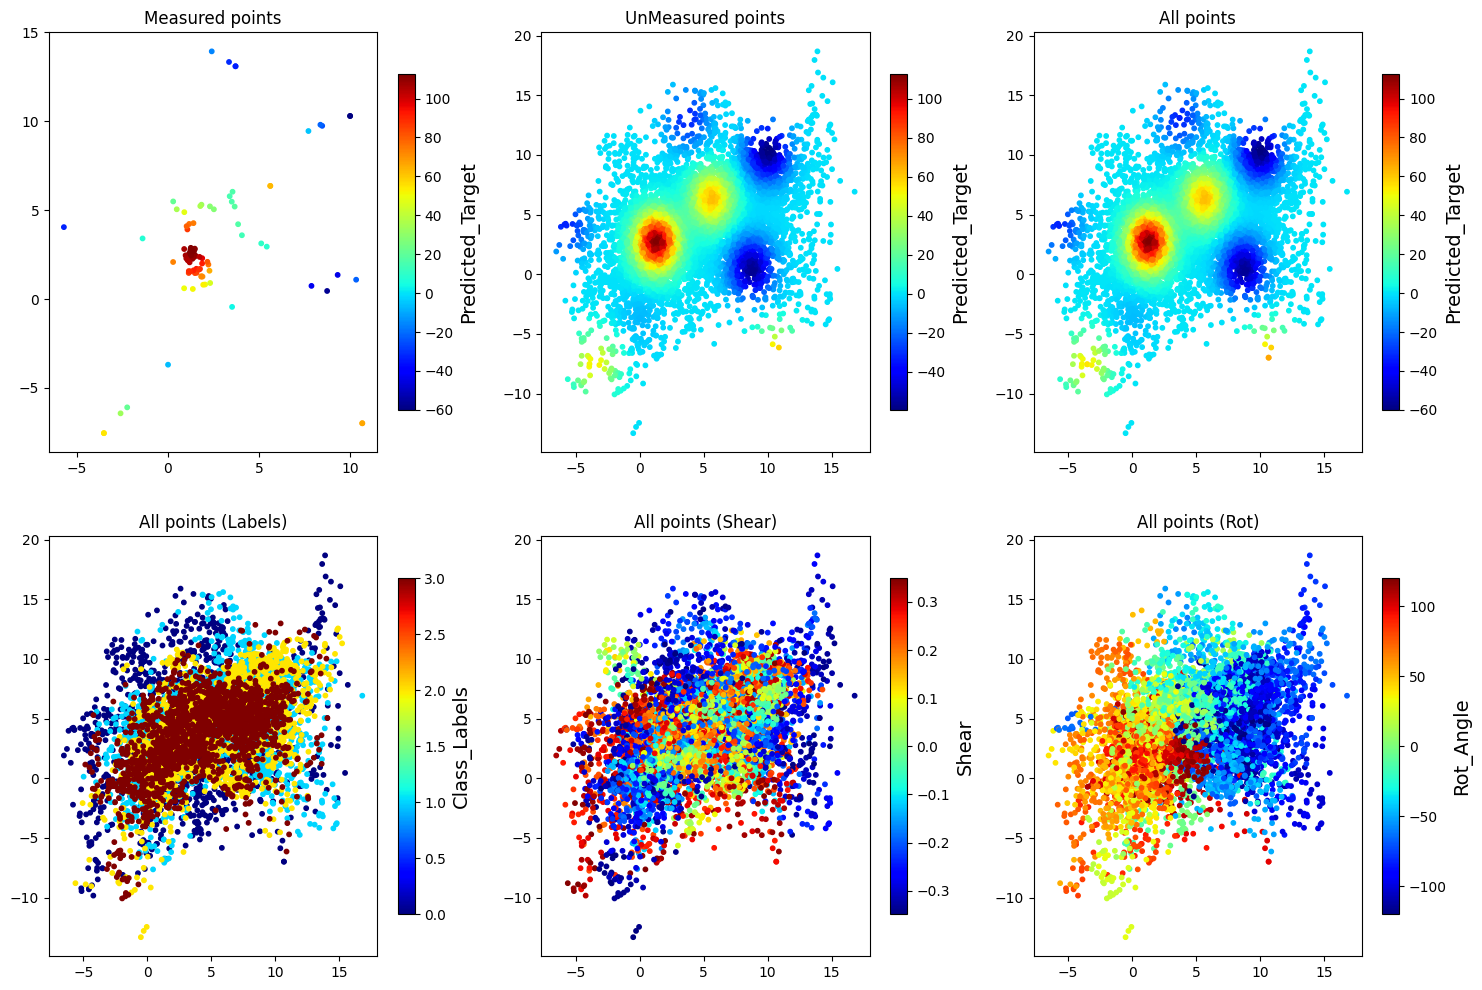

In [ ]:
embeded_train6 = dkl_BO_6.embed(X6_train)  # Measured points
embeded_unmeasured6 = dkl_BO_6.embed(X6_unmeasured)  # Unmeasured points
embeded16 = dkl_BO_6.embed(X6)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train6[:, 1], embeded_train6[:, 0], s=10, c = predmean_train6, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured6[:, 1], embeded_unmeasured6[:, 0], s=10,
                c = predmean_unmeas6, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = predmean16, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)